In [1]:
%%javascript

window.scroll_flag = true
window.scroll_exit = false
window.scroll_delay = 100

$(".output_scroll").each(function() {
    $(this)[0].scrollTop = $(this)[0].scrollHeight;
});

function callScrollToBottom() {
    setTimeout(scrollToBottom, window.scroll_delay);
}

function scrollToBottom() {
    if (window.scroll_exit) {
        return;
    }
    if (!window.scroll_flag) {
        callScrollToBottom();
        return;
    };
    
    $(".output_scroll").each(function() {
        if (!$(this).attr('scroll_checkbox')){
            window.scroll_flag = true;
            $(this).attr('scroll_checkbox',true);
            var div = document.createElement('div');
            var checkbox = document.createElement('input');
            checkbox.type = "checkbox";
            checkbox.onclick = function(){window.scroll_flag = checkbox.checked}
            checkbox.checked = "checked"
            div.append("Auto-Scroll-To-Bottom: ");
            div.append(checkbox);
            $(this).parent().before(div);
        }
        
        $(this)[0].scrollTop = $(this)[0].scrollHeight;
    });
    callScrollToBottom();
}
scrollToBottom();

<IPython.core.display.Javascript object>

In [2]:
import torch
import torch.nn as nn
import torchvision
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data as data
import os
import sys
import argparse
import time
import numpy as np
from torchvision import transforms
import glob
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms
from matplotlib import pyplot as plt
from natsort import natsorted

# Dataloader

In [3]:
#Loading images paths
path = "L:\\BOUDIAF\\Dataset001\\"
rgb_list = sorted(glob.glob(os.path.join(path, 'rgb\\*.png')))
depth_list = sorted(glob.glob(os.path.join(path, 'depth\\*.png')))

In [4]:
path = rgb_list[0]
img = cv2.imread(path, cv2.COLOR_BGR2RGB).astype(np.float32) 
img /= 255.
img = np.expand_dims(img, axis=0)
path = rgb_list[1]
img1 = cv2.imread(path, cv2.COLOR_BGR2RGB).astype(np.float32) 
img1 /= 255.
img1 = np.expand_dims(img1, axis=0)
# images = np.append(images, np.expand_dims(img, axis=0), axis=0)

In [5]:
img1.shape

(1, 144, 256, 3)

In [6]:
#Loading steering direction
filename = 'L:\\BOUDIAF\\Dataset001\\steering_angels.csv'
steering = np.loadtxt(filename, delimiter=',', skiprows=0, dtype=np.float64)
steering = steering[14:]
#Convert steering angle to calsses
steering_idx = []
for i in steering:
    if(i == 0):
        steering_idx.append(0)
    elif(i == 0.5):
        steering_idx.append(1)
    elif(i == -0.5):
        steering_idx.append(2)

In [7]:
#Number of classes (srtight, left and right) in data
steering_idx.count(0), steering_idx.count(1), steering_idx.count(2)

(31373, 3856, 2554)

In [8]:
stright_idxs = [i for i, x in enumerate(steering_idx) if x == 0]
right_idxs = [i for i, x in enumerate(steering_idx) if x == 1]
left_idxs = [i for i, x in enumerate(steering_idx) if x == 2]

In [9]:
class Dataset(torch.utils.data.Dataset):
  
    def __init__(self, data, window):
        self.data = data
        self.window = window

    def __getitem__(self, index):
        images = np.empty((1, 144, 256, 3), dtype= np.float32)
        if (index+self.window) <= len(self.data):
            x = self.data[index:index+self.window]
            for path in x:
                img = cv2.imread(path, cv2.COLOR_BGR2RGB).astype(np.float32) 
                img /= 255.
                img = np.expand_dims(img, axis=0)
                images = np.append(images, img, axis=0)
            return [np.moveaxis(images[1:], -1, 0) , steering_idx[index]]

    def __len__(self):
        return (len(self.data) - self.window) + 1 

In [10]:
train_dataset = Dataset(rgb_list, 15)

In [11]:
w1 = 1 - (len(stright_idxs)/len(train_dataset))
w2 = 1 - (len(right_idxs)/len(train_dataset))
w3 = 1 - (len(left_idxs)/len(train_dataset))

In [12]:
class_weights = []
for i in steering_idx:
    if(i == 0):
        class_weights.append(w1)
    elif(i == 1):
        class_weights.append(w2)
    elif(i == 2):
        class_weights.append(w3)

In [13]:
WeightSampler = torch.utils.data.WeightedRandomSampler(class_weights, len(class_weights))

In [14]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=False, sampler=WeightSampler)

In [15]:
for idx, (input_img, gt) in enumerate(train_loader):
    break

In [16]:
type(input_img), type(gt)

(torch.Tensor, torch.Tensor)

In [17]:
input_img.shape, gt.shape

(torch.Size([8, 3, 15, 144, 256]), torch.Size([8]))

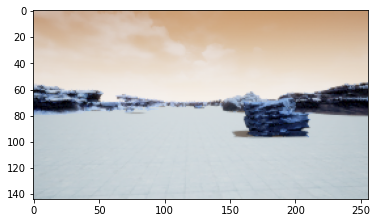

1


In [18]:
tst = input_img[0].numpy()
tst = np.moveaxis(tst, 0, -1)[0]
plt.imshow(tst)
plt.show()
print(gt.item())

# Network

In [15]:
class NavNet(nn.Module):
    def __init__(self):
        super(NavNet, self).__init__()

        self.relu = nn.ReLU(inplace=True)

        self.conv3d_1_1 = nn.Conv3d(3, 8, 3, stride=1, padding='same') 
        self.conv3d_1_2 = nn.Conv3d(8, 8, 3, stride=1, padding='same', dilation=1, groups=1, bias=True, padding_mode='zeros') 
        self.conv3d_2_1 = nn.Conv3d(8, 16, 3, stride=1, padding='same', dilation=1, groups=1, bias=True, padding_mode='zeros') 
        self.conv3d_2_2 = nn.Conv3d(16, 16, 3, stride=1, padding='same', dilation=1, groups=1, bias=True, padding_mode='zeros') 
        self.fc1 = nn.Linear(1179648, 100, bias=True)
        self.fc2 = nn.Linear(100, 100, bias=True)
        self.fc3 = nn.Linear(100, 3, bias=True)

        self.max = nn.AdaptiveAvgPool3d((72,128,8)) 

    def forward(self, x):
        source = []
        source.append(x)
#         print("input: ",x.shape[-1])
#         print("input: ",x.shape)
        x1 = self.relu(self.conv3d_1_1(x))
#         print("output1: ",x1.shape)
        x2 = self.relu(self.conv3d_1_2(x1))
#         print("output2: ",x2.shape)


        max1 = self.max(x2)
#         print("output max1: ",max1.shape)
   
    
        x3 = self.relu(self.conv3d_2_1(max1))
#         print("output3: ",x3.shape)
        x4 = self.relu(self.conv3d_2_2(x3))
#         print("output4: ",x4.shape)

        # concat3 = torch.cat((x1,x2,x3,x4),1)
#         print("output5: ",torch.flatten(x4).shape)
        x5 = self.relu(self.fc1(torch.flatten(x4)))
#         print("output5: ",x5.shape)
        x6 = self.relu(self.fc2(x5))
        x7 = self.relu(self.fc3(x6))
        max_index = (x7 == torch.max(x7).item()).nonzero(as_tuple=True)[0]

        return max_index, x7

# Training

In [16]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

In [20]:
import torch.optim as optim

In [27]:
model = NavNet().to(device)
loss = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(NavNet().parameters(), lr=0.0001, weight_decay=0)
optimizer = optim.SGD(model.parameters(), lr=0.00005, momentum=0.7)

In [28]:
l = len(rgb_list)
loss_file = open('L:\\BOUDIAF\\Nav\\model009\\read_me.txt', 'a')
loss_file.truncate(0) #Delete everything in the txt file
for epoch in range(10):
    print("**************** epoch ", str(epoch), "****************")
    for idx, (input_img, gt) in enumerate(train_loader):
        torch.cuda.empty_cache()
        optimizer.zero_grad()
        avg_loss = 0
        for  x,y in zip(input_img, gt):
            x = torch.unsqueeze(x, 0)
            y = torch.unsqueeze(y, 0)
            x = x.to(device)
            direction, output = model(x)
            y = y.to(device)
            lss = loss(torch.unsqueeze(output, 0), y)
            avg_loss += lss.item()
            lss.backward()
            optimizer.step()
            if(y.item() == 0):
                loss_file.write('class0:'+ str(round(lss.item(),3)) +'\n') #Write into file
            elif(y.item() == 1):
                loss_file.write('class1:'+ str(round(lss.item(),3)) +'\n') #Write into file
            elif(y.item() == 2):
                loss_file.write('class2:'+ str(round(lss.item(),3)) +'\n') #Write into file
        print(round(idx*100/l,2), '%   loss:',  round(avg_loss,3))
    torch.save(model.state_dict(), "L:\\BOUDIAF\\Nav\\model009\\" + "Epoch" + str(epoch) + '.pth') 
loss_file.close()

**************** epoch  0 ****************
0.0 %   loss: 8.796
0.0 %   loss: 8.872
0.01 %   loss: 8.862
0.01 %   loss: 8.932
0.01 %   loss: 8.795
0.01 %   loss: 8.819
0.02 %   loss: 8.798
0.02 %   loss: 8.794
0.02 %   loss: 8.768
0.02 %   loss: 8.724
0.03 %   loss: 8.708
0.03 %   loss: 8.668
0.03 %   loss: 8.626
0.03 %   loss: 8.745
0.04 %   loss: 8.952
0.04 %   loss: 8.695
0.04 %   loss: 8.719
0.04 %   loss: 8.697
0.05 %   loss: 8.605
0.05 %   loss: 8.753
0.05 %   loss: 8.787
0.06 %   loss: 8.962
0.06 %   loss: 8.814
0.06 %   loss: 8.735
0.06 %   loss: 8.716
0.07 %   loss: 8.719
0.07 %   loss: 8.644
0.07 %   loss: 8.728
0.07 %   loss: 8.943
0.08 %   loss: 8.496
0.08 %   loss: 8.928
0.08 %   loss: 8.676
0.08 %   loss: 8.529
0.09 %   loss: 8.588
0.09 %   loss: 8.648
0.09 %   loss: 8.41
0.1 %   loss: 8.718
0.1 %   loss: 8.379
0.1 %   loss: 8.51
0.1 %   loss: 8.449
0.11 %   loss: 8.492
0.11 %   loss: 8.599
0.11 %   loss: 8.389
0.11 %   loss: 8.977
0.12 %   loss: 8.542
0.12 %   loss: 8.323

1.04 %   loss: 8.104
1.04 %   loss: 8.078
1.04 %   loss: 6.627
1.05 %   loss: 6.974
1.05 %   loss: 8.886
1.05 %   loss: 6.697
1.05 %   loss: 11.271
1.06 %   loss: 7.925
1.06 %   loss: 8.391
1.06 %   loss: 7.708
1.06 %   loss: 7.547
1.07 %   loss: 8.164
1.07 %   loss: 6.248
1.07 %   loss: 8.962
1.07 %   loss: 9.963
1.08 %   loss: 7.702
1.08 %   loss: 7.35
1.08 %   loss: 8.267
1.08 %   loss: 9.302
1.09 %   loss: 6.798
1.09 %   loss: 9.718
1.09 %   loss: 7.321
1.1 %   loss: 9.087
1.1 %   loss: 7.784
1.1 %   loss: 6.984
1.1 %   loss: 11.201
1.11 %   loss: 7.865
1.11 %   loss: 7.946
1.11 %   loss: 6.648
1.11 %   loss: 7.968
1.12 %   loss: 9.07
1.12 %   loss: 8.914
1.12 %   loss: 9.176
1.12 %   loss: 7.621
1.13 %   loss: 7.359
1.13 %   loss: 8.534
1.13 %   loss: 6.939
1.14 %   loss: 6.458
1.14 %   loss: 8.343
1.14 %   loss: 8.783
1.14 %   loss: 8.077
1.15 %   loss: 6.601
1.15 %   loss: 8.008
1.15 %   loss: 8.327
1.15 %   loss: 7.796
1.16 %   loss: 9.313
1.16 %   loss: 9.463
1.16 %   loss: 8.

2.08 %   loss: 5.093
2.08 %   loss: 6.527
2.08 %   loss: 6.385
2.09 %   loss: 6.703
2.09 %   loss: 5.832
2.09 %   loss: 5.808
2.1 %   loss: 6.258
2.1 %   loss: 7.139
2.1 %   loss: 6.858
2.1 %   loss: 7.522
2.11 %   loss: 7.639
2.11 %   loss: 4.63
2.11 %   loss: 5.922
2.11 %   loss: 6.497
2.12 %   loss: 6.169
2.12 %   loss: 8.204
2.12 %   loss: 6.256
2.12 %   loss: 4.937
2.13 %   loss: 3.675
2.13 %   loss: 8.251
2.13 %   loss: 7.243
2.14 %   loss: 5.015
2.14 %   loss: 8.931
2.14 %   loss: 9.865
2.14 %   loss: 6.439
2.15 %   loss: 5.96
2.15 %   loss: 5.563
2.15 %   loss: 5.665
2.15 %   loss: 4.715
2.16 %   loss: 6.106
2.16 %   loss: 6.827
2.16 %   loss: 7.682
2.16 %   loss: 9.662
2.17 %   loss: 8.023
2.17 %   loss: 8.046
2.17 %   loss: 5.209
2.17 %   loss: 6.661
2.18 %   loss: 5.047
2.18 %   loss: 6.317
2.18 %   loss: 7.982
2.19 %   loss: 5.034
2.19 %   loss: 8.83
2.19 %   loss: 5.986
2.19 %   loss: 8.773
2.2 %   loss: 6.231
2.2 %   loss: 7.937
2.2 %   loss: 5.505
2.2 %   loss: 8.155
2.2

3.12 %   loss: 6.604
3.12 %   loss: 4.595
3.13 %   loss: 5.759
3.13 %   loss: 6.221
3.13 %   loss: 6.71
3.14 %   loss: 5.533
3.14 %   loss: 5.308
3.14 %   loss: 5.631
3.14 %   loss: 8.975
3.15 %   loss: 8.495
3.15 %   loss: 10.663
3.15 %   loss: 6.151
3.15 %   loss: 4.882
3.16 %   loss: 7.056
3.16 %   loss: 5.946
3.16 %   loss: 5.898
3.16 %   loss: 6.504
3.17 %   loss: 7.289
3.17 %   loss: 5.658
3.17 %   loss: 10.504
3.17 %   loss: 7.166
3.18 %   loss: 7.168
3.18 %   loss: 6.135
3.18 %   loss: 6.04
3.19 %   loss: 7.111
3.19 %   loss: 5.973
3.19 %   loss: 6.613
3.19 %   loss: 7.876
3.2 %   loss: 3.723
3.2 %   loss: 5.465
3.2 %   loss: 7.453
3.2 %   loss: 7.718
3.21 %   loss: 5.693
3.21 %   loss: 3.926
3.21 %   loss: 4.265
3.21 %   loss: 6.112
3.22 %   loss: 3.767
3.22 %   loss: 6.968
3.22 %   loss: 6.538
3.23 %   loss: 8.45
3.23 %   loss: 6.533
3.23 %   loss: 4.406
3.23 %   loss: 7.988
3.24 %   loss: 8.369
3.24 %   loss: 5.671
3.24 %   loss: 8.23
3.24 %   loss: 8.164
3.25 %   loss: 6.63

4.16 %   loss: 5.458
4.17 %   loss: 3.188
4.17 %   loss: 5.459
4.17 %   loss: 3.049
4.17 %   loss: 2.906
4.18 %   loss: 3.329
4.18 %   loss: 4.891
4.18 %   loss: 1.572
4.19 %   loss: 2.481
4.19 %   loss: 9.553
4.19 %   loss: 3.315
4.19 %   loss: 3.817
4.2 %   loss: 6.713
4.2 %   loss: 5.212
4.2 %   loss: 7.643
4.2 %   loss: 3.587
4.21 %   loss: 4.762
4.21 %   loss: 3.362
4.21 %   loss: 5.438
4.21 %   loss: 7.912
4.22 %   loss: 11.045
4.22 %   loss: 7.071
4.22 %   loss: 6.181
4.23 %   loss: 6.206
4.23 %   loss: 5.52
4.23 %   loss: 4.185
4.23 %   loss: 5.339
4.24 %   loss: 4.893
4.24 %   loss: 6.38
4.24 %   loss: 7.403
4.24 %   loss: 3.613
4.25 %   loss: 6.596
4.25 %   loss: 5.212
4.25 %   loss: 2.618
4.25 %   loss: 6.012
4.26 %   loss: 7.058
4.26 %   loss: 8.223
4.26 %   loss: 3.988
4.26 %   loss: 4.654
4.27 %   loss: 3.864
4.27 %   loss: 5.392
4.27 %   loss: 4.248
4.28 %   loss: 7.217
4.28 %   loss: 5.715
4.28 %   loss: 7.834
4.28 %   loss: 2.79
4.29 %   loss: 6.976
4.29 %   loss: 5.71

5.21 %   loss: 5.393
5.21 %   loss: 4.899
5.21 %   loss: 5.009
5.21 %   loss: 2.868
5.22 %   loss: 2.051
5.22 %   loss: 4.666
5.22 %   loss: 5.999
5.23 %   loss: 2.912
5.23 %   loss: 7.831
5.23 %   loss: 4.289
5.23 %   loss: 3.095
5.24 %   loss: 9.112
5.24 %   loss: 8.67
5.24 %   loss: 6.06
5.24 %   loss: 4.019
5.25 %   loss: 3.614
5.25 %   loss: 5.164
5.25 %   loss: 3.42
5.25 %   loss: 2.503
5.26 %   loss: 7.624
5.26 %   loss: 3.145
5.26 %   loss: 11.054
5.26 %   loss: 4.112
5.27 %   loss: 2.872
5.27 %   loss: 3.569
5.27 %   loss: 3.953
5.28 %   loss: 1.439
5.28 %   loss: 9.233
5.28 %   loss: 6.126
5.28 %   loss: 6.129
5.29 %   loss: 5.026
5.29 %   loss: 4.366
5.29 %   loss: 5.02
5.29 %   loss: 2.259
5.3 %   loss: 1.953
5.3 %   loss: 1.433
5.3 %   loss: 1.439
5.3 %   loss: 5.87
5.31 %   loss: 3.824
5.31 %   loss: 9.565
5.31 %   loss: 5.214
5.32 %   loss: 8.456
5.32 %   loss: 5.854
5.32 %   loss: 4.625
5.32 %   loss: 2.37
5.33 %   loss: 2.73
5.33 %   loss: 2.651
5.33 %   loss: 4.347
5.

6.25 %   loss: 3.625
6.25 %   loss: 2.213
6.26 %   loss: 5.427
6.26 %   loss: 2.919
6.26 %   loss: 8.515
6.27 %   loss: 1.9
6.27 %   loss: 3.133
6.27 %   loss: 6.282
6.27 %   loss: 7.359
6.28 %   loss: 4.105
6.28 %   loss: 5.569
6.28 %   loss: 3.993
6.28 %   loss: 3.513
6.29 %   loss: 4.395
6.29 %   loss: 2.629
6.29 %   loss: 9.37
6.29 %   loss: 3.589
6.3 %   loss: 5.119
6.3 %   loss: 2.162
6.3 %   loss: 4.49
6.3 %   loss: 5.9
6.31 %   loss: 5.593
6.31 %   loss: 6.774
6.31 %   loss: 3.384
6.32 %   loss: 7.72
6.32 %   loss: 3.247
6.32 %   loss: 5.137
6.32 %   loss: 6.749
6.33 %   loss: 4.564
6.33 %   loss: 3.896
6.33 %   loss: 5.194
6.33 %   loss: 3.294
6.34 %   loss: 4.524
6.34 %   loss: 6.76
6.34 %   loss: 5.912
6.34 %   loss: 4.328
6.35 %   loss: 2.628
6.35 %   loss: 5.668
6.35 %   loss: 7.495
6.36 %   loss: 4.795
6.36 %   loss: 3.046
6.36 %   loss: 5.229
6.36 %   loss: 6.437
6.37 %   loss: 3.404
6.37 %   loss: 5.229
6.37 %   loss: 5.743
6.37 %   loss: 3.735
6.38 %   loss: 3.994
6.38

7.3 %   loss: 3.496
7.3 %   loss: 7.188
7.3 %   loss: 3.055
7.3 %   loss: 4.243
7.31 %   loss: 1.545
7.31 %   loss: 5.095
7.31 %   loss: 2.803
7.32 %   loss: 4.176
7.32 %   loss: 4.798
7.32 %   loss: 2.02
7.32 %   loss: 2.88
7.33 %   loss: 2.475
7.33 %   loss: 3.078
7.33 %   loss: 3.973
7.33 %   loss: 2.47
7.34 %   loss: 4.29
7.34 %   loss: 2.383
7.34 %   loss: 10.457
7.34 %   loss: 2.207
7.35 %   loss: 4.981
7.35 %   loss: 6.58
7.35 %   loss: 4.326
7.36 %   loss: 3.5
7.36 %   loss: 2.046
7.36 %   loss: 5.055
7.36 %   loss: 4.231
7.37 %   loss: 3.581
7.37 %   loss: 11.262
7.37 %   loss: 3.805
7.37 %   loss: 4.711
7.38 %   loss: 4.17
7.38 %   loss: 4.201
7.38 %   loss: 4.157
7.38 %   loss: 3.214
7.39 %   loss: 4.498
7.39 %   loss: 2.582
7.39 %   loss: 3.999
7.39 %   loss: 10.457
7.4 %   loss: 5.161
7.4 %   loss: 6.634
7.4 %   loss: 4.142
7.41 %   loss: 6.066
7.41 %   loss: 4.238
7.41 %   loss: 5.579
7.41 %   loss: 6.07
7.42 %   loss: 3.975
7.42 %   loss: 1.678
7.42 %   loss: 3.022
7.42 

8.34 %   loss: 3.293
8.34 %   loss: 3.682
8.34 %   loss: 6.503
8.35 %   loss: 5.618
8.35 %   loss: 3.053
8.35 %   loss: 3.281
8.36 %   loss: 3.391
8.36 %   loss: 4.181
8.36 %   loss: 1.742
8.36 %   loss: 1.161
8.37 %   loss: 6.184
8.37 %   loss: 4.689
8.37 %   loss: 4.579
8.37 %   loss: 6.019
8.38 %   loss: 4.458
8.38 %   loss: 3.582
8.38 %   loss: 3.56
8.38 %   loss: 5.987
8.39 %   loss: 5.214
8.39 %   loss: 5.27
8.39 %   loss: 8.135
8.39 %   loss: 7.305
8.4 %   loss: 5.478
8.4 %   loss: 5.821
8.4 %   loss: 3.139
8.41 %   loss: 4.394
8.41 %   loss: 3.511
8.41 %   loss: 2.087
8.41 %   loss: 4.099
8.42 %   loss: 4.645
8.42 %   loss: 3.776
8.42 %   loss: 9.005
8.42 %   loss: 6.295
8.43 %   loss: 7.301
8.43 %   loss: 4.469
8.43 %   loss: 3.454
8.43 %   loss: 5.708
8.44 %   loss: 3.094
8.44 %   loss: 4.367
8.44 %   loss: 4.017
8.45 %   loss: 6.115
8.45 %   loss: 5.112
8.45 %   loss: 8.595
8.45 %   loss: 5.601
8.46 %   loss: 4.58
8.46 %   loss: 3.923
8.46 %   loss: 2.218
8.46 %   loss: 2.70

9.38 %   loss: 10.083
9.39 %   loss: 2.984
9.39 %   loss: 4.093
9.39 %   loss: 5.01
9.39 %   loss: 4.255
9.4 %   loss: 3.724
9.4 %   loss: 3.337
9.4 %   loss: 4.052
9.41 %   loss: 6.23
9.41 %   loss: 5.412
9.41 %   loss: 3.472
9.41 %   loss: 5.062
9.42 %   loss: 2.9
9.42 %   loss: 4.437
9.42 %   loss: 1.738
9.42 %   loss: 5.374
9.43 %   loss: 10.202
9.43 %   loss: 4.562
9.43 %   loss: 4.059
9.43 %   loss: 5.257
9.44 %   loss: 5.97
9.44 %   loss: 6.418
9.44 %   loss: 3.323
9.45 %   loss: 4.175
9.45 %   loss: 6.272
9.45 %   loss: 2.534
9.45 %   loss: 4.033
9.46 %   loss: 4.193
9.46 %   loss: 4.021
9.46 %   loss: 7.247
9.46 %   loss: 3.273
9.47 %   loss: 2.299
9.47 %   loss: 11.454
9.47 %   loss: 5.336
9.47 %   loss: 3.43
9.48 %   loss: 4.67
9.48 %   loss: 2.48
9.48 %   loss: 6.077
9.48 %   loss: 4.06
9.49 %   loss: 3.015
9.49 %   loss: 2.417
9.49 %   loss: 8.096
9.5 %   loss: 5.41
9.5 %   loss: 3.796
9.5 %   loss: 2.356
9.5 %   loss: 5.058
9.51 %   loss: 4.638
9.51 %   loss: 4.176
9.51 %

10.41 %   loss: 2.935
10.41 %   loss: 7.45
10.41 %   loss: 4.663
10.42 %   loss: 2.789
10.42 %   loss: 5.05
10.42 %   loss: 8.138
10.42 %   loss: 4.64
10.43 %   loss: 6.783
10.43 %   loss: 7.174
10.43 %   loss: 3.022
10.43 %   loss: 4.924
10.44 %   loss: 3.511
10.44 %   loss: 5.553
10.44 %   loss: 5.502
10.45 %   loss: 3.444
10.45 %   loss: 1.825
10.45 %   loss: 3.749
10.45 %   loss: 5.717
10.46 %   loss: 6.538
10.46 %   loss: 2.959
10.46 %   loss: 2.247
10.46 %   loss: 4.305
10.47 %   loss: 5.265
10.47 %   loss: 5.23
10.47 %   loss: 5.703
10.47 %   loss: 3.996
10.48 %   loss: 4.452
10.48 %   loss: 3.679
10.48 %   loss: 2.69
10.48 %   loss: 3.728
10.49 %   loss: 5.555
10.49 %   loss: 4.109
10.49 %   loss: 2.381
10.5 %   loss: 7.248
10.5 %   loss: 3.709
10.5 %   loss: 4.255
10.5 %   loss: 4.684
10.51 %   loss: 2.4
10.51 %   loss: 8.679
10.51 %   loss: 4.479
10.51 %   loss: 4.443
10.52 %   loss: 5.001
10.52 %   loss: 3.436
10.52 %   loss: 2.613
10.52 %   loss: 3.85
10.53 %   loss: 4.834


11.4 %   loss: 2.283
11.41 %   loss: 4.17
11.41 %   loss: 4.617
11.41 %   loss: 5.82
11.41 %   loss: 4.506
11.42 %   loss: 4.285
11.42 %   loss: 5.953
11.42 %   loss: 2.409
11.42 %   loss: 6.497
11.43 %   loss: 2.124
11.43 %   loss: 4.809
11.43 %   loss: 3.609
11.43 %   loss: 4.094
11.44 %   loss: 5.099
11.44 %   loss: 5.076
11.44 %   loss: 8.669
11.45 %   loss: 5.047
11.45 %   loss: 6.287
11.45 %   loss: 4.052
11.45 %   loss: 3.337
11.46 %   loss: 3.282
11.46 %   loss: 2.48
11.46 %   loss: 2.97
11.46 %   loss: 2.449
11.47 %   loss: 7.134
11.47 %   loss: 5.73
11.47 %   loss: 5.285
11.47 %   loss: 6.427
11.48 %   loss: 4.554
11.48 %   loss: 4.247
11.48 %   loss: 3.822
11.49 %   loss: 3.044
11.49 %   loss: 2.383
11.49 %   loss: 6.809
11.49 %   loss: 3.331
11.5 %   loss: 1.553
11.5 %   loss: 5.411
11.5 %   loss: 10.506
11.5 %   loss: 4.524
11.51 %   loss: 4.855
11.51 %   loss: 4.191
11.51 %   loss: 7.499
11.51 %   loss: 4.858
11.52 %   loss: 6.273
11.52 %   loss: 4.001
11.52 %   loss: 4.8

12.4 %   loss: 1.42
12.4 %   loss: 4.705
12.4 %   loss: 2.714
12.41 %   loss: 9.518
12.41 %   loss: 4.345
12.41 %   loss: 7.434
12.41 %   loss: 3.538
12.42 %   loss: 4.624
12.42 %   loss: 5.046
12.42 %   loss: 4.477
12.42 %   loss: 4.349
12.43 %   loss: 4.925
12.43 %   loss: 1.916
12.43 %   loss: 3.521
12.43 %   loss: 2.439
12.44 %   loss: 2.581
12.44 %   loss: 3.116
12.44 %   loss: 4.521
12.45 %   loss: 1.212
12.45 %   loss: 4.41
12.45 %   loss: 4.474
12.45 %   loss: 3.456
12.46 %   loss: 7.161
12.46 %   loss: 4.708
12.46 %   loss: 3.055
12.46 %   loss: 3.334
12.47 %   loss: 1.738
12.47 %   loss: 2.314
12.47 %   loss: 2.337
12.47 %   loss: 5.461
12.48 %   loss: 5.45
12.48 %   loss: 2.05
12.48 %   loss: 0.885
12.49 %   loss: 1.867
12.49 %   loss: 4.374
12.49 %   loss: 7.976
12.49 %   loss: 3.699
**************** epoch  1 ****************
0.0 %   loss: 1.418
0.0 %   loss: 4.166
0.01 %   loss: 1.999
0.01 %   loss: 5.164
0.01 %   loss: 3.119
0.01 %   loss: 5.273
0.02 %   loss: 3.788
0.02 

0.94 %   loss: 6.771
0.94 %   loss: 4.086
0.94 %   loss: 3.732
0.94 %   loss: 3.503
0.95 %   loss: 2.383
0.95 %   loss: 4.589
0.95 %   loss: 2.417
0.96 %   loss: 6.842
0.96 %   loss: 6.362
0.96 %   loss: 4.694
0.96 %   loss: 3.081
0.97 %   loss: 2.634
0.97 %   loss: 3.651
0.97 %   loss: 6.273
0.97 %   loss: 1.643
0.98 %   loss: 6.53
0.98 %   loss: 4.739
0.98 %   loss: 2.636
0.98 %   loss: 3.419
0.99 %   loss: 2.106
0.99 %   loss: 1.748
0.99 %   loss: 4.599
0.99 %   loss: 1.387
1.0 %   loss: 4.861
1.0 %   loss: 3.769
1.0 %   loss: 6.886
1.01 %   loss: 0.904
1.01 %   loss: 0.58
1.01 %   loss: 6.116
1.01 %   loss: 6.711
1.02 %   loss: 3.269
1.02 %   loss: 2.888
1.02 %   loss: 4.725
1.02 %   loss: 5.225
1.03 %   loss: 3.159
1.03 %   loss: 4.449
1.03 %   loss: 2.699
1.03 %   loss: 4.679
1.04 %   loss: 3.411
1.04 %   loss: 2.028
1.04 %   loss: 3.711
1.05 %   loss: 5.488
1.05 %   loss: 7.329
1.05 %   loss: 3.93
1.05 %   loss: 4.388
1.06 %   loss: 4.68
1.06 %   loss: 2.876
1.06 %   loss: 5.058

1.98 %   loss: 4.778
1.98 %   loss: 4.482
1.98 %   loss: 4.714
1.99 %   loss: 1.911
1.99 %   loss: 6.208
1.99 %   loss: 2.415
1.99 %   loss: 3.171
2.0 %   loss: 2.428
2.0 %   loss: 3.675
2.0 %   loss: 6.802
2.01 %   loss: 0.642
2.01 %   loss: 4.242
2.01 %   loss: 3.947
2.01 %   loss: 5.031
2.02 %   loss: 3.124
2.02 %   loss: 3.341
2.02 %   loss: 2.792
2.02 %   loss: 4.538
2.03 %   loss: 1.162
2.03 %   loss: 8.891
2.03 %   loss: 3.389
2.03 %   loss: 2.785
2.04 %   loss: 7.453
2.04 %   loss: 4.355
2.04 %   loss: 1.603
2.05 %   loss: 3.87
2.05 %   loss: 3.333
2.05 %   loss: 4.065
2.05 %   loss: 3.549
2.06 %   loss: 6.404
2.06 %   loss: 3.37
2.06 %   loss: 4.711
2.06 %   loss: 3.727
2.07 %   loss: 5.243
2.07 %   loss: 4.187
2.07 %   loss: 4.842
2.07 %   loss: 5.808
2.08 %   loss: 5.445
2.08 %   loss: 4.235
2.08 %   loss: 3.072
2.08 %   loss: 4.187
2.09 %   loss: 4.701
2.09 %   loss: 3.511
2.09 %   loss: 4.664
2.1 %   loss: 4.247
2.1 %   loss: 1.791
2.1 %   loss: 2.707
2.1 %   loss: 5.53
2.

3.02 %   loss: 8.036
3.03 %   loss: 1.211
3.03 %   loss: 3.28
3.03 %   loss: 4.012
3.03 %   loss: 3.334
3.04 %   loss: 5.24
3.04 %   loss: 3.312
3.04 %   loss: 2.743
3.05 %   loss: 8.908
3.05 %   loss: 4.537
3.05 %   loss: 2.337
3.05 %   loss: 5.2
3.06 %   loss: 4.338
3.06 %   loss: 2.059
3.06 %   loss: 6.273
3.06 %   loss: 1.595
3.07 %   loss: 3.815
3.07 %   loss: 3.299
3.07 %   loss: 6.31
3.07 %   loss: 7.232
3.08 %   loss: 3.372
3.08 %   loss: 7.243
3.08 %   loss: 4.539
3.08 %   loss: 3.925
3.09 %   loss: 4.993
3.09 %   loss: 5.53
3.09 %   loss: 5.74
3.1 %   loss: 3.494
3.1 %   loss: 7.077
3.1 %   loss: 4.673
3.1 %   loss: 6.513
3.11 %   loss: 4.29
3.11 %   loss: 3.199
3.11 %   loss: 5.652
3.11 %   loss: 3.797
3.12 %   loss: 4.262
3.12 %   loss: 4.348
3.12 %   loss: 5.453
3.12 %   loss: 4.599
3.13 %   loss: 2.938
3.13 %   loss: 5.649
3.13 %   loss: 4.64
3.14 %   loss: 2.637
3.14 %   loss: 5.717
3.14 %   loss: 5.274
3.14 %   loss: 5.286
3.15 %   loss: 2.562
3.15 %   loss: 4.001
3.15 

4.07 %   loss: 3.808
4.07 %   loss: 1.062
4.07 %   loss: 1.266
4.07 %   loss: 1.603
4.08 %   loss: 1.625
4.08 %   loss: 2.191
4.08 %   loss: 6.126
4.08 %   loss: 3.719
4.09 %   loss: 4.159
4.09 %   loss: 2.559
4.09 %   loss: 4.879
4.1 %   loss: 4.092
4.1 %   loss: 2.688
4.1 %   loss: 5.972
4.1 %   loss: 2.144
4.11 %   loss: 6.842
4.11 %   loss: 5.442
4.11 %   loss: 3.994
4.11 %   loss: 4.134
4.12 %   loss: 3.789
4.12 %   loss: 2.365
4.12 %   loss: 3.057
4.12 %   loss: 1.885
4.13 %   loss: 1.55
4.13 %   loss: 2.406
4.13 %   loss: 5.044
4.14 %   loss: 3.117
4.14 %   loss: 6.037
4.14 %   loss: 4.119
4.14 %   loss: 3.018
4.15 %   loss: 4.768
4.15 %   loss: 5.034
4.15 %   loss: 2.308
4.15 %   loss: 3.008
4.16 %   loss: 4.985
4.16 %   loss: 2.896
4.16 %   loss: 5.887
4.16 %   loss: 2.499
4.17 %   loss: 2.428
4.17 %   loss: 2.862
4.17 %   loss: 2.515
4.17 %   loss: 4.558
4.18 %   loss: 3.667
4.18 %   loss: 3.755
4.18 %   loss: 0.991
4.19 %   loss: 2.358
4.19 %   loss: 5.883
4.19 %   loss: 4.1

5.11 %   loss: 5.851
5.11 %   loss: 3.162
5.12 %   loss: 3.812
5.12 %   loss: 7.347
5.12 %   loss: 1.776
5.12 %   loss: 3.453
5.13 %   loss: 5.405
5.13 %   loss: 4.257
5.13 %   loss: 3.145
5.14 %   loss: 2.414
5.14 %   loss: 3.93
5.14 %   loss: 3.901
5.14 %   loss: 4.473
5.15 %   loss: 8.489
5.15 %   loss: 2.748
5.15 %   loss: 2.01
5.15 %   loss: 5.788
5.16 %   loss: 1.876
5.16 %   loss: 2.395
5.16 %   loss: 3.74
5.16 %   loss: 2.635
5.17 %   loss: 5.5
5.17 %   loss: 5.428
5.17 %   loss: 2.208
5.18 %   loss: 1.636
5.18 %   loss: 2.93
5.18 %   loss: 3.343
5.18 %   loss: 0.931
5.19 %   loss: 3.225
5.19 %   loss: 4.843
5.19 %   loss: 3.478
5.19 %   loss: 3.994
5.2 %   loss: 8.811
5.2 %   loss: 3.978
5.2 %   loss: 2.198
5.2 %   loss: 7.988
5.21 %   loss: 4.559
5.21 %   loss: 5.067
5.21 %   loss: 5.468
5.21 %   loss: 3.296
5.22 %   loss: 2.614
5.22 %   loss: 2.796
5.22 %   loss: 2.044
5.23 %   loss: 2.388
5.23 %   loss: 3.275
5.23 %   loss: 5.304
5.23 %   loss: 5.753
5.24 %   loss: 2.736
5.

6.16 %   loss: 4.181
6.16 %   loss: 3.673
6.16 %   loss: 3.906
6.16 %   loss: 5.086
6.17 %   loss: 3.988
6.17 %   loss: 2.193
6.17 %   loss: 3.101
6.18 %   loss: 7.685
6.18 %   loss: 3.408
6.18 %   loss: 8.081
6.18 %   loss: 3.971
6.19 %   loss: 3.767
6.19 %   loss: 4.251
6.19 %   loss: 6.422
6.19 %   loss: 3.113
6.2 %   loss: 3.749
6.2 %   loss: 2.703
6.2 %   loss: 2.283
6.2 %   loss: 1.424
6.21 %   loss: 8.343
6.21 %   loss: 2.431
6.21 %   loss: 3.404
6.21 %   loss: 3.355
6.22 %   loss: 3.273
6.22 %   loss: 1.82
6.22 %   loss: 5.82
6.23 %   loss: 2.181
6.23 %   loss: 1.348
6.23 %   loss: 4.011
6.23 %   loss: 6.929
6.24 %   loss: 7.342
6.24 %   loss: 7.732
6.24 %   loss: 3.995
6.24 %   loss: 5.989
6.25 %   loss: 1.881
6.25 %   loss: 1.725
6.25 %   loss: 6.871
6.25 %   loss: 5.994
6.26 %   loss: 3.258
6.26 %   loss: 4.324
6.26 %   loss: 1.9
6.27 %   loss: 1.229
6.27 %   loss: 3.67
6.27 %   loss: 0.539
6.27 %   loss: 2.281
6.28 %   loss: 3.279
6.28 %   loss: 3.654
6.28 %   loss: 4.48
6.

7.2 %   loss: 6.808
7.2 %   loss: 3.173
7.21 %   loss: 2.48
7.21 %   loss: 6.473
7.21 %   loss: 4.002
7.21 %   loss: 4.056
7.22 %   loss: 4.333
7.22 %   loss: 2.547
7.22 %   loss: 1.762
7.23 %   loss: 2.53
7.23 %   loss: 4.493
7.23 %   loss: 4.081
7.23 %   loss: 2.313
7.24 %   loss: 1.432
7.24 %   loss: 7.499
7.24 %   loss: 3.145
7.24 %   loss: 1.856
7.25 %   loss: 2.548
7.25 %   loss: 1.737
7.25 %   loss: 3.678
7.25 %   loss: 3.562
7.26 %   loss: 1.91
7.26 %   loss: 0.953
7.26 %   loss: 1.401
7.27 %   loss: 0.999
7.27 %   loss: 2.431
7.27 %   loss: 3.279
7.27 %   loss: 7.426
7.28 %   loss: 3.219
7.28 %   loss: 1.958
7.28 %   loss: 8.117
7.28 %   loss: 2.151
7.29 %   loss: 5.75
7.29 %   loss: 4.997
7.29 %   loss: 2.996
7.29 %   loss: 3.261
7.3 %   loss: 6.545
7.3 %   loss: 3.876
7.3 %   loss: 3.567
7.3 %   loss: 2.529
7.31 %   loss: 2.992
7.31 %   loss: 5.309
7.31 %   loss: 3.291
7.32 %   loss: 2.668
7.32 %   loss: 3.884
7.32 %   loss: 2.694
7.32 %   loss: 2.722
7.33 %   loss: 2.511
7.

8.25 %   loss: 3.209
8.25 %   loss: 4.391
8.25 %   loss: 1.575
8.25 %   loss: 4.588
8.26 %   loss: 2.842
8.26 %   loss: 1.925
8.26 %   loss: 2.209
8.27 %   loss: 3.847
8.27 %   loss: 1.24
8.27 %   loss: 6.822
8.27 %   loss: 5.588
8.28 %   loss: 2.783
8.28 %   loss: 3.584
8.28 %   loss: 1.438
8.28 %   loss: 6.607
8.29 %   loss: 4.421
8.29 %   loss: 5.227
8.29 %   loss: 3.699
8.29 %   loss: 4.425
8.3 %   loss: 1.897
8.3 %   loss: 3.363
8.3 %   loss: 3.05
8.3 %   loss: 0.704
8.31 %   loss: 3.036
8.31 %   loss: 2.419
8.31 %   loss: 3.705
8.32 %   loss: 1.685
8.32 %   loss: 0.377
8.32 %   loss: 5.751
8.32 %   loss: 4.714
8.33 %   loss: 7.631
8.33 %   loss: 2.953
8.33 %   loss: 3.49
8.33 %   loss: 3.425
8.34 %   loss: 2.521
8.34 %   loss: 2.652
8.34 %   loss: 3.824
8.34 %   loss: 2.031
8.35 %   loss: 1.195
8.35 %   loss: 4.503
8.35 %   loss: 4.975
8.36 %   loss: 2.056
8.36 %   loss: 7.445
8.36 %   loss: 8.22
8.36 %   loss: 4.338
8.37 %   loss: 4.152
8.37 %   loss: 3.593
8.37 %   loss: 2.881


9.29 %   loss: 4.383
9.29 %   loss: 3.041
9.29 %   loss: 2.047
9.3 %   loss: 2.304
9.3 %   loss: 6.327
9.3 %   loss: 2.73
9.3 %   loss: 5.062
9.31 %   loss: 5.46
9.31 %   loss: 4.244
9.31 %   loss: 6.297
9.32 %   loss: 2.863
9.32 %   loss: 3.958
9.32 %   loss: 4.302
9.32 %   loss: 5.258
9.33 %   loss: 2.343
9.33 %   loss: 3.619
9.33 %   loss: 4.063
9.33 %   loss: 1.252
9.34 %   loss: 1.764
9.34 %   loss: 2.83
9.34 %   loss: 0.918
9.34 %   loss: 2.611
9.35 %   loss: 4.947
9.35 %   loss: 3.516
9.35 %   loss: 2.024
9.36 %   loss: 3.908
9.36 %   loss: 1.784
9.36 %   loss: 2.58
9.36 %   loss: 3.484
9.37 %   loss: 3.34
9.37 %   loss: 3.331
9.37 %   loss: 4.022
9.37 %   loss: 2.788
9.38 %   loss: 3.106
9.38 %   loss: 1.696
9.38 %   loss: 2.277
9.38 %   loss: 2.692
9.39 %   loss: 3.53
9.39 %   loss: 8.265
9.39 %   loss: 1.307
9.39 %   loss: 5.832
9.4 %   loss: 0.942
9.4 %   loss: 1.46
9.4 %   loss: 1.968
9.41 %   loss: 3.307
9.41 %   loss: 1.147
9.41 %   loss: 2.245
9.41 %   loss: 3.754
9.42 %

10.32 %   loss: 1.25
10.32 %   loss: 4.151
10.32 %   loss: 4.078
10.33 %   loss: 3.636
10.33 %   loss: 2.253
10.33 %   loss: 6.724
10.33 %   loss: 3.308
10.34 %   loss: 5.106
10.34 %   loss: 3.286
10.34 %   loss: 3.719
10.34 %   loss: 5.331
10.35 %   loss: 3.223
10.35 %   loss: 1.97
10.35 %   loss: 2.273
10.36 %   loss: 6.336
10.36 %   loss: 3.823
10.36 %   loss: 2.302
10.36 %   loss: 4.26
10.37 %   loss: 3.889
10.37 %   loss: 3.558
10.37 %   loss: 6.097
10.37 %   loss: 5.65
10.38 %   loss: 4.439
10.38 %   loss: 3.162
10.38 %   loss: 1.836
10.38 %   loss: 2.77
10.39 %   loss: 2.711
10.39 %   loss: 0.878
10.39 %   loss: 6.538
10.4 %   loss: 3.039
10.4 %   loss: 3.585
10.4 %   loss: 2.127
10.4 %   loss: 1.954
10.41 %   loss: 2.711
10.41 %   loss: 2.33
10.41 %   loss: 6.992
10.41 %   loss: 2.717
10.42 %   loss: 2.584
10.42 %   loss: 2.338
10.42 %   loss: 2.185
10.42 %   loss: 4.472
10.43 %   loss: 3.594
10.43 %   loss: 3.186
10.43 %   loss: 3.772
10.43 %   loss: 3.314
10.44 %   loss: 1.72

11.31 %   loss: 4.584
11.32 %   loss: 6.295
11.32 %   loss: 3.09
11.32 %   loss: 2.365
11.32 %   loss: 4.366
11.33 %   loss: 2.158
11.33 %   loss: 1.265
11.33 %   loss: 2.088
11.33 %   loss: 1.489
11.34 %   loss: 5.426
11.34 %   loss: 2.204
11.34 %   loss: 1.359
11.34 %   loss: 1.311
11.35 %   loss: 0.689
11.35 %   loss: 1.135
11.35 %   loss: 1.95
11.36 %   loss: 4.657
11.36 %   loss: 1.729
11.36 %   loss: 3.943
11.36 %   loss: 4.774
11.37 %   loss: 5.457
11.37 %   loss: 2.942
11.37 %   loss: 4.692
11.37 %   loss: 9.847
11.38 %   loss: 1.918
11.38 %   loss: 6.507
11.38 %   loss: 3.568
11.38 %   loss: 4.61
11.39 %   loss: 3.963
11.39 %   loss: 2.07
11.39 %   loss: 3.327
11.4 %   loss: 1.369
11.4 %   loss: 2.708
11.4 %   loss: 1.873
11.4 %   loss: 0.94
11.41 %   loss: 3.549
11.41 %   loss: 4.74
11.41 %   loss: 4.063
11.41 %   loss: 5.302
11.42 %   loss: 3.295
11.42 %   loss: 2.952
11.42 %   loss: 3.229
11.42 %   loss: 1.537
11.43 %   loss: 5.178
11.43 %   loss: 3.232
11.43 %   loss: 1.93

12.31 %   loss: 2.98
12.31 %   loss: 0.185
12.31 %   loss: 1.651
12.32 %   loss: 2.56
12.32 %   loss: 1.399
12.32 %   loss: 7.254
12.32 %   loss: 2.396
12.33 %   loss: 1.671
12.33 %   loss: 5.642
12.33 %   loss: 3.525
12.33 %   loss: 1.799
12.34 %   loss: 3.394
12.34 %   loss: 1.457
12.34 %   loss: 1.567
12.34 %   loss: 1.654
12.35 %   loss: 1.274
12.35 %   loss: 2.891
12.35 %   loss: 5.655
12.36 %   loss: 1.484
12.36 %   loss: 5.761
12.36 %   loss: 4.807
12.36 %   loss: 1.099
12.37 %   loss: 6.387
12.37 %   loss: 3.259
12.37 %   loss: 5.736
12.37 %   loss: 4.755
12.38 %   loss: 4.039
12.38 %   loss: 1.452
12.38 %   loss: 2.225
12.38 %   loss: 7.117
12.39 %   loss: 3.2
12.39 %   loss: 1.659
12.39 %   loss: 2.208
12.4 %   loss: 5.547
12.4 %   loss: 4.257
12.4 %   loss: 2.501
12.4 %   loss: 1.141
12.41 %   loss: 2.299
12.41 %   loss: 2.073
12.41 %   loss: 2.273
12.41 %   loss: 9.116
12.42 %   loss: 5.322
12.42 %   loss: 2.134
12.42 %   loss: 3.605
12.42 %   loss: 3.602
12.43 %   loss: 0.

0.84 %   loss: 1.743
0.84 %   loss: 4.176
0.85 %   loss: 1.97
0.85 %   loss: 2.194
0.85 %   loss: 5.86
0.85 %   loss: 3.923
0.86 %   loss: 0.276
0.86 %   loss: 5.327
0.86 %   loss: 6.425
0.87 %   loss: 0.872
0.87 %   loss: 1.756
0.87 %   loss: 3.311
0.87 %   loss: 0.596
0.88 %   loss: 1.992
0.88 %   loss: 2.554
0.88 %   loss: 3.05
0.88 %   loss: 3.439
0.89 %   loss: 3.764
0.89 %   loss: 3.521
0.89 %   loss: 2.704
0.89 %   loss: 1.437
0.9 %   loss: 1.925
0.9 %   loss: 1.229
0.9 %   loss: 2.925
0.9 %   loss: 2.117
0.91 %   loss: 2.253
0.91 %   loss: 6.459
0.91 %   loss: 2.585
0.92 %   loss: 2.005
0.92 %   loss: 2.098
0.92 %   loss: 3.51
0.92 %   loss: 1.748
0.93 %   loss: 1.022
0.93 %   loss: 3.969
0.93 %   loss: 0.493
0.93 %   loss: 2.593
0.94 %   loss: 4.725
0.94 %   loss: 3.705
0.94 %   loss: 2.282
0.94 %   loss: 3.924
0.95 %   loss: 0.91
0.95 %   loss: 2.33
0.95 %   loss: 0.704
0.96 %   loss: 7.328
0.96 %   loss: 3.902
0.96 %   loss: 0.773
0.96 %   loss: 2.33
0.97 %   loss: 8.199
0.9

1.89 %   loss: 2.681
1.89 %   loss: 1.539
1.89 %   loss: 3.204
1.89 %   loss: 2.535
1.9 %   loss: 1.428
1.9 %   loss: 2.941
1.9 %   loss: 0.734
1.9 %   loss: 2.468
1.91 %   loss: 6.956
1.91 %   loss: 2.691
1.91 %   loss: 4.554
1.92 %   loss: 0.857
1.92 %   loss: 1.163
1.92 %   loss: 0.858
1.92 %   loss: 2.787
1.93 %   loss: 1.82
1.93 %   loss: 1.929
1.93 %   loss: 3.387
1.93 %   loss: 3.623
1.94 %   loss: 3.987
1.94 %   loss: 2.336
1.94 %   loss: 0.485
1.94 %   loss: 2.038
1.95 %   loss: 1.089
1.95 %   loss: 2.232
1.95 %   loss: 4.846
1.96 %   loss: 2.339
1.96 %   loss: 0.386
1.96 %   loss: 1.476
1.96 %   loss: 4.753
1.97 %   loss: 2.473
1.97 %   loss: 3.435
1.97 %   loss: 1.231
1.97 %   loss: 1.611
1.98 %   loss: 1.409
1.98 %   loss: 1.737
1.98 %   loss: 1.233
1.98 %   loss: 0.605
1.99 %   loss: 2.119
1.99 %   loss: 6.257
1.99 %   loss: 1.81
1.99 %   loss: 1.721
2.0 %   loss: 1.948
2.0 %   loss: 1.179
2.0 %   loss: 1.069
2.01 %   loss: 2.687
2.01 %   loss: 5.833
2.01 %   loss: 6.147
2

2.93 %   loss: 2.666
2.93 %   loss: 5.267
2.93 %   loss: 2.682
2.94 %   loss: 1.082
2.94 %   loss: 2.013
2.94 %   loss: 1.821
2.94 %   loss: 2.909
2.95 %   loss: 6.409
2.95 %   loss: 3.207
2.95 %   loss: 2.726
2.96 %   loss: 4.347
2.96 %   loss: 4.62
2.96 %   loss: 4.301
2.96 %   loss: 2.116
2.97 %   loss: 1.633
2.97 %   loss: 5.586
2.97 %   loss: 3.955
2.97 %   loss: 3.185
2.98 %   loss: 1.213
2.98 %   loss: 1.857
2.98 %   loss: 7.233
2.98 %   loss: 3.174
2.99 %   loss: 1.99
2.99 %   loss: 1.306
2.99 %   loss: 6.759
2.99 %   loss: 1.363
3.0 %   loss: 1.276
3.0 %   loss: 1.668
3.0 %   loss: 2.25
3.01 %   loss: 1.457
3.01 %   loss: 3.76
3.01 %   loss: 0.78
3.01 %   loss: 0.771
3.02 %   loss: 3.292
3.02 %   loss: 0.248
3.02 %   loss: 1.66
3.02 %   loss: 2.928
3.03 %   loss: 3.365
3.03 %   loss: 0.581
3.03 %   loss: 5.344
3.03 %   loss: 0.734
3.04 %   loss: 5.544
3.04 %   loss: 4.633
3.04 %   loss: 1.973
3.05 %   loss: 3.222
3.05 %   loss: 5.735
3.05 %   loss: 3.126
3.05 %   loss: 3.193
3

3.97 %   loss: 1.851
3.97 %   loss: 2.246
3.98 %   loss: 2.49
3.98 %   loss: 2.414
3.98 %   loss: 3.958
3.98 %   loss: 3.198
3.99 %   loss: 7.289
3.99 %   loss: 4.239
3.99 %   loss: 0.538
4.0 %   loss: 1.261
4.0 %   loss: 0.758
4.0 %   loss: 3.886
4.0 %   loss: 3.56
4.01 %   loss: 0.779
4.01 %   loss: 2.038
4.01 %   loss: 2.912
4.01 %   loss: 1.066
4.02 %   loss: 4.505
4.02 %   loss: 3.563
4.02 %   loss: 4.369
4.02 %   loss: 3.373
4.03 %   loss: 2.062
4.03 %   loss: 4.235
4.03 %   loss: 2.712
4.03 %   loss: 3.078
4.04 %   loss: 8.652
4.04 %   loss: 1.585
4.04 %   loss: 0.669
4.05 %   loss: 2.034
4.05 %   loss: 2.333
4.05 %   loss: 2.307
4.05 %   loss: 5.19
4.06 %   loss: 3.782
4.06 %   loss: 2.228
4.06 %   loss: 1.56
4.06 %   loss: 6.102
4.07 %   loss: 4.671
4.07 %   loss: 1.228
4.07 %   loss: 1.102
4.07 %   loss: 6.06
4.08 %   loss: 2.548
4.08 %   loss: 1.171
4.08 %   loss: 2.091
4.08 %   loss: 4.096
4.09 %   loss: 2.604
4.09 %   loss: 0.823
4.09 %   loss: 2.085
4.1 %   loss: 1.542
4.

5.01 %   loss: 5.526
5.02 %   loss: 3.45
5.02 %   loss: 0.282
5.02 %   loss: 4.028
5.02 %   loss: 5.24
5.03 %   loss: 1.974
5.03 %   loss: 4.332
5.03 %   loss: 0.717
5.03 %   loss: 2.299
5.04 %   loss: 8.102
5.04 %   loss: 3.871
5.04 %   loss: 0.511
5.05 %   loss: 0.852
5.05 %   loss: 0.825
5.05 %   loss: 0.772
5.05 %   loss: 5.995
5.06 %   loss: 1.445
5.06 %   loss: 2.127
5.06 %   loss: 5.997
5.06 %   loss: 9.254
5.07 %   loss: 3.132
5.07 %   loss: 3.04
5.07 %   loss: 4.029
5.07 %   loss: 2.052
5.08 %   loss: 0.682
5.08 %   loss: 4.14
5.08 %   loss: 2.549
5.09 %   loss: 3.264
5.09 %   loss: 1.581
5.09 %   loss: 0.777
5.09 %   loss: 2.775
5.1 %   loss: 0.947
5.1 %   loss: 1.561
5.1 %   loss: 1.507
5.1 %   loss: 1.037
5.11 %   loss: 2.056
5.11 %   loss: 1.442
5.11 %   loss: 3.857
5.11 %   loss: 2.808
5.12 %   loss: 1.692
5.12 %   loss: 6.167
5.12 %   loss: 0.714
5.12 %   loss: 0.76
5.13 %   loss: 0.832
5.13 %   loss: 4.765
5.13 %   loss: 3.701
5.14 %   loss: 2.925
5.14 %   loss: 1.318
5

6.06 %   loss: 1.024
6.06 %   loss: 2.14
6.06 %   loss: 2.592
6.06 %   loss: 0.641
6.07 %   loss: 2.706
6.07 %   loss: 5.495
6.07 %   loss: 1.15
6.07 %   loss: 6.113
6.08 %   loss: 1.89
6.08 %   loss: 1.258
6.08 %   loss: 1.376
6.09 %   loss: 3.195
6.09 %   loss: 1.137
6.09 %   loss: 1.639
6.09 %   loss: 1.577
6.1 %   loss: 0.862
6.1 %   loss: 0.666
6.1 %   loss: 1.829
6.1 %   loss: 3.47
6.11 %   loss: 0.831
6.11 %   loss: 0.434
6.11 %   loss: 0.164
6.11 %   loss: 0.26
6.12 %   loss: 1.313
6.12 %   loss: 1.854
6.12 %   loss: 3.222
6.12 %   loss: 2.32
6.13 %   loss: 4.793
6.13 %   loss: 0.564
6.13 %   loss: 1.582
6.14 %   loss: 3.291
6.14 %   loss: 3.967
6.14 %   loss: 5.581
6.14 %   loss: 3.143
6.15 %   loss: 1.469
6.15 %   loss: 4.588
6.15 %   loss: 6.967
6.15 %   loss: 1.808
6.16 %   loss: 3.912
6.16 %   loss: 3.916
6.16 %   loss: 1.882
6.16 %   loss: 3.687
6.17 %   loss: 2.397
6.17 %   loss: 0.609
6.17 %   loss: 1.415
6.18 %   loss: 3.885
6.18 %   loss: 1.765
6.18 %   loss: 2.442
6.

7.1 %   loss: 2.289
7.1 %   loss: 2.401
7.1 %   loss: 0.48
7.11 %   loss: 1.399
7.11 %   loss: 5.243
7.11 %   loss: 2.967
7.11 %   loss: 1.626
7.12 %   loss: 4.544
7.12 %   loss: 7.005
7.12 %   loss: 2.557
7.12 %   loss: 0.727
7.13 %   loss: 2.639
7.13 %   loss: 1.453
7.13 %   loss: 8.764
7.14 %   loss: 3.339
7.14 %   loss: 5.485
7.14 %   loss: 1.53
7.14 %   loss: 2.185
7.15 %   loss: 1.972
7.15 %   loss: 5.122
7.15 %   loss: 3.302
7.15 %   loss: 3.951
7.16 %   loss: 1.455
7.16 %   loss: 1.111
7.16 %   loss: 1.835
7.16 %   loss: 2.078
7.17 %   loss: 1.536
7.17 %   loss: 2.014
7.17 %   loss: 3.511
7.18 %   loss: 1.555
7.18 %   loss: 0.394
7.18 %   loss: 1.342
7.18 %   loss: 0.148
7.19 %   loss: 5.242
7.19 %   loss: 2.072
7.19 %   loss: 2.956
7.19 %   loss: 1.608
7.2 %   loss: 2.23
7.2 %   loss: 3.118
7.2 %   loss: 2.58
7.2 %   loss: 1.386
7.21 %   loss: 7.573
7.21 %   loss: 1.908
7.21 %   loss: 0.786
7.21 %   loss: 8.335
7.22 %   loss: 2.912
7.22 %   loss: 3.924
7.22 %   loss: 1.674
7.2

8.14 %   loss: 5.869
8.15 %   loss: 4.676
8.15 %   loss: 4.437
8.15 %   loss: 5.232
8.15 %   loss: 1.172
8.16 %   loss: 2.263
8.16 %   loss: 0.951
8.16 %   loss: 2.047
8.16 %   loss: 2.409
8.17 %   loss: 1.095
8.17 %   loss: 0.767
8.17 %   loss: 1.65
8.18 %   loss: 1.018
8.18 %   loss: 0.915
8.18 %   loss: 1.206
8.18 %   loss: 2.752
8.19 %   loss: 2.961
8.19 %   loss: 7.108
8.19 %   loss: 1.322
8.19 %   loss: 2.255
8.2 %   loss: 5.964
8.2 %   loss: 3.273
8.2 %   loss: 1.207
8.2 %   loss: 3.361
8.21 %   loss: 0.396
8.21 %   loss: 3.775
8.21 %   loss: 3.935
8.21 %   loss: 2.341
8.22 %   loss: 0.908
8.22 %   loss: 3.76
8.22 %   loss: 0.993
8.23 %   loss: 3.0
8.23 %   loss: 0.912
8.23 %   loss: 1.874
8.23 %   loss: 0.741
8.24 %   loss: 5.233
8.24 %   loss: 3.845
8.24 %   loss: 3.351
8.24 %   loss: 2.276
8.25 %   loss: 1.166
8.25 %   loss: 1.487
8.25 %   loss: 0.977
8.25 %   loss: 0.59
8.26 %   loss: 2.922
8.26 %   loss: 1.869
8.26 %   loss: 4.084
8.27 %   loss: 1.932
8.27 %   loss: 1.002
8

9.19 %   loss: 4.596
9.19 %   loss: 4.503
9.19 %   loss: 3.067
9.19 %   loss: 2.047
9.2 %   loss: 4.267
9.2 %   loss: 1.419
9.2 %   loss: 8.186
9.2 %   loss: 2.972
9.21 %   loss: 2.189
9.21 %   loss: 2.523
9.21 %   loss: 3.37
9.22 %   loss: 1.123
9.22 %   loss: 1.299
9.22 %   loss: 3.471
9.22 %   loss: 0.68
9.23 %   loss: 1.413
9.23 %   loss: 3.757
9.23 %   loss: 1.868
9.23 %   loss: 3.407
9.24 %   loss: 1.755
9.24 %   loss: 1.021
9.24 %   loss: 2.139
9.24 %   loss: 1.764
9.25 %   loss: 1.711
9.25 %   loss: 0.858
9.25 %   loss: 3.564
9.25 %   loss: 0.83
9.26 %   loss: 6.526
9.26 %   loss: 1.477
9.26 %   loss: 1.779
9.27 %   loss: 0.838
9.27 %   loss: 1.961
9.27 %   loss: 1.099
9.27 %   loss: 3.203
9.28 %   loss: 2.344
9.28 %   loss: 1.586
9.28 %   loss: 2.461
9.28 %   loss: 1.138
9.29 %   loss: 1.941
9.29 %   loss: 3.317
9.29 %   loss: 2.205
9.29 %   loss: 0.382
9.3 %   loss: 3.226
9.3 %   loss: 2.652
9.3 %   loss: 2.084
9.3 %   loss: 1.543
9.31 %   loss: 7.004
9.31 %   loss: 2.196
9.3

10.22 %   loss: 0.714
10.22 %   loss: 2.091
10.23 %   loss: 2.713
10.23 %   loss: 4.038
10.23 %   loss: 2.323
10.23 %   loss: 4.867
10.24 %   loss: 4.842
10.24 %   loss: 2.671
10.24 %   loss: 1.467
10.24 %   loss: 3.832
10.25 %   loss: 1.043
10.25 %   loss: 1.357
10.25 %   loss: 6.083
10.25 %   loss: 2.078
10.26 %   loss: 2.635
10.26 %   loss: 1.188
10.26 %   loss: 3.988
10.27 %   loss: 0.92
10.27 %   loss: 2.045
10.27 %   loss: 1.801
10.27 %   loss: 4.153
10.28 %   loss: 2.646
10.28 %   loss: 0.591
10.28 %   loss: 1.161
10.28 %   loss: 6.598
10.29 %   loss: 2.515
10.29 %   loss: 1.553
10.29 %   loss: 0.833
10.29 %   loss: 3.559
10.3 %   loss: 2.933
10.3 %   loss: 2.165
10.3 %   loss: 1.936
10.31 %   loss: 1.311
10.31 %   loss: 1.037
10.31 %   loss: 1.937
10.31 %   loss: 0.366
10.32 %   loss: 2.381
10.32 %   loss: 0.776
10.32 %   loss: 1.211
10.32 %   loss: 1.411
10.33 %   loss: 2.891
10.33 %   loss: 3.162
10.33 %   loss: 0.71
10.33 %   loss: 0.172
10.34 %   loss: 0.676
10.34 %   loss:

11.22 %   loss: 0.943
11.22 %   loss: 0.161
11.22 %   loss: 9.155
11.22 %   loss: 4.725
11.23 %   loss: 2.214
11.23 %   loss: 4.208
11.23 %   loss: 3.997
11.23 %   loss: 4.719
11.24 %   loss: 1.089
11.24 %   loss: 3.166
11.24 %   loss: 2.852
11.24 %   loss: 2.364
11.25 %   loss: 6.403
11.25 %   loss: 2.479
11.25 %   loss: 2.58
11.25 %   loss: 0.932
11.26 %   loss: 3.714
11.26 %   loss: 1.63
11.26 %   loss: 2.372
11.27 %   loss: 5.147
11.27 %   loss: 3.321
11.27 %   loss: 1.805
11.27 %   loss: 2.386
11.28 %   loss: 1.972
11.28 %   loss: 2.84
11.28 %   loss: 3.47
11.28 %   loss: 2.866
11.29 %   loss: 1.19
11.29 %   loss: 1.649
11.29 %   loss: 1.228
11.29 %   loss: 0.886
11.3 %   loss: 2.199
11.3 %   loss: 3.196
11.3 %   loss: 3.953
11.31 %   loss: 1.534
11.31 %   loss: 2.515
11.31 %   loss: 2.089
11.31 %   loss: 3.012
11.32 %   loss: 0.856
11.32 %   loss: 2.158
11.32 %   loss: 0.731
11.32 %   loss: 1.085
11.33 %   loss: 2.637
11.33 %   loss: 2.103
11.33 %   loss: 4.462
11.33 %   loss: 2.

12.21 %   loss: 0.966
12.21 %   loss: 2.406
12.22 %   loss: 1.788
12.22 %   loss: 2.243
12.22 %   loss: 3.823
12.22 %   loss: 0.491
12.23 %   loss: 2.556
12.23 %   loss: 1.652
12.23 %   loss: 1.609
12.23 %   loss: 0.362
12.24 %   loss: 1.138
12.24 %   loss: 2.281
12.24 %   loss: 1.65
12.24 %   loss: 1.401
12.25 %   loss: 0.487
12.25 %   loss: 1.984
12.25 %   loss: 0.557
12.25 %   loss: 1.949
12.26 %   loss: 0.75
12.26 %   loss: 1.878
12.26 %   loss: 1.491
12.27 %   loss: 0.897
12.27 %   loss: 2.212
12.27 %   loss: 2.436
12.27 %   loss: 0.796
12.28 %   loss: 3.507
12.28 %   loss: 1.762
12.28 %   loss: 0.632
12.28 %   loss: 3.533
12.29 %   loss: 0.857
12.29 %   loss: 3.42
12.29 %   loss: 2.702
12.29 %   loss: 4.072
12.3 %   loss: 2.295
12.3 %   loss: 3.345
12.3 %   loss: 2.552
12.31 %   loss: 9.376
12.31 %   loss: 0.696
12.31 %   loss: 2.407
12.31 %   loss: 8.885
12.32 %   loss: 1.089
12.32 %   loss: 3.259
12.32 %   loss: 1.627
12.32 %   loss: 1.355
12.33 %   loss: 1.307
12.33 %   loss: 

0.74 %   loss: 1.844
0.74 %   loss: 1.908
0.74 %   loss: 4.186
0.75 %   loss: 1.064
0.75 %   loss: 0.951
0.75 %   loss: 1.56
0.75 %   loss: 0.433
0.76 %   loss: 3.676
0.76 %   loss: 2.91
0.76 %   loss: 2.294
0.76 %   loss: 1.28
0.77 %   loss: 2.346
0.77 %   loss: 1.655
0.77 %   loss: 0.842
0.78 %   loss: 0.791
0.78 %   loss: 0.353
0.78 %   loss: 0.317
0.78 %   loss: 0.587
0.79 %   loss: 1.162
0.79 %   loss: 0.285
0.79 %   loss: 2.647
0.79 %   loss: 2.193
0.8 %   loss: 1.626
0.8 %   loss: 1.862
0.8 %   loss: 1.827
0.8 %   loss: 1.458
0.81 %   loss: 1.162
0.81 %   loss: 4.395
0.81 %   loss: 3.935
0.81 %   loss: 4.45
0.82 %   loss: 1.76
0.82 %   loss: 0.238
0.82 %   loss: 2.113
0.83 %   loss: 0.901
0.83 %   loss: 3.35
0.83 %   loss: 1.584
0.83 %   loss: 3.147
0.84 %   loss: 0.263
0.84 %   loss: 2.151
0.84 %   loss: 0.357
0.84 %   loss: 2.538
0.85 %   loss: 8.443
0.85 %   loss: 1.272
0.85 %   loss: 1.566
0.85 %   loss: 1.329
0.86 %   loss: 2.382
0.86 %   loss: 0.658
0.86 %   loss: 1.206
0.

1.78 %   loss: 2.392
1.78 %   loss: 0.498
1.79 %   loss: 0.863
1.79 %   loss: 2.579
1.79 %   loss: 0.147
1.79 %   loss: 3.028
1.8 %   loss: 0.685
1.8 %   loss: 2.385
1.8 %   loss: 4.547
1.8 %   loss: 2.22
1.81 %   loss: 1.271
1.81 %   loss: 3.8
1.81 %   loss: 2.528
1.81 %   loss: 0.757
1.82 %   loss: 4.358
1.82 %   loss: 0.774
1.82 %   loss: 2.028
1.83 %   loss: 3.22
1.83 %   loss: 1.372
1.83 %   loss: 0.618
1.83 %   loss: 2.051
1.84 %   loss: 0.688
1.84 %   loss: 4.332
1.84 %   loss: 2.436
1.84 %   loss: 2.907
1.85 %   loss: 3.748
1.85 %   loss: 4.529
1.85 %   loss: 0.739
1.85 %   loss: 0.195
1.86 %   loss: 7.386
1.86 %   loss: 0.588
1.86 %   loss: 2.669
1.87 %   loss: 0.289
1.87 %   loss: 1.523
1.87 %   loss: 1.97
1.87 %   loss: 1.33
1.88 %   loss: 1.072
1.88 %   loss: 1.686
1.88 %   loss: 2.455
1.88 %   loss: 0.808
1.89 %   loss: 1.291
1.89 %   loss: 4.003
1.89 %   loss: 1.847
1.89 %   loss: 5.161
1.9 %   loss: 2.858
1.9 %   loss: 3.227
1.9 %   loss: 1.487
1.9 %   loss: 2.211
1.91 %

2.83 %   loss: 2.375
2.83 %   loss: 2.554
2.83 %   loss: 0.789
2.83 %   loss: 0.76
2.84 %   loss: 1.341
2.84 %   loss: 2.932
2.84 %   loss: 3.06
2.84 %   loss: 3.182
2.85 %   loss: 1.923
2.85 %   loss: 8.656
2.85 %   loss: 1.022
2.85 %   loss: 1.994
2.86 %   loss: 2.14
2.86 %   loss: 1.611
2.86 %   loss: 0.616
2.87 %   loss: 5.108
2.87 %   loss: 1.861
2.87 %   loss: 2.13
2.87 %   loss: 1.029
2.88 %   loss: 0.667
2.88 %   loss: 2.937
2.88 %   loss: 1.599
2.88 %   loss: 1.246
2.89 %   loss: 5.835
2.89 %   loss: 3.312
2.89 %   loss: 1.352
2.89 %   loss: 1.623
2.9 %   loss: 0.401
2.9 %   loss: 2.786
2.9 %   loss: 1.012
2.9 %   loss: 2.885
2.91 %   loss: 1.115
2.91 %   loss: 0.391
2.91 %   loss: 0.594
2.92 %   loss: 5.056
2.92 %   loss: 4.348
2.92 %   loss: 2.874
2.92 %   loss: 2.431
2.93 %   loss: 1.199
2.93 %   loss: 2.714
2.93 %   loss: 1.72
2.93 %   loss: 0.842
2.94 %   loss: 1.07
2.94 %   loss: 2.861
2.94 %   loss: 2.523
2.94 %   loss: 1.122
2.95 %   loss: 3.913
2.95 %   loss: 1.784
2.

3.87 %   loss: 0.926
3.87 %   loss: 2.572
3.87 %   loss: 0.764
3.88 %   loss: 4.887
3.88 %   loss: 0.697
3.88 %   loss: 0.988
3.88 %   loss: 1.193
3.89 %   loss: 1.028
3.89 %   loss: 1.611
3.89 %   loss: 0.847
3.89 %   loss: 1.436
3.9 %   loss: 0.562
3.9 %   loss: 0.282
3.9 %   loss: 1.703
3.91 %   loss: 8.585
3.91 %   loss: 0.547
3.91 %   loss: 1.221
3.91 %   loss: 1.556
3.92 %   loss: 3.497
3.92 %   loss: 0.871
3.92 %   loss: 2.253
3.92 %   loss: 2.79
3.93 %   loss: 1.009
3.93 %   loss: 3.793
3.93 %   loss: 3.055
3.93 %   loss: 0.944
3.94 %   loss: 1.545
3.94 %   loss: 1.539
3.94 %   loss: 1.521
3.94 %   loss: 0.322
3.95 %   loss: 5.707
3.95 %   loss: 1.552
3.95 %   loss: 3.097
3.96 %   loss: 1.218
3.96 %   loss: 2.354
3.96 %   loss: 2.026
3.96 %   loss: 1.701
3.97 %   loss: 1.792
3.97 %   loss: 3.56
3.97 %   loss: 2.02
3.97 %   loss: 0.947
3.98 %   loss: 2.829
3.98 %   loss: 3.3
3.98 %   loss: 1.612
3.98 %   loss: 1.714
3.99 %   loss: 2.039
3.99 %   loss: 1.835
3.99 %   loss: 2.072


4.91 %   loss: 1.032
4.91 %   loss: 0.802
4.92 %   loss: 0.912
4.92 %   loss: 0.748
4.92 %   loss: 6.388
4.92 %   loss: 2.28
4.93 %   loss: 1.396
4.93 %   loss: 0.781
4.93 %   loss: 1.611
4.93 %   loss: 4.8
4.94 %   loss: 4.76
4.94 %   loss: 1.543
4.94 %   loss: 0.206
4.94 %   loss: 3.364
4.95 %   loss: 0.337
4.95 %   loss: 0.304
4.95 %   loss: 0.368
4.96 %   loss: 4.862
4.96 %   loss: 4.3
4.96 %   loss: 5.671
4.96 %   loss: 2.695
4.97 %   loss: 1.084
4.97 %   loss: 0.916
4.97 %   loss: 0.429
4.97 %   loss: 0.843
4.98 %   loss: 0.504
4.98 %   loss: 2.521
4.98 %   loss: 2.089
4.98 %   loss: 1.637
4.99 %   loss: 4.29
4.99 %   loss: 1.054
4.99 %   loss: 1.666
5.0 %   loss: 0.688
5.0 %   loss: 1.346
5.0 %   loss: 0.181
5.0 %   loss: 2.324
5.01 %   loss: 4.195
5.01 %   loss: 1.442
5.01 %   loss: 1.17
5.01 %   loss: 0.396
5.02 %   loss: 4.104
5.02 %   loss: 2.019
5.02 %   loss: 4.332
5.02 %   loss: 0.723
5.03 %   loss: 0.314
5.03 %   loss: 0.605
5.03 %   loss: 0.845
5.03 %   loss: 4.036
5.04

5.95 %   loss: 2.44
5.96 %   loss: 1.908
5.96 %   loss: 5.088
5.96 %   loss: 2.994
5.96 %   loss: 0.257
5.97 %   loss: 0.351
5.97 %   loss: 2.236
5.97 %   loss: 0.873
5.97 %   loss: 1.034
5.98 %   loss: 2.892
5.98 %   loss: 5.072
5.98 %   loss: 2.329
5.98 %   loss: 3.937
5.99 %   loss: 0.436
5.99 %   loss: 2.279
5.99 %   loss: 0.842
6.0 %   loss: 0.709
6.0 %   loss: 0.88
6.0 %   loss: 5.316
6.0 %   loss: 1.562
6.01 %   loss: 2.072
6.01 %   loss: 0.319
6.01 %   loss: 1.187
6.01 %   loss: 1.784
6.02 %   loss: 0.525
6.02 %   loss: 1.122
6.02 %   loss: 3.516
6.02 %   loss: 2.097
6.03 %   loss: 1.915
6.03 %   loss: 3.091
6.03 %   loss: 1.003
6.03 %   loss: 3.698
6.04 %   loss: 0.941
6.04 %   loss: 0.52
6.04 %   loss: 2.975
6.05 %   loss: 0.994
6.05 %   loss: 5.495
6.05 %   loss: 0.698
6.05 %   loss: 1.542
6.06 %   loss: 8.68
6.06 %   loss: 1.65
6.06 %   loss: 2.266
6.06 %   loss: 6.322
6.07 %   loss: 1.356
6.07 %   loss: 0.923
6.07 %   loss: 1.995
6.07 %   loss: 0.295
6.08 %   loss: 1.409
6

7.0 %   loss: 0.68
7.0 %   loss: 0.762
7.0 %   loss: 0.551
7.0 %   loss: 5.734
7.01 %   loss: 5.183
7.01 %   loss: 0.416
7.01 %   loss: 0.965
7.01 %   loss: 5.5
7.02 %   loss: 6.777
7.02 %   loss: 2.764
7.02 %   loss: 0.626
7.02 %   loss: 3.503
7.03 %   loss: 2.588
7.03 %   loss: 2.839
7.03 %   loss: 0.63
7.03 %   loss: 1.385
7.04 %   loss: 1.466
7.04 %   loss: 3.137
7.04 %   loss: 2.729
7.05 %   loss: 2.581
7.05 %   loss: 2.493
7.05 %   loss: 1.887
7.05 %   loss: 1.571
7.06 %   loss: 4.793
7.06 %   loss: 2.696
7.06 %   loss: 2.24
7.06 %   loss: 1.02
7.07 %   loss: 5.763
7.07 %   loss: 3.579
7.07 %   loss: 1.218
7.07 %   loss: 0.687
7.08 %   loss: 4.153
7.08 %   loss: 4.982
7.08 %   loss: 3.046
7.09 %   loss: 3.926
7.09 %   loss: 0.862
7.09 %   loss: 1.931
7.09 %   loss: 2.023
7.1 %   loss: 1.959
7.1 %   loss: 1.517
7.1 %   loss: 5.059
7.1 %   loss: 1.072
7.11 %   loss: 2.149
7.11 %   loss: 3.324
7.11 %   loss: 2.809
7.11 %   loss: 1.06
7.12 %   loss: 0.929
7.12 %   loss: 2.401
7.12 % 

8.04 %   loss: 1.834
8.04 %   loss: 2.616
8.05 %   loss: 1.789
8.05 %   loss: 0.522
8.05 %   loss: 7.474
8.05 %   loss: 1.236
8.06 %   loss: 3.113
8.06 %   loss: 0.206
8.06 %   loss: 0.327
8.06 %   loss: 2.402
8.07 %   loss: 0.561
8.07 %   loss: 1.26
8.07 %   loss: 0.56
8.07 %   loss: 0.388
8.08 %   loss: 0.092
8.08 %   loss: 0.212
8.08 %   loss: 1.04
8.09 %   loss: 0.992
8.09 %   loss: 0.993
8.09 %   loss: 0.863
8.09 %   loss: 0.907
8.1 %   loss: 0.173
8.1 %   loss: 1.59
8.1 %   loss: 3.907
8.1 %   loss: 2.49
8.11 %   loss: 0.505
8.11 %   loss: 1.176
8.11 %   loss: 0.222
8.11 %   loss: 0.067
8.12 %   loss: 0.975
8.12 %   loss: 0.411
8.12 %   loss: 6.282
8.12 %   loss: 2.622
8.13 %   loss: 0.195
8.13 %   loss: 2.253
8.13 %   loss: 2.582
8.14 %   loss: 5.76
8.14 %   loss: 0.59
8.14 %   loss: 0.76
8.14 %   loss: 2.357
8.15 %   loss: 0.914
8.15 %   loss: 2.287
8.15 %   loss: 2.158
8.15 %   loss: 2.701
8.16 %   loss: 0.198
8.16 %   loss: 0.71
8.16 %   loss: 0.104
8.16 %   loss: 0.114
8.17 

9.09 %   loss: 0.379
9.09 %   loss: 1.307
9.09 %   loss: 0.691
9.09 %   loss: 0.88
9.1 %   loss: 0.812
9.1 %   loss: 0.453
9.1 %   loss: 0.104
9.1 %   loss: 0.244
9.11 %   loss: 0.9
9.11 %   loss: 0.794
9.11 %   loss: 1.317
9.11 %   loss: 0.084
9.12 %   loss: 4.584
9.12 %   loss: 0.248
9.12 %   loss: 4.862
9.13 %   loss: 1.145
9.13 %   loss: 2.254
9.13 %   loss: 7.471
9.13 %   loss: 3.204
9.14 %   loss: 1.559
9.14 %   loss: 1.259
9.14 %   loss: 1.295
9.14 %   loss: 0.206
9.15 %   loss: 2.973
9.15 %   loss: 2.396
9.15 %   loss: 2.773
9.15 %   loss: 0.631
9.16 %   loss: 0.244
9.16 %   loss: 1.34
9.16 %   loss: 1.264
9.16 %   loss: 2.943
9.17 %   loss: 2.76
9.17 %   loss: 4.304
9.17 %   loss: 1.186
9.18 %   loss: 0.819
9.18 %   loss: 0.475
9.18 %   loss: 1.647
9.18 %   loss: 1.283
9.19 %   loss: 0.506
9.19 %   loss: 3.686
9.19 %   loss: 0.114
9.19 %   loss: 2.003
9.2 %   loss: 0.245
9.2 %   loss: 0.78
9.2 %   loss: 0.649
9.2 %   loss: 2.771
9.21 %   loss: 1.658
9.21 %   loss: 0.247
9.21 %

10.12 %   loss: 1.367
10.13 %   loss: 0.385
10.13 %   loss: 2.059
10.13 %   loss: 0.37
10.13 %   loss: 6.074
10.14 %   loss: 3.482
10.14 %   loss: 1.299
10.14 %   loss: 2.325
10.14 %   loss: 0.384
10.15 %   loss: 1.486
10.15 %   loss: 1.376
10.15 %   loss: 0.362
10.15 %   loss: 6.827
10.16 %   loss: 2.103
10.16 %   loss: 0.509
10.16 %   loss: 1.056
10.16 %   loss: 8.467
10.17 %   loss: 0.258
10.17 %   loss: 1.713
10.17 %   loss: 0.622
10.18 %   loss: 0.812
10.18 %   loss: 0.444
10.18 %   loss: 0.202
10.18 %   loss: 0.299
10.19 %   loss: 1.921
10.19 %   loss: 0.911
10.19 %   loss: 4.119
10.19 %   loss: 1.066
10.2 %   loss: 4.878
10.2 %   loss: 0.812
10.2 %   loss: 0.939
10.2 %   loss: 0.437
10.21 %   loss: 0.691
10.21 %   loss: 0.442
10.21 %   loss: 0.958
10.22 %   loss: 2.034
10.22 %   loss: 0.671
10.22 %   loss: 1.063
10.22 %   loss: 2.968
10.23 %   loss: 0.319
10.23 %   loss: 2.194
10.23 %   loss: 4.109
10.23 %   loss: 0.866
10.24 %   loss: 1.406
10.24 %   loss: 1.36
10.24 %   loss: 

11.12 %   loss: 0.9
11.12 %   loss: 1.5
11.12 %   loss: 3.297
11.13 %   loss: 0.432
11.13 %   loss: 2.38
11.13 %   loss: 3.232
11.13 %   loss: 0.557
11.14 %   loss: 3.583
11.14 %   loss: 4.157
11.14 %   loss: 1.04
11.14 %   loss: 0.658
11.15 %   loss: 0.48
11.15 %   loss: 0.563
11.15 %   loss: 3.218
11.15 %   loss: 0.563
11.16 %   loss: 0.273
11.16 %   loss: 0.364
11.16 %   loss: 2.811
11.16 %   loss: 8.919
11.17 %   loss: 0.676
11.17 %   loss: 2.85
11.17 %   loss: 0.911
11.18 %   loss: 0.336
11.18 %   loss: 2.866
11.18 %   loss: 1.093
11.18 %   loss: 0.527
11.19 %   loss: 1.889
11.19 %   loss: 0.796
11.19 %   loss: 9.014
11.19 %   loss: 2.435
11.2 %   loss: 2.635
11.2 %   loss: 1.457
11.2 %   loss: 5.818
11.2 %   loss: 3.887
11.21 %   loss: 0.994
11.21 %   loss: 1.122
11.21 %   loss: 1.435
11.22 %   loss: 0.658
11.22 %   loss: 4.54
11.22 %   loss: 3.111
11.22 %   loss: 0.717
11.23 %   loss: 3.901
11.23 %   loss: 1.898
11.23 %   loss: 0.625
11.23 %   loss: 1.958
11.24 %   loss: 2.696
1

12.11 %   loss: 1.317
12.12 %   loss: 0.519
12.12 %   loss: 1.553
12.12 %   loss: 0.29
12.13 %   loss: 2.705
12.13 %   loss: 3.913
12.13 %   loss: 3.09
12.13 %   loss: 1.648
12.14 %   loss: 1.486
12.14 %   loss: 0.418
12.14 %   loss: 4.604
12.14 %   loss: 1.837
12.15 %   loss: 2.609
12.15 %   loss: 2.037
12.15 %   loss: 1.359
12.15 %   loss: 2.261
12.16 %   loss: 0.787
12.16 %   loss: 3.399
12.16 %   loss: 0.835
12.16 %   loss: 0.75
12.17 %   loss: 3.756
12.17 %   loss: 0.975
12.17 %   loss: 1.31
12.18 %   loss: 2.817
12.18 %   loss: 1.91
12.18 %   loss: 1.144
12.18 %   loss: 0.735
12.19 %   loss: 3.095
12.19 %   loss: 1.668
12.19 %   loss: 1.705
12.19 %   loss: 0.118
12.2 %   loss: 2.954
12.2 %   loss: 1.691
12.2 %   loss: 6.085
12.2 %   loss: 1.68
12.21 %   loss: 0.078
12.21 %   loss: 0.217
12.21 %   loss: 0.426
12.22 %   loss: 2.099
12.22 %   loss: 1.183
12.22 %   loss: 0.483
12.22 %   loss: 4.693
12.23 %   loss: 2.089
12.23 %   loss: 6.149
12.23 %   loss: 2.12
12.23 %   loss: 4.643

0.64 %   loss: 2.182
0.64 %   loss: 2.611
0.64 %   loss: 6.73
0.65 %   loss: 3.095
0.65 %   loss: 3.277
0.65 %   loss: 2.037
0.65 %   loss: 0.895
0.66 %   loss: 0.745
0.66 %   loss: 0.77
0.66 %   loss: 1.582
0.66 %   loss: 0.949
0.67 %   loss: 0.471
0.67 %   loss: 2.726
0.67 %   loss: 2.056
0.67 %   loss: 3.277
0.68 %   loss: 0.755
0.68 %   loss: 4.359
0.68 %   loss: 0.38
0.69 %   loss: 1.257
0.69 %   loss: 5.692
0.69 %   loss: 0.679
0.69 %   loss: 1.063
0.7 %   loss: 3.671
0.7 %   loss: 3.611
0.7 %   loss: 10.883
0.7 %   loss: 0.222
0.71 %   loss: 1.98
0.71 %   loss: 2.033
0.71 %   loss: 1.767
0.71 %   loss: 1.596
0.72 %   loss: 0.702
0.72 %   loss: 1.049
0.72 %   loss: 1.813
0.72 %   loss: 3.974
0.73 %   loss: 2.996
0.73 %   loss: 2.017
0.73 %   loss: 0.163
0.74 %   loss: 4.72
0.74 %   loss: 0.854
0.74 %   loss: 0.658
0.74 %   loss: 4.931
0.75 %   loss: 0.586
0.75 %   loss: 0.696
0.75 %   loss: 0.493
0.75 %   loss: 1.194
0.76 %   loss: 2.105
0.76 %   loss: 0.816
0.76 %   loss: 0.727


1.68 %   loss: 0.081
1.69 %   loss: 1.833
1.69 %   loss: 0.679
1.69 %   loss: 1.291
1.69 %   loss: 2.628
1.7 %   loss: 1.849
1.7 %   loss: 1.315
1.7 %   loss: 0.524
1.7 %   loss: 0.573
1.71 %   loss: 0.25
1.71 %   loss: 0.47
1.71 %   loss: 3.028
1.71 %   loss: 2.792
1.72 %   loss: 0.198
1.72 %   loss: 4.351
1.72 %   loss: 0.678
1.73 %   loss: 0.563
1.73 %   loss: 0.448
1.73 %   loss: 2.822
1.73 %   loss: 0.346
1.74 %   loss: 0.438
1.74 %   loss: 0.161
1.74 %   loss: 0.954
1.74 %   loss: 0.543
1.75 %   loss: 3.324
1.75 %   loss: 1.393
1.75 %   loss: 3.682
1.75 %   loss: 2.909
1.76 %   loss: 0.555
1.76 %   loss: 0.496
1.76 %   loss: 0.723
1.76 %   loss: 1.883
1.77 %   loss: 0.447
1.77 %   loss: 0.594
1.77 %   loss: 0.578
1.78 %   loss: 8.556
1.78 %   loss: 0.155
1.78 %   loss: 4.224
1.78 %   loss: 1.244
1.79 %   loss: 3.848
1.79 %   loss: 2.414
1.79 %   loss: 5.411
1.79 %   loss: 0.881
1.8 %   loss: 0.228
1.8 %   loss: 0.383
1.8 %   loss: 0.959
1.8 %   loss: 1.46
1.81 %   loss: 1.441
1.8

2.73 %   loss: 0.588
2.73 %   loss: 2.974
2.73 %   loss: 0.02
2.73 %   loss: 5.041
2.74 %   loss: 2.896
2.74 %   loss: 2.181
2.74 %   loss: 2.424
2.74 %   loss: 0.506
2.75 %   loss: 2.355
2.75 %   loss: 1.24
2.75 %   loss: 0.895
2.75 %   loss: 5.976
2.76 %   loss: 0.478
2.76 %   loss: 1.275
2.76 %   loss: 2.452
2.76 %   loss: 0.816
2.77 %   loss: 5.065
2.77 %   loss: 3.748
2.77 %   loss: 1.167
2.78 %   loss: 0.763
2.78 %   loss: 3.122
2.78 %   loss: 2.37
2.78 %   loss: 5.914
2.79 %   loss: 1.14
2.79 %   loss: 1.539
2.79 %   loss: 3.646
2.79 %   loss: 1.739
2.8 %   loss: 4.014
2.8 %   loss: 3.744
2.8 %   loss: 0.933
2.8 %   loss: 0.486
2.81 %   loss: 0.707
2.81 %   loss: 1.298
2.81 %   loss: 1.314
2.82 %   loss: 1.282
2.82 %   loss: 1.604
2.82 %   loss: 1.734
2.82 %   loss: 0.216
2.83 %   loss: 1.125
2.83 %   loss: 0.554
2.83 %   loss: 0.392
2.83 %   loss: 0.984
2.84 %   loss: 0.881
2.84 %   loss: 0.27
2.84 %   loss: 0.897
2.84 %   loss: 0.366
2.85 %   loss: 2.277
2.85 %   loss: 0.471
2

3.77 %   loss: 0.665
3.77 %   loss: 0.249
3.78 %   loss: 0.125
3.78 %   loss: 0.25
3.78 %   loss: 2.043
3.78 %   loss: 8.137
3.79 %   loss: 0.06
3.79 %   loss: 1.267
3.79 %   loss: 0.2
3.79 %   loss: 2.015
3.8 %   loss: 1.126
3.8 %   loss: 1.329
3.8 %   loss: 0.135
3.8 %   loss: 0.677
3.81 %   loss: 1.024
3.81 %   loss: 0.195
3.81 %   loss: 0.748
3.82 %   loss: 0.771
3.82 %   loss: 1.114
3.82 %   loss: 0.567
3.82 %   loss: 2.911
3.83 %   loss: 2.596
3.83 %   loss: 0.285
3.83 %   loss: 1.656
3.83 %   loss: 0.6
3.84 %   loss: 0.723
3.84 %   loss: 0.886
3.84 %   loss: 0.37
3.84 %   loss: 0.341
3.85 %   loss: 1.266
3.85 %   loss: 5.075
3.85 %   loss: 0.958
3.85 %   loss: 2.093
3.86 %   loss: 0.618
3.86 %   loss: 0.265
3.86 %   loss: 0.297
3.87 %   loss: 3.886
3.87 %   loss: 2.932
3.87 %   loss: 0.475
3.87 %   loss: 0.359
3.88 %   loss: 1.471
3.88 %   loss: 1.23
3.88 %   loss: 1.21
3.88 %   loss: 9.563
3.89 %   loss: 1.421
3.89 %   loss: 0.37
3.89 %   loss: 0.855
3.89 %   loss: 1.277
3.9 % 

4.82 %   loss: 0.067
4.82 %   loss: 0.92
4.82 %   loss: 0.523
4.82 %   loss: 10.03
4.83 %   loss: 0.117
4.83 %   loss: 1.556
4.83 %   loss: 5.363
4.83 %   loss: 0.362
4.84 %   loss: 0.422
4.84 %   loss: 2.255
4.84 %   loss: 4.587
4.84 %   loss: 0.296
4.85 %   loss: 1.438
4.85 %   loss: 2.209
4.85 %   loss: 1.99
4.85 %   loss: 0.062
4.86 %   loss: 3.261
4.86 %   loss: 0.892
4.86 %   loss: 2.525
4.87 %   loss: 1.1
4.87 %   loss: 2.394
4.87 %   loss: 1.252
4.87 %   loss: 0.919
4.88 %   loss: 1.69
4.88 %   loss: 0.39
4.88 %   loss: 0.012
4.88 %   loss: 1.284
4.89 %   loss: 0.127
4.89 %   loss: 5.714
4.89 %   loss: 0.413
4.89 %   loss: 0.558
4.9 %   loss: 2.461
4.9 %   loss: 0.333
4.9 %   loss: 0.492
4.91 %   loss: 2.005
4.91 %   loss: 0.296
4.91 %   loss: 0.796
4.91 %   loss: 0.162
4.92 %   loss: 0.395
4.92 %   loss: 4.126
4.92 %   loss: 2.451
4.92 %   loss: 0.163
4.93 %   loss: 0.548
4.93 %   loss: 1.537
4.93 %   loss: 5.43
4.93 %   loss: 2.139
4.94 %   loss: 1.017
4.94 %   loss: 0.499
4.

5.86 %   loss: 0.139
5.86 %   loss: 0.234
5.86 %   loss: 0.433
5.87 %   loss: 4.898
5.87 %   loss: 1.784
5.87 %   loss: 0.128
5.87 %   loss: 0.591
5.88 %   loss: 0.23
5.88 %   loss: 0.827
5.88 %   loss: 0.919
5.88 %   loss: 0.826
5.89 %   loss: 0.688
5.89 %   loss: 0.901
5.89 %   loss: 1.568
5.89 %   loss: 1.575
5.9 %   loss: 0.15
5.9 %   loss: 0.473
5.9 %   loss: 1.543
5.91 %   loss: 2.117
5.91 %   loss: 5.316
5.91 %   loss: 1.704
5.91 %   loss: 2.539
5.92 %   loss: 0.481
5.92 %   loss: 5.421
5.92 %   loss: 0.262
5.92 %   loss: 2.473
5.93 %   loss: 0.09
5.93 %   loss: 0.508
5.93 %   loss: 0.19
5.93 %   loss: 0.155
5.94 %   loss: 0.193
5.94 %   loss: 2.452
5.94 %   loss: 0.273
5.94 %   loss: 1.526
5.95 %   loss: 7.591
5.95 %   loss: 1.11
5.95 %   loss: 0.514
5.96 %   loss: 0.19
5.96 %   loss: 1.902
5.96 %   loss: 0.394
5.96 %   loss: 0.297
5.97 %   loss: 1.588
5.97 %   loss: 0.193
5.97 %   loss: 0.596
5.97 %   loss: 0.607
5.98 %   loss: 0.235
5.98 %   loss: 0.822
5.98 %   loss: 0.165
5

6.9 %   loss: 1.17
6.9 %   loss: 0.575
6.91 %   loss: 1.893
6.91 %   loss: 1.33
6.91 %   loss: 1.465
6.91 %   loss: 2.304
6.92 %   loss: 0.66
6.92 %   loss: 0.63
6.92 %   loss: 1.852
6.92 %   loss: 0.849
6.93 %   loss: 0.128
6.93 %   loss: 0.108
6.93 %   loss: 0.143
6.93 %   loss: 0.176
6.94 %   loss: 2.632
6.94 %   loss: 0.128
6.94 %   loss: 3.366
6.94 %   loss: 0.644
6.95 %   loss: 5.38
6.95 %   loss: 0.232
6.95 %   loss: 0.879
6.96 %   loss: 2.45
6.96 %   loss: 0.916
6.96 %   loss: 1.144
6.96 %   loss: 0.397
6.97 %   loss: 0.246
6.97 %   loss: 0.181
6.97 %   loss: 9.378
6.97 %   loss: 0.589
6.98 %   loss: 1.007
6.98 %   loss: 0.317
6.98 %   loss: 0.595
6.98 %   loss: 0.681
6.99 %   loss: 7.857
6.99 %   loss: 0.447
6.99 %   loss: 3.973
7.0 %   loss: 0.215
7.0 %   loss: 0.583
7.0 %   loss: 0.457
7.0 %   loss: 0.405
7.01 %   loss: 1.111
7.01 %   loss: 1.046
7.01 %   loss: 1.694
7.01 %   loss: 0.647
7.02 %   loss: 1.508
7.02 %   loss: 5.232
7.02 %   loss: 0.409
7.02 %   loss: 2.575
7.03

7.95 %   loss: 1.436
7.95 %   loss: 1.467
7.95 %   loss: 0.146
7.95 %   loss: 4.418
7.96 %   loss: 1.975
7.96 %   loss: 0.361
7.96 %   loss: 1.63
7.96 %   loss: 0.482
7.97 %   loss: 1.114
7.97 %   loss: 1.295
7.97 %   loss: 1.007
7.97 %   loss: 4.051
7.98 %   loss: 1.186
7.98 %   loss: 1.638
7.98 %   loss: 1.5
7.98 %   loss: 0.716
7.99 %   loss: 4.458
7.99 %   loss: 5.516
7.99 %   loss: 2.64
8.0 %   loss: 0.685
8.0 %   loss: 2.952
8.0 %   loss: 3.082
8.0 %   loss: 0.592
8.01 %   loss: 2.686
8.01 %   loss: 2.211
8.01 %   loss: 0.659
8.01 %   loss: 1.527
8.02 %   loss: 0.272
8.02 %   loss: 0.818
8.02 %   loss: 1.326
8.02 %   loss: 0.697
8.03 %   loss: 0.553
8.03 %   loss: 0.955
8.03 %   loss: 0.463
8.04 %   loss: 0.084
8.04 %   loss: 0.642
8.04 %   loss: 0.163
8.04 %   loss: 1.406
8.05 %   loss: 0.936
8.05 %   loss: 1.715
8.05 %   loss: 1.625
8.05 %   loss: 2.897
8.06 %   loss: 2.384
8.06 %   loss: 2.06
8.06 %   loss: 1.554
8.06 %   loss: 3.963
8.07 %   loss: 0.624
8.07 %   loss: 0.291
8

8.99 %   loss: 2.89
8.99 %   loss: 0.928
8.99 %   loss: 3.29
9.0 %   loss: 0.152
9.0 %   loss: 2.028
9.0 %   loss: 2.399
9.0 %   loss: 1.993
9.01 %   loss: 2.343
9.01 %   loss: 0.902
9.01 %   loss: 0.568
9.01 %   loss: 6.796
9.02 %   loss: 4.919
9.02 %   loss: 0.546
9.02 %   loss: 0.278
9.02 %   loss: 1.99
9.03 %   loss: 1.25
9.03 %   loss: 1.276
9.03 %   loss: 1.974
9.04 %   loss: 4.822
9.04 %   loss: 1.135
9.04 %   loss: 1.501
9.04 %   loss: 0.689
9.05 %   loss: 2.353
9.05 %   loss: 3.824
9.05 %   loss: 2.898
9.05 %   loss: 3.25
9.06 %   loss: 2.018
9.06 %   loss: 4.331
9.06 %   loss: 1.266
9.06 %   loss: 0.635
9.07 %   loss: 1.354
9.07 %   loss: 5.627
9.07 %   loss: 4.581
9.07 %   loss: 1.606
9.08 %   loss: 1.194
9.08 %   loss: 1.578
9.08 %   loss: 0.936
9.09 %   loss: 0.767
9.09 %   loss: 2.645
9.09 %   loss: 3.592
9.09 %   loss: 1.216
9.1 %   loss: 0.932
9.1 %   loss: 2.934
9.1 %   loss: 0.505
9.1 %   loss: 0.716
9.11 %   loss: 0.416
9.11 %   loss: 0.56
9.11 %   loss: 1.084
9.11 %

10.03 %   loss: 1.74
10.03 %   loss: 0.47
10.04 %   loss: 2.33
10.04 %   loss: 0.725
10.04 %   loss: 0.599
10.04 %   loss: 0.58
10.05 %   loss: 1.029
10.05 %   loss: 0.148
10.05 %   loss: 1.687
10.05 %   loss: 0.475
10.06 %   loss: 1.949
10.06 %   loss: 2.095
10.06 %   loss: 1.79
10.06 %   loss: 4.153
10.07 %   loss: 2.754
10.07 %   loss: 0.219
10.07 %   loss: 2.439
10.07 %   loss: 3.91
10.08 %   loss: 0.78
10.08 %   loss: 0.316
10.08 %   loss: 0.982
10.09 %   loss: 0.822
10.09 %   loss: 0.45
10.09 %   loss: 0.876
10.09 %   loss: 3.919
10.1 %   loss: 1.72
10.1 %   loss: 0.578
10.1 %   loss: 0.299
10.1 %   loss: 0.574
10.11 %   loss: 0.22
10.11 %   loss: 1.328
10.11 %   loss: 0.973
10.11 %   loss: 1.993
10.12 %   loss: 0.255
10.12 %   loss: 5.082
10.12 %   loss: 0.06
10.13 %   loss: 0.496
10.13 %   loss: 0.227
10.13 %   loss: 4.212
10.13 %   loss: 0.826
10.14 %   loss: 0.108
10.14 %   loss: 1.839
10.14 %   loss: 0.13
10.14 %   loss: 4.379
10.15 %   loss: 0.758
10.15 %   loss: 0.476
10.1

11.03 %   loss: 0.499
11.03 %   loss: 0.065
11.03 %   loss: 2.45
11.04 %   loss: 4.603
11.04 %   loss: 0.741
11.04 %   loss: 0.889
11.04 %   loss: 1.855
11.05 %   loss: 1.637
11.05 %   loss: 3.898
11.05 %   loss: 0.668
11.05 %   loss: 0.193
11.06 %   loss: 0.28
11.06 %   loss: 0.492
11.06 %   loss: 1.038
11.06 %   loss: 0.434
11.07 %   loss: 1.417
11.07 %   loss: 3.973
11.07 %   loss: 2.747
11.07 %   loss: 1.627
11.08 %   loss: 0.276
11.08 %   loss: 0.442
11.08 %   loss: 0.277
11.09 %   loss: 0.821
11.09 %   loss: 1.524
11.09 %   loss: 0.311
11.09 %   loss: 0.968
11.1 %   loss: 0.483
11.1 %   loss: 2.164
11.1 %   loss: 0.657
11.1 %   loss: 0.025
11.11 %   loss: 2.882
11.11 %   loss: 0.49
11.11 %   loss: 1.559
11.11 %   loss: 1.073
11.12 %   loss: 0.243
11.12 %   loss: 3.607
11.12 %   loss: 0.885
11.13 %   loss: 3.011
11.13 %   loss: 5.098
11.13 %   loss: 5.061
11.13 %   loss: 0.418
11.14 %   loss: 1.0
11.14 %   loss: 3.269
11.14 %   loss: 1.357
11.14 %   loss: 3.52
11.15 %   loss: 1.11

12.02 %   loss: 0.206
12.02 %   loss: 0.315
12.03 %   loss: 0.166
12.03 %   loss: 0.172
12.03 %   loss: 0.703
12.04 %   loss: 0.471
12.04 %   loss: 0.145
12.04 %   loss: 1.042
12.04 %   loss: 3.117
12.05 %   loss: 2.177
12.05 %   loss: 0.928
12.05 %   loss: 2.147
12.05 %   loss: 0.266
12.06 %   loss: 0.671
12.06 %   loss: 0.273
12.06 %   loss: 4.321
12.06 %   loss: 0.254
12.07 %   loss: 0.284
12.07 %   loss: 1.01
12.07 %   loss: 0.823
12.08 %   loss: 0.262
12.08 %   loss: 1.835
12.08 %   loss: 0.276
12.08 %   loss: 3.288
12.09 %   loss: 0.194
12.09 %   loss: 1.196
12.09 %   loss: 4.03
12.09 %   loss: 5.352
12.1 %   loss: 2.404
12.1 %   loss: 0.808
12.1 %   loss: 4.62
12.1 %   loss: 1.986
12.11 %   loss: 3.715
12.11 %   loss: 1.519
12.11 %   loss: 0.544
12.11 %   loss: 0.326
12.12 %   loss: 1.035
12.12 %   loss: 4.365
12.12 %   loss: 0.515
12.13 %   loss: 1.084
12.13 %   loss: 0.61
12.13 %   loss: 1.271
12.13 %   loss: 0.602
12.14 %   loss: 2.377
12.14 %   loss: 0.19
12.14 %   loss: 2.5

0.54 %   loss: 0.499
0.55 %   loss: 0.678
0.55 %   loss: 0.343
0.55 %   loss: 0.057
0.55 %   loss: 0.208
0.56 %   loss: 0.849
0.56 %   loss: 2.339
0.56 %   loss: 0.401
0.56 %   loss: 0.621
0.57 %   loss: 0.908
0.57 %   loss: 0.265
0.57 %   loss: 1.019
0.57 %   loss: 4.367
0.58 %   loss: 0.139
0.58 %   loss: 0.108
0.58 %   loss: 0.587
0.58 %   loss: 0.079
0.59 %   loss: 0.656
0.59 %   loss: 0.181
0.59 %   loss: 0.138
0.6 %   loss: 0.812
0.6 %   loss: 0.777
0.6 %   loss: 0.281
0.6 %   loss: 3.264
0.61 %   loss: 0.549
0.61 %   loss: 2.079
0.61 %   loss: 4.612
0.61 %   loss: 0.919
0.62 %   loss: 1.981
0.62 %   loss: 0.877
0.62 %   loss: 1.378
0.62 %   loss: 1.752
0.63 %   loss: 3.655
0.63 %   loss: 0.435
0.63 %   loss: 0.658
0.63 %   loss: 0.083
0.64 %   loss: 0.15
0.64 %   loss: 0.767
0.64 %   loss: 0.053
0.65 %   loss: 0.024
0.65 %   loss: 1.22
0.65 %   loss: 0.277
0.65 %   loss: 2.424
0.66 %   loss: 2.875
0.66 %   loss: 8.73
0.66 %   loss: 1.342
0.66 %   loss: 0.055
0.67 %   loss: 1.198

1.58 %   loss: 0.249
1.59 %   loss: 0.911
1.59 %   loss: 0.829
1.59 %   loss: 1.812
1.6 %   loss: 1.018
1.6 %   loss: 0.304
1.6 %   loss: 2.283
1.6 %   loss: 0.184
1.61 %   loss: 0.767
1.61 %   loss: 0.215
1.61 %   loss: 6.44
1.61 %   loss: 0.595
1.62 %   loss: 1.83
1.62 %   loss: 2.183
1.62 %   loss: 0.312
1.62 %   loss: 0.046
1.63 %   loss: 0.822
1.63 %   loss: 0.522
1.63 %   loss: 1.106
1.64 %   loss: 1.187
1.64 %   loss: 0.98
1.64 %   loss: 0.562
1.64 %   loss: 0.48
1.65 %   loss: 2.36
1.65 %   loss: 0.06
1.65 %   loss: 1.485
1.65 %   loss: 0.877
1.66 %   loss: 4.08
1.66 %   loss: 5.832
1.66 %   loss: 0.996
1.66 %   loss: 0.053
1.67 %   loss: 0.025
1.67 %   loss: 3.468
1.67 %   loss: 2.025
1.67 %   loss: 0.351
1.68 %   loss: 0.416
1.68 %   loss: 2.119
1.68 %   loss: 0.275
1.69 %   loss: 0.106
1.69 %   loss: 0.789
1.69 %   loss: 1.972
1.69 %   loss: 0.271
1.7 %   loss: 0.746
1.7 %   loss: 0.207
1.7 %   loss: 1.431
1.7 %   loss: 4.818
1.71 %   loss: 1.653
1.71 %   loss: 0.342
1.71 % 

2.63 %   loss: 0.402
2.63 %   loss: 1.315
2.64 %   loss: 0.567
2.64 %   loss: 1.932
2.64 %   loss: 0.316
2.64 %   loss: 0.739
2.65 %   loss: 0.892
2.65 %   loss: 0.131
2.65 %   loss: 1.901
2.65 %   loss: 0.192
2.66 %   loss: 0.012
2.66 %   loss: 0.491
2.66 %   loss: 1.321
2.66 %   loss: 0.071
2.67 %   loss: 0.131
2.67 %   loss: 3.611
2.67 %   loss: 1.405
2.67 %   loss: 1.064
2.68 %   loss: 1.985
2.68 %   loss: 1.184
2.68 %   loss: 2.986
2.69 %   loss: 0.39
2.69 %   loss: 0.658
2.69 %   loss: 0.918
2.69 %   loss: 0.989
2.7 %   loss: 2.354
2.7 %   loss: 2.418
2.7 %   loss: 0.683
2.7 %   loss: 3.149
2.71 %   loss: 2.448
2.71 %   loss: 0.811
2.71 %   loss: 1.411
2.71 %   loss: 1.053
2.72 %   loss: 1.91
2.72 %   loss: 0.088
2.72 %   loss: 2.518
2.73 %   loss: 0.445
2.73 %   loss: 0.787
2.73 %   loss: 5.263
2.73 %   loss: 4.753
2.74 %   loss: 0.622
2.74 %   loss: 0.43
2.74 %   loss: 2.029
2.74 %   loss: 0.836
2.75 %   loss: 0.46
2.75 %   loss: 0.354
2.75 %   loss: 2.993
2.75 %   loss: 0.098


3.67 %   loss: 6.355
3.67 %   loss: 0.522
3.68 %   loss: 0.927
3.68 %   loss: 0.929
3.68 %   loss: 1.345
3.69 %   loss: 1.556
3.69 %   loss: 0.26
3.69 %   loss: 0.185
3.69 %   loss: 1.037
3.7 %   loss: 1.074
3.7 %   loss: 0.429
3.7 %   loss: 0.767
3.7 %   loss: 0.278
3.71 %   loss: 0.251
3.71 %   loss: 1.818
3.71 %   loss: 6.855
3.71 %   loss: 0.283
3.72 %   loss: 1.969
3.72 %   loss: 0.166
3.72 %   loss: 0.216
3.73 %   loss: 0.318
3.73 %   loss: 2.806
3.73 %   loss: 1.069
3.73 %   loss: 0.196
3.74 %   loss: 1.695
3.74 %   loss: 1.008
3.74 %   loss: 0.234
3.74 %   loss: 0.247
3.75 %   loss: 1.074
3.75 %   loss: 0.769
3.75 %   loss: 1.08
3.75 %   loss: 1.115
3.76 %   loss: 0.076
3.76 %   loss: 1.897
3.76 %   loss: 1.342
3.76 %   loss: 2.273
3.77 %   loss: 1.022
3.77 %   loss: 2.427
3.77 %   loss: 0.944
3.78 %   loss: 0.874
3.78 %   loss: 0.455
3.78 %   loss: 2.786
3.78 %   loss: 1.34
3.79 %   loss: 0.333
3.79 %   loss: 0.584
3.79 %   loss: 5.153
3.79 %   loss: 0.075
3.8 %   loss: 0.404


4.72 %   loss: 0.882
4.72 %   loss: 4.614
4.72 %   loss: 1.646
4.73 %   loss: 1.801
4.73 %   loss: 0.178
4.73 %   loss: 0.177
4.73 %   loss: 0.805
4.74 %   loss: 0.09
4.74 %   loss: 0.388
4.74 %   loss: 2.654
4.74 %   loss: 0.584
4.75 %   loss: 0.586
4.75 %   loss: 1.027
4.75 %   loss: 0.121
4.75 %   loss: 0.186
4.76 %   loss: 1.157
4.76 %   loss: 4.05
4.76 %   loss: 0.286
4.76 %   loss: 0.337
4.77 %   loss: 0.099
4.77 %   loss: 0.553
4.77 %   loss: 0.096
4.78 %   loss: 0.044
4.78 %   loss: 0.332
4.78 %   loss: 0.207
4.78 %   loss: 3.533
4.79 %   loss: 2.363
4.79 %   loss: 5.596
4.79 %   loss: 1.532
4.79 %   loss: 0.985
4.8 %   loss: 0.04
4.8 %   loss: 0.285
4.8 %   loss: 0.569
4.8 %   loss: 0.357
4.81 %   loss: 4.317
4.81 %   loss: 0.497
4.81 %   loss: 0.355
4.82 %   loss: 0.385
4.82 %   loss: 2.023
4.82 %   loss: 0.677
4.82 %   loss: 0.398
4.83 %   loss: 0.249
4.83 %   loss: 0.923
4.83 %   loss: 0.712
4.83 %   loss: 1.952
4.84 %   loss: 1.271
4.84 %   loss: 5.544
4.84 %   loss: 1.768

5.76 %   loss: 0.616
5.77 %   loss: 0.264
5.77 %   loss: 0.083
5.77 %   loss: 0.381
5.77 %   loss: 1.669
5.78 %   loss: 1.65
5.78 %   loss: 1.939
5.78 %   loss: 0.149
5.78 %   loss: 0.201
5.79 %   loss: 0.814
5.79 %   loss: 2.277
5.79 %   loss: 0.278
5.79 %   loss: 3.226
5.8 %   loss: 0.951
5.8 %   loss: 1.062
5.8 %   loss: 3.422
5.8 %   loss: 1.264
5.81 %   loss: 1.445
5.81 %   loss: 0.857
5.81 %   loss: 0.372
5.82 %   loss: 1.961
5.82 %   loss: 1.551
5.82 %   loss: 0.394
5.82 %   loss: 0.725
5.83 %   loss: 3.04
5.83 %   loss: 0.022
5.83 %   loss: 0.154
5.83 %   loss: 1.893
5.84 %   loss: 0.813
5.84 %   loss: 3.32
5.84 %   loss: 0.31
5.84 %   loss: 0.526
5.85 %   loss: 0.494
5.85 %   loss: 0.942
5.85 %   loss: 0.955
5.85 %   loss: 2.712
5.86 %   loss: 0.318
5.86 %   loss: 1.509
5.86 %   loss: 0.389
5.87 %   loss: 0.119
5.87 %   loss: 0.614
5.87 %   loss: 0.056
5.87 %   loss: 0.18
5.88 %   loss: 1.333
5.88 %   loss: 0.486
5.88 %   loss: 0.143
5.88 %   loss: 0.419
5.89 %   loss: 0.347
5

6.8 %   loss: 1.573
6.81 %   loss: 0.224
6.81 %   loss: 0.665
6.81 %   loss: 2.186
6.82 %   loss: 0.502
6.82 %   loss: 1.43
6.82 %   loss: 0.204
6.82 %   loss: 0.397
6.83 %   loss: 1.875
6.83 %   loss: 0.012
6.83 %   loss: 0.091
6.83 %   loss: 0.109
6.84 %   loss: 0.335
6.84 %   loss: 5.911
6.84 %   loss: 1.662
6.84 %   loss: 4.153
6.85 %   loss: 0.312
6.85 %   loss: 0.15
6.85 %   loss: 4.929
6.86 %   loss: 0.934
6.86 %   loss: 0.032
6.86 %   loss: 2.343
6.86 %   loss: 0.343
6.87 %   loss: 7.445
6.87 %   loss: 0.647
6.87 %   loss: 0.657
6.87 %   loss: 0.867
6.88 %   loss: 0.302
6.88 %   loss: 0.143
6.88 %   loss: 0.299
6.88 %   loss: 0.336
6.89 %   loss: 1.099
6.89 %   loss: 0.232
6.89 %   loss: 0.178
6.89 %   loss: 0.999
6.9 %   loss: 0.103
6.9 %   loss: 1.416
6.9 %   loss: 0.527
6.91 %   loss: 0.841
6.91 %   loss: 3.938
6.91 %   loss: 3.736
6.91 %   loss: 1.582
6.92 %   loss: 0.179
6.92 %   loss: 2.2
6.92 %   loss: 0.751
6.92 %   loss: 0.367
6.93 %   loss: 2.443
6.93 %   loss: 1.48
6

7.85 %   loss: 0.451
7.85 %   loss: 2.896
7.85 %   loss: 0.507
7.86 %   loss: 0.442
7.86 %   loss: 0.55
7.86 %   loss: 0.261
7.86 %   loss: 1.153
7.87 %   loss: 0.589
7.87 %   loss: 4.773
7.87 %   loss: 0.17
7.87 %   loss: 0.335
7.88 %   loss: 0.531
7.88 %   loss: 1.011
7.88 %   loss: 0.376
7.88 %   loss: 0.434
7.89 %   loss: 1.217
7.89 %   loss: 1.232
7.89 %   loss: 0.454
7.89 %   loss: 0.591
7.9 %   loss: 0.129
7.9 %   loss: 0.71
7.9 %   loss: 0.88
7.91 %   loss: 0.108
7.91 %   loss: 4.638
7.91 %   loss: 1.749
7.91 %   loss: 4.895
7.92 %   loss: 0.114
7.92 %   loss: 1.272
7.92 %   loss: 0.121
7.92 %   loss: 0.317
7.93 %   loss: 0.734
7.93 %   loss: 0.759
7.93 %   loss: 0.132
7.93 %   loss: 0.592
7.94 %   loss: 0.625
7.94 %   loss: 0.892
7.94 %   loss: 2.241
7.95 %   loss: 4.461
7.95 %   loss: 0.528
7.95 %   loss: 0.536
7.95 %   loss: 0.038
7.96 %   loss: 1.174
7.96 %   loss: 1.278
7.96 %   loss: 1.504
7.96 %   loss: 0.512
7.97 %   loss: 1.584
7.97 %   loss: 0.604
7.97 %   loss: 0.256

8.89 %   loss: 0.334
8.89 %   loss: 0.291
8.89 %   loss: 0.177
8.9 %   loss: 1.12
8.9 %   loss: 3.878
8.9 %   loss: 0.757
8.91 %   loss: 0.532
8.91 %   loss: 6.935
8.91 %   loss: 1.025
8.91 %   loss: 3.156
8.92 %   loss: 0.165
8.92 %   loss: 1.487
8.92 %   loss: 0.846
8.92 %   loss: 1.113
8.93 %   loss: 0.563
8.93 %   loss: 0.106
8.93 %   loss: 1.411
8.93 %   loss: 0.69
8.94 %   loss: 0.189
8.94 %   loss: 3.501
8.94 %   loss: 0.1
8.95 %   loss: 0.743
8.95 %   loss: 0.216
8.95 %   loss: 1.868
8.95 %   loss: 3.55
8.96 %   loss: 1.735
8.96 %   loss: 1.169
8.96 %   loss: 0.609
8.96 %   loss: 0.842
8.97 %   loss: 0.965
8.97 %   loss: 0.179
8.97 %   loss: 0.303
8.97 %   loss: 0.478
8.98 %   loss: 0.532
8.98 %   loss: 0.503
8.98 %   loss: 0.024
8.98 %   loss: 0.171
8.99 %   loss: 1.475
8.99 %   loss: 1.212
8.99 %   loss: 0.139
9.0 %   loss: 1.787
9.0 %   loss: 0.329
9.0 %   loss: 0.061
9.0 %   loss: 0.247
9.01 %   loss: 0.7
9.01 %   loss: 0.271
9.01 %   loss: 1.087
9.01 %   loss: 0.306
9.02 %

9.93 %   loss: 0.118
9.93 %   loss: 0.588
9.94 %   loss: 1.722
9.94 %   loss: 6.25
9.94 %   loss: 1.652
9.95 %   loss: 0.901
9.95 %   loss: 0.488
9.95 %   loss: 0.724
9.95 %   loss: 1.674
9.96 %   loss: 0.414
9.96 %   loss: 0.14
9.96 %   loss: 1.49
9.96 %   loss: 0.307
9.97 %   loss: 0.124
9.97 %   loss: 0.182
9.97 %   loss: 4.744
9.97 %   loss: 1.431
9.98 %   loss: 0.111
9.98 %   loss: 0.372
9.98 %   loss: 1.702
9.98 %   loss: 0.188
9.99 %   loss: 0.587
9.99 %   loss: 2.776
9.99 %   loss: 1.04
10.0 %   loss: 6.299
10.0 %   loss: 0.391
10.0 %   loss: 1.853
10.0 %   loss: 1.802
10.01 %   loss: 0.137
10.01 %   loss: 0.375
10.01 %   loss: 0.08
10.01 %   loss: 0.166
10.02 %   loss: 1.859
10.02 %   loss: 4.268
10.02 %   loss: 0.349
10.02 %   loss: 0.311
10.03 %   loss: 0.142
10.03 %   loss: 0.23
10.03 %   loss: 0.149
10.04 %   loss: 0.033
10.04 %   loss: 0.533
10.04 %   loss: 1.371
10.04 %   loss: 0.122
10.05 %   loss: 0.562
10.05 %   loss: 0.519
10.05 %   loss: 5.55
10.05 %   loss: 0.095
1

10.93 %   loss: 0.518
10.93 %   loss: 3.726
10.93 %   loss: 0.166
10.94 %   loss: 3.496
10.94 %   loss: 0.895
10.94 %   loss: 1.574
10.95 %   loss: 0.754
10.95 %   loss: 1.59
10.95 %   loss: 0.829
10.95 %   loss: 1.278
10.96 %   loss: 1.06
10.96 %   loss: 2.044
10.96 %   loss: 0.543
10.96 %   loss: 0.788
10.97 %   loss: 0.635
10.97 %   loss: 0.067
10.97 %   loss: 0.285
10.97 %   loss: 0.43
10.98 %   loss: 0.061
10.98 %   loss: 0.098
10.98 %   loss: 5.999
10.98 %   loss: 0.115
10.99 %   loss: 0.819
10.99 %   loss: 0.568
10.99 %   loss: 4.535
11.0 %   loss: 0.179
11.0 %   loss: 0.436
11.0 %   loss: 0.307
11.0 %   loss: 9.878
11.01 %   loss: 0.213
11.01 %   loss: 0.016
11.01 %   loss: 1.33
11.01 %   loss: 0.164
11.02 %   loss: 1.226
11.02 %   loss: 0.07
11.02 %   loss: 1.209
11.02 %   loss: 0.067
11.03 %   loss: 0.716
11.03 %   loss: 0.773
11.03 %   loss: 4.425
11.04 %   loss: 0.289
11.04 %   loss: 5.019
11.04 %   loss: 1.324
11.04 %   loss: 0.839
11.05 %   loss: 0.185
11.05 %   loss: 1.0

11.93 %   loss: 1.036
11.93 %   loss: 1.081
11.93 %   loss: 0.723
11.93 %   loss: 0.118
11.94 %   loss: 0.378
11.94 %   loss: 0.673
11.94 %   loss: 0.755
11.95 %   loss: 0.071
11.95 %   loss: 2.543
11.95 %   loss: 0.223
11.95 %   loss: 2.896
11.96 %   loss: 1.848
11.96 %   loss: 0.332
11.96 %   loss: 0.062
11.96 %   loss: 1.305
11.97 %   loss: 2.514
11.97 %   loss: 0.205
11.97 %   loss: 1.386
11.97 %   loss: 2.871
11.98 %   loss: 1.953
11.98 %   loss: 1.544
11.98 %   loss: 1.285
11.99 %   loss: 0.958
11.99 %   loss: 5.679
11.99 %   loss: 0.869
11.99 %   loss: 0.152
12.0 %   loss: 0.184
12.0 %   loss: 0.802
12.0 %   loss: 3.51
12.0 %   loss: 6.36
12.01 %   loss: 0.465
12.01 %   loss: 1.605
12.01 %   loss: 2.453
12.01 %   loss: 2.867
12.02 %   loss: 1.008
12.02 %   loss: 0.271
12.02 %   loss: 1.911
12.02 %   loss: 2.4
12.03 %   loss: 0.598
12.03 %   loss: 5.329
12.03 %   loss: 0.222
12.04 %   loss: 0.551
12.04 %   loss: 0.245
12.04 %   loss: 0.166
12.04 %   loss: 2.002
12.05 %   loss: 0.

0.44 %   loss: 0.412
0.44 %   loss: 2.951
0.45 %   loss: 0.741
0.45 %   loss: 0.421
0.45 %   loss: 3.151
0.46 %   loss: 0.377
0.46 %   loss: 0.493
0.46 %   loss: 4.707
0.46 %   loss: 1.676
0.47 %   loss: 0.368
0.47 %   loss: 0.108
0.47 %   loss: 1.775
0.47 %   loss: 1.291
0.48 %   loss: 0.32
0.48 %   loss: 0.2
0.48 %   loss: 0.933
0.48 %   loss: 0.3
0.49 %   loss: 2.073
0.49 %   loss: 0.629
0.49 %   loss: 0.12
0.49 %   loss: 0.215
0.5 %   loss: 1.12
0.5 %   loss: 0.214
0.5 %   loss: 0.606
0.51 %   loss: 0.537
0.51 %   loss: 0.26
0.51 %   loss: 2.483
0.51 %   loss: 0.884
0.52 %   loss: 0.723
0.52 %   loss: 1.069
0.52 %   loss: 3.02
0.52 %   loss: 0.488
0.53 %   loss: 0.371
0.53 %   loss: 0.72
0.53 %   loss: 0.951
0.53 %   loss: 0.422
0.54 %   loss: 5.354
0.54 %   loss: 0.169
0.54 %   loss: 0.291
0.55 %   loss: 0.123
0.55 %   loss: 0.41
0.55 %   loss: 0.173
0.55 %   loss: 1.164
0.56 %   loss: 3.626
0.56 %   loss: 1.421
0.56 %   loss: 0.42
0.56 %   loss: 1.186
0.57 %   loss: 0.439
0.57 % 

1.49 %   loss: 0.187
1.49 %   loss: 0.919
1.49 %   loss: 0.313
1.49 %   loss: 0.246
1.5 %   loss: 2.005
1.5 %   loss: 8.959
1.5 %   loss: 0.366
1.51 %   loss: 0.398
1.51 %   loss: 0.344
1.51 %   loss: 0.322
1.51 %   loss: 2.161
1.52 %   loss: 0.867
1.52 %   loss: 0.008
1.52 %   loss: 0.227
1.52 %   loss: 0.548
1.53 %   loss: 0.028
1.53 %   loss: 1.397
1.53 %   loss: 0.063
1.53 %   loss: 0.234
1.54 %   loss: 0.187
1.54 %   loss: 0.186
1.54 %   loss: 4.02
1.55 %   loss: 0.104
1.55 %   loss: 0.355
1.55 %   loss: 0.481
1.55 %   loss: 0.915
1.56 %   loss: 0.725
1.56 %   loss: 1.761
1.56 %   loss: 1.43
1.56 %   loss: 0.586
1.57 %   loss: 0.506
1.57 %   loss: 0.125
1.57 %   loss: 0.325
1.57 %   loss: 1.63
1.58 %   loss: 0.358
1.58 %   loss: 0.301
1.58 %   loss: 1.688
1.58 %   loss: 0.643
1.59 %   loss: 0.845
1.59 %   loss: 1.381
1.59 %   loss: 6.048
1.6 %   loss: 0.445
1.6 %   loss: 3.121
1.6 %   loss: 0.24
1.6 %   loss: 0.743
1.61 %   loss: 1.686
1.61 %   loss: 3.787
1.61 %   loss: 4.942
1.6

2.53 %   loss: 0.606
2.53 %   loss: 0.022
2.54 %   loss: 2.133
2.54 %   loss: 0.904
2.54 %   loss: 0.804
2.55 %   loss: 0.069
2.55 %   loss: 4.431
2.55 %   loss: 0.936
2.55 %   loss: 0.133
2.56 %   loss: 0.036
2.56 %   loss: 0.247
2.56 %   loss: 0.134
2.56 %   loss: 0.061
2.57 %   loss: 0.334
2.57 %   loss: 0.033
2.57 %   loss: 0.102
2.57 %   loss: 0.199
2.58 %   loss: 5.265
2.58 %   loss: 0.758
2.58 %   loss: 1.083
2.58 %   loss: 3.279
2.59 %   loss: 2.594
2.59 %   loss: 0.092
2.59 %   loss: 1.202
2.6 %   loss: 0.669
2.6 %   loss: 0.224
2.6 %   loss: 0.151
2.6 %   loss: 5.239
2.61 %   loss: 1.361
2.61 %   loss: 0.441
2.61 %   loss: 1.467
2.61 %   loss: 2.399
2.62 %   loss: 1.577
2.62 %   loss: 0.298
2.62 %   loss: 0.259
2.62 %   loss: 0.295
2.63 %   loss: 0.072
2.63 %   loss: 0.242
2.63 %   loss: 0.277
2.64 %   loss: 1.271
2.64 %   loss: 0.113
2.64 %   loss: 0.159
2.64 %   loss: 0.244
2.65 %   loss: 1.718
2.65 %   loss: 0.042
2.65 %   loss: 0.857
2.65 %   loss: 0.296
2.66 %   loss: 0.

3.57 %   loss: 0.307
3.58 %   loss: 0.488
3.58 %   loss: 2.356
3.58 %   loss: 1.27
3.58 %   loss: 0.826
3.59 %   loss: 1.109
3.59 %   loss: 0.503
3.59 %   loss: 0.051
3.6 %   loss: 0.116
3.6 %   loss: 0.099
3.6 %   loss: 0.645
3.6 %   loss: 0.534
3.61 %   loss: 0.146
3.61 %   loss: 0.066
3.61 %   loss: 0.337
3.61 %   loss: 1.564
3.62 %   loss: 0.443
3.62 %   loss: 0.246
3.62 %   loss: 0.417
3.62 %   loss: 1.029
3.63 %   loss: 3.531
3.63 %   loss: 0.252
3.63 %   loss: 0.106
3.64 %   loss: 0.049
3.64 %   loss: 0.706
3.64 %   loss: 0.781
3.64 %   loss: 0.16
3.65 %   loss: 0.944
3.65 %   loss: 0.132
3.65 %   loss: 0.33
3.65 %   loss: 0.991
3.66 %   loss: 0.186
3.66 %   loss: 0.052
3.66 %   loss: 0.299
3.66 %   loss: 2.997
3.67 %   loss: 0.082
3.67 %   loss: 0.231
3.67 %   loss: 0.235
3.67 %   loss: 0.758
3.68 %   loss: 0.278
3.68 %   loss: 0.401
3.68 %   loss: 1.154
3.69 %   loss: 3.606
3.69 %   loss: 0.056
3.69 %   loss: 0.087
3.69 %   loss: 0.034
3.7 %   loss: 0.015
3.7 %   loss: 1.112
3

4.62 %   loss: 0.376
4.62 %   loss: 1.73
4.62 %   loss: 0.213
4.62 %   loss: 0.014
4.63 %   loss: 1.437
4.63 %   loss: 0.837
4.63 %   loss: 0.246
4.64 %   loss: 0.541
4.64 %   loss: 1.074
4.64 %   loss: 1.957
4.64 %   loss: 0.07
4.65 %   loss: 0.725
4.65 %   loss: 0.098
4.65 %   loss: 0.445
4.65 %   loss: 0.049
4.66 %   loss: 0.143
4.66 %   loss: 0.089
4.66 %   loss: 1.074
4.66 %   loss: 0.326
4.67 %   loss: 1.858
4.67 %   loss: 0.71
4.67 %   loss: 0.366
4.67 %   loss: 0.065
4.68 %   loss: 1.996
4.68 %   loss: 0.081
4.68 %   loss: 0.032
4.69 %   loss: 1.478
4.69 %   loss: 0.414
4.69 %   loss: 0.022
4.69 %   loss: 3.678
4.7 %   loss: 0.504
4.7 %   loss: 0.262
4.7 %   loss: 0.051
4.7 %   loss: 0.254
4.71 %   loss: 3.564
4.71 %   loss: 0.189
4.71 %   loss: 0.339
4.71 %   loss: 0.053
4.72 %   loss: 2.82
4.72 %   loss: 0.557
4.72 %   loss: 1.875
4.73 %   loss: 0.007
4.73 %   loss: 1.173
4.73 %   loss: 0.924
4.73 %   loss: 0.068
4.74 %   loss: 0.246
4.74 %   loss: 0.662
4.74 %   loss: 2.509


5.66 %   loss: 0.056
5.66 %   loss: 0.822
5.66 %   loss: 1.33
5.67 %   loss: 0.278
5.67 %   loss: 0.348
5.67 %   loss: 0.848
5.68 %   loss: 0.027
5.68 %   loss: 0.906
5.68 %   loss: 1.847
5.68 %   loss: 0.434
5.69 %   loss: 0.566
5.69 %   loss: 0.36
5.69 %   loss: 0.07
5.69 %   loss: 0.211
5.7 %   loss: 1.412
5.7 %   loss: 0.912
5.7 %   loss: 0.326
5.7 %   loss: 3.87
5.71 %   loss: 0.711
5.71 %   loss: 1.022
5.71 %   loss: 0.117
5.71 %   loss: 2.906
5.72 %   loss: 4.064
5.72 %   loss: 1.538
5.72 %   loss: 1.469
5.73 %   loss: 2.098
5.73 %   loss: 0.414
5.73 %   loss: 0.296
5.73 %   loss: 1.655
5.74 %   loss: 0.329
5.74 %   loss: 0.119
5.74 %   loss: 0.183
5.74 %   loss: 1.641
5.75 %   loss: 0.317
5.75 %   loss: 1.204
5.75 %   loss: 0.028
5.75 %   loss: 1.61
5.76 %   loss: 6.401
5.76 %   loss: 1.105
5.76 %   loss: 0.628
5.77 %   loss: 3.206
5.77 %   loss: 1.577
5.77 %   loss: 0.252
5.77 %   loss: 0.65
5.78 %   loss: 0.069
5.78 %   loss: 0.104
5.78 %   loss: 0.98
5.78 %   loss: 0.782
5.7

6.7 %   loss: 0.261
6.7 %   loss: 0.231
6.71 %   loss: 0.069
6.71 %   loss: 0.27
6.71 %   loss: 0.454
6.71 %   loss: 0.248
6.72 %   loss: 0.691
6.72 %   loss: 1.759
6.72 %   loss: 10.809
6.73 %   loss: 0.496
6.73 %   loss: 0.289
6.73 %   loss: 0.434
6.73 %   loss: 3.331
6.74 %   loss: 2.657
6.74 %   loss: 1.524
6.74 %   loss: 1.541
6.74 %   loss: 1.657
6.75 %   loss: 0.622
6.75 %   loss: 0.996
6.75 %   loss: 1.308
6.75 %   loss: 0.373
6.76 %   loss: 0.987
6.76 %   loss: 0.674
6.76 %   loss: 0.965
6.77 %   loss: 1.403
6.77 %   loss: 0.461
6.77 %   loss: 0.487
6.77 %   loss: 1.174
6.78 %   loss: 6.139
6.78 %   loss: 0.117
6.78 %   loss: 0.244
6.78 %   loss: 0.185
6.79 %   loss: 0.322
6.79 %   loss: 0.493
6.79 %   loss: 2.263
6.79 %   loss: 0.099
6.8 %   loss: 1.444
6.8 %   loss: 1.054
6.8 %   loss: 2.762
6.8 %   loss: 0.057
6.81 %   loss: 8.651
6.81 %   loss: 1.367
6.81 %   loss: 0.845
6.82 %   loss: 2.662
6.82 %   loss: 0.385
6.82 %   loss: 2.07
6.82 %   loss: 1.433
6.83 %   loss: 0.649

7.75 %   loss: 0.053
7.75 %   loss: 0.572
7.75 %   loss: 0.063
7.75 %   loss: 0.081
7.76 %   loss: 1.915
7.76 %   loss: 1.588
7.76 %   loss: 0.195
7.77 %   loss: 0.144
7.77 %   loss: 0.099
7.77 %   loss: 5.578
7.77 %   loss: 1.894
7.78 %   loss: 0.173
7.78 %   loss: 0.742
7.78 %   loss: 0.218
7.78 %   loss: 0.134
7.79 %   loss: 3.547
7.79 %   loss: 0.589
7.79 %   loss: 0.206
7.79 %   loss: 0.288
7.8 %   loss: 1.81
7.8 %   loss: 0.764
7.8 %   loss: 0.035
7.8 %   loss: 4.71
7.81 %   loss: 1.405
7.81 %   loss: 0.072
7.81 %   loss: 0.105
7.82 %   loss: 0.981
7.82 %   loss: 0.285
7.82 %   loss: 0.661
7.82 %   loss: 1.77
7.83 %   loss: 0.058
7.83 %   loss: 0.053
7.83 %   loss: 0.177
7.83 %   loss: 2.998
7.84 %   loss: 0.076
7.84 %   loss: 0.752
7.84 %   loss: 0.175
7.84 %   loss: 0.863
7.85 %   loss: 0.74
7.85 %   loss: 0.615
7.85 %   loss: 0.38
7.86 %   loss: 0.044
7.86 %   loss: 1.134
7.86 %   loss: 0.459
7.86 %   loss: 0.164
7.87 %   loss: 0.177
7.87 %   loss: 2.939
7.87 %   loss: 0.099
7

8.79 %   loss: 0.114
8.79 %   loss: 0.324
8.79 %   loss: 0.184
8.8 %   loss: 0.322
8.8 %   loss: 0.062
8.8 %   loss: 0.626
8.8 %   loss: 0.453
8.81 %   loss: 0.146
8.81 %   loss: 1.47
8.81 %   loss: 0.811
8.82 %   loss: 4.252
8.82 %   loss: 0.044
8.82 %   loss: 0.1
8.82 %   loss: 0.657
8.83 %   loss: 0.06
8.83 %   loss: 0.308
8.83 %   loss: 1.867
8.83 %   loss: 0.029
8.84 %   loss: 4.534
8.84 %   loss: 0.45
8.84 %   loss: 3.117
8.84 %   loss: 0.211
8.85 %   loss: 3.989
8.85 %   loss: 3.265
8.85 %   loss: 0.79
8.86 %   loss: 0.042
8.86 %   loss: 0.778
8.86 %   loss: 0.82
8.86 %   loss: 0.135
8.87 %   loss: 0.146
8.87 %   loss: 0.212
8.87 %   loss: 0.127
8.87 %   loss: 0.291
8.88 %   loss: 0.225
8.88 %   loss: 2.99
8.88 %   loss: 0.455
8.88 %   loss: 0.506
8.89 %   loss: 0.28
8.89 %   loss: 1.506
8.89 %   loss: 0.151
8.89 %   loss: 1.96
8.9 %   loss: 0.325
8.9 %   loss: 0.033
8.9 %   loss: 0.033
8.91 %   loss: 0.595
8.91 %   loss: 1.339
8.91 %   loss: 0.418
8.91 %   loss: 0.102
8.92 %   

9.83 %   loss: 1.216
9.84 %   loss: 0.1
9.84 %   loss: 0.103
9.84 %   loss: 1.511
9.84 %   loss: 6.344
9.85 %   loss: 0.177
9.85 %   loss: 1.222
9.85 %   loss: 0.018
9.86 %   loss: 0.233
9.86 %   loss: 1.187
9.86 %   loss: 0.794
9.86 %   loss: 0.298
9.87 %   loss: 1.269
9.87 %   loss: 0.038
9.87 %   loss: 0.619
9.87 %   loss: 1.29
9.88 %   loss: 0.539
9.88 %   loss: 3.627
9.88 %   loss: 2.138
9.88 %   loss: 5.567
9.89 %   loss: 0.313
9.89 %   loss: 0.615
9.89 %   loss: 1.67
9.89 %   loss: 0.595
9.9 %   loss: 0.161
9.9 %   loss: 1.638
9.9 %   loss: 0.141
9.91 %   loss: 0.361
9.91 %   loss: 0.428
9.91 %   loss: 2.377
9.91 %   loss: 0.403
9.92 %   loss: 0.405
9.92 %   loss: 0.547
9.92 %   loss: 2.08
9.92 %   loss: 0.453
9.93 %   loss: 1.098
9.93 %   loss: 0.058
9.93 %   loss: 2.163
9.93 %   loss: 0.254
9.94 %   loss: 3.78
9.94 %   loss: 0.263
9.94 %   loss: 0.108
9.95 %   loss: 0.274
9.95 %   loss: 0.073
9.95 %   loss: 3.415
9.95 %   loss: 0.659
9.96 %   loss: 0.891
9.96 %   loss: 0.355
9

10.84 %   loss: 1.351
10.84 %   loss: 0.117
10.84 %   loss: 2.076
10.84 %   loss: 3.081
10.85 %   loss: 0.211
10.85 %   loss: 0.671
10.85 %   loss: 0.249
10.86 %   loss: 0.335
10.86 %   loss: 3.819
10.86 %   loss: 3.012
10.86 %   loss: 0.218
10.87 %   loss: 0.429
10.87 %   loss: 0.253
10.87 %   loss: 0.249
10.87 %   loss: 0.203
10.88 %   loss: 0.148
10.88 %   loss: 0.199
10.88 %   loss: 1.26
10.88 %   loss: 0.764
10.89 %   loss: 0.14
10.89 %   loss: 0.334
10.89 %   loss: 0.632
10.9 %   loss: 0.125
10.9 %   loss: 2.409
10.9 %   loss: 1.359
10.9 %   loss: 3.099
10.91 %   loss: 0.099
10.91 %   loss: 3.433
10.91 %   loss: 0.119
10.91 %   loss: 0.076
10.92 %   loss: 6.823
10.92 %   loss: 0.159
10.92 %   loss: 0.049
10.92 %   loss: 0.054
10.93 %   loss: 2.245
10.93 %   loss: 1.317
10.93 %   loss: 0.231
10.93 %   loss: 0.22
10.94 %   loss: 1.425
10.94 %   loss: 0.721
10.94 %   loss: 0.615
10.95 %   loss: 0.558
10.95 %   loss: 0.098
10.95 %   loss: 0.023
10.95 %   loss: 0.03
10.96 %   loss: 0.

11.83 %   loss: 4.72
11.83 %   loss: 0.716
11.84 %   loss: 0.344
11.84 %   loss: 0.109
11.84 %   loss: 1.163
11.84 %   loss: 0.25
11.85 %   loss: 2.941
11.85 %   loss: 0.134
11.85 %   loss: 0.448
11.86 %   loss: 0.854
11.86 %   loss: 0.67
11.86 %   loss: 1.6
11.86 %   loss: 0.301
11.87 %   loss: 0.807
11.87 %   loss: 1.046
11.87 %   loss: 1.539
11.87 %   loss: 0.683
11.88 %   loss: 0.247
11.88 %   loss: 0.134
11.88 %   loss: 0.173
11.88 %   loss: 0.23
11.89 %   loss: 0.078
11.89 %   loss: 0.191
11.89 %   loss: 0.178
11.9 %   loss: 0.36
11.9 %   loss: 0.136
11.9 %   loss: 0.175
11.9 %   loss: 0.066
11.91 %   loss: 4.114
11.91 %   loss: 3.883
11.91 %   loss: 0.316
11.91 %   loss: 1.265
11.92 %   loss: 0.118
11.92 %   loss: 4.171
11.92 %   loss: 2.524
11.92 %   loss: 2.515
11.93 %   loss: 0.644
11.93 %   loss: 1.131
11.93 %   loss: 3.331
11.93 %   loss: 0.414
11.94 %   loss: 0.41
11.94 %   loss: 0.148
11.94 %   loss: 0.715
11.95 %   loss: 0.22
11.95 %   loss: 4.794
11.95 %   loss: 2.354
1

0.34 %   loss: 0.31
0.34 %   loss: 0.01
0.35 %   loss: 0.421
0.35 %   loss: 2.583
0.35 %   loss: 0.952
0.35 %   loss: 2.852
0.36 %   loss: 0.817
0.36 %   loss: 3.846
0.36 %   loss: 1.587
0.37 %   loss: 1.102
0.37 %   loss: 0.889
0.37 %   loss: 0.195
0.37 %   loss: 3.918
0.38 %   loss: 1.166
0.38 %   loss: 0.283
0.38 %   loss: 0.314
0.38 %   loss: 1.256
0.39 %   loss: 0.912
0.39 %   loss: 0.647
0.39 %   loss: 0.046
0.39 %   loss: 0.159
0.4 %   loss: 0.09
0.4 %   loss: 0.442
0.4 %   loss: 0.45
0.4 %   loss: 0.219
0.41 %   loss: 2.138
0.41 %   loss: 2.305
0.41 %   loss: 0.876
0.42 %   loss: 0.121
0.42 %   loss: 0.087
0.42 %   loss: 0.282
0.42 %   loss: 1.591
0.43 %   loss: 0.057
0.43 %   loss: 0.447
0.43 %   loss: 0.008
0.43 %   loss: 0.946
0.44 %   loss: 0.318
0.44 %   loss: 0.719
0.44 %   loss: 0.214
0.44 %   loss: 0.062
0.45 %   loss: 0.263
0.45 %   loss: 0.849
0.45 %   loss: 0.401
0.46 %   loss: 0.116
0.46 %   loss: 0.933
0.46 %   loss: 1.855
0.46 %   loss: 0.124
0.47 %   loss: 1.822


1.39 %   loss: 0.187
1.39 %   loss: 0.076
1.39 %   loss: 0.101
1.39 %   loss: 1.549
1.4 %   loss: 1.942
1.4 %   loss: 1.225
1.4 %   loss: 0.248
1.4 %   loss: 1.276
1.41 %   loss: 0.19
1.41 %   loss: 0.152
1.41 %   loss: 1.83
1.42 %   loss: 1.35
1.42 %   loss: 1.572
1.42 %   loss: 0.403
1.42 %   loss: 1.113
1.43 %   loss: 2.19
1.43 %   loss: 0.246
1.43 %   loss: 0.275
1.43 %   loss: 0.24
1.44 %   loss: 0.466
1.44 %   loss: 0.949
1.44 %   loss: 1.664
1.44 %   loss: 0.574
1.45 %   loss: 0.373
1.45 %   loss: 1.116
1.45 %   loss: 0.099
1.46 %   loss: 0.027
1.46 %   loss: 0.126
1.46 %   loss: 0.491
1.46 %   loss: 0.02
1.47 %   loss: 0.071
1.47 %   loss: 0.066
1.47 %   loss: 0.04
1.47 %   loss: 3.583
1.48 %   loss: 0.505
1.48 %   loss: 0.643
1.48 %   loss: 0.458
1.48 %   loss: 0.87
1.49 %   loss: 0.224
1.49 %   loss: 0.041
1.49 %   loss: 0.385
1.49 %   loss: 0.53
1.5 %   loss: 5.131
1.5 %   loss: 2.398
1.5 %   loss: 0.095
1.51 %   loss: 0.174
1.51 %   loss: 0.181
1.51 %   loss: 0.012
1.51 %  

2.43 %   loss: 0.65
2.43 %   loss: 0.193
2.44 %   loss: 1.225
2.44 %   loss: 0.8
2.44 %   loss: 0.27
2.44 %   loss: 0.026
2.45 %   loss: 0.36
2.45 %   loss: 0.017
2.45 %   loss: 0.042
2.46 %   loss: 1.168
2.46 %   loss: 2.464
2.46 %   loss: 0.01
2.46 %   loss: 0.638
2.47 %   loss: 1.209
2.47 %   loss: 0.162
2.47 %   loss: 0.964
2.47 %   loss: 0.747
2.48 %   loss: 4.029
2.48 %   loss: 0.267
2.48 %   loss: 2.45
2.48 %   loss: 0.836
2.49 %   loss: 0.042
2.49 %   loss: 2.516
2.49 %   loss: 0.696
2.49 %   loss: 1.155
2.5 %   loss: 4.487
2.5 %   loss: 2.168
2.5 %   loss: 1.106
2.51 %   loss: 2.958
2.51 %   loss: 0.844
2.51 %   loss: 0.399
2.51 %   loss: 0.515
2.52 %   loss: 0.08
2.52 %   loss: 1.036
2.52 %   loss: 0.331
2.52 %   loss: 0.536
2.53 %   loss: 0.336
2.53 %   loss: 9.392
2.53 %   loss: 0.361
2.53 %   loss: 2.008
2.54 %   loss: 2.779
2.54 %   loss: 0.228
2.54 %   loss: 1.348
2.55 %   loss: 0.848
2.55 %   loss: 0.112
2.55 %   loss: 0.128
2.55 %   loss: 3.808
2.56 %   loss: 0.684
2.5

3.48 %   loss: 0.017
3.48 %   loss: 0.202
3.48 %   loss: 0.031
3.48 %   loss: 2.11
3.49 %   loss: 0.115
3.49 %   loss: 0.027
3.49 %   loss: 0.181
3.49 %   loss: 0.03
3.5 %   loss: 0.187
3.5 %   loss: 0.015
3.5 %   loss: 0.658
3.51 %   loss: 0.03
3.51 %   loss: 0.196
3.51 %   loss: 0.247
3.51 %   loss: 0.144
3.52 %   loss: 0.343
3.52 %   loss: 0.098
3.52 %   loss: 0.126
3.52 %   loss: 0.404
3.53 %   loss: 3.961
3.53 %   loss: 0.34
3.53 %   loss: 0.295
3.53 %   loss: 0.119
3.54 %   loss: 0.154
3.54 %   loss: 0.177
3.54 %   loss: 2.638
3.55 %   loss: 0.032
3.55 %   loss: 1.473
3.55 %   loss: 0.043
3.55 %   loss: 0.648
3.56 %   loss: 0.11
3.56 %   loss: 0.071
3.56 %   loss: 0.595
3.56 %   loss: 2.344
3.57 %   loss: 0.258
3.57 %   loss: 1.513
3.57 %   loss: 0.063
3.57 %   loss: 2.112
3.58 %   loss: 0.592
3.58 %   loss: 0.574
3.58 %   loss: 5.969
3.58 %   loss: 0.098
3.59 %   loss: 0.203
3.59 %   loss: 0.05
3.59 %   loss: 0.211
3.6 %   loss: 0.294
3.6 %   loss: 0.032
3.6 %   loss: 0.682
3.6 

4.52 %   loss: 0.213
4.52 %   loss: 1.326
4.52 %   loss: 0.207
4.53 %   loss: 1.752
4.53 %   loss: 2.672
4.53 %   loss: 0.746
4.53 %   loss: 0.886
4.54 %   loss: 1.055
4.54 %   loss: 4.064
4.54 %   loss: 0.612
4.55 %   loss: 0.549
4.55 %   loss: 0.39
4.55 %   loss: 0.441
4.55 %   loss: 2.061
4.56 %   loss: 0.367
4.56 %   loss: 0.118
4.56 %   loss: 0.681
4.56 %   loss: 0.459
4.57 %   loss: 0.031
4.57 %   loss: 0.242
4.57 %   loss: 0.064
4.57 %   loss: 0.024
4.58 %   loss: 0.054
4.58 %   loss: 0.174
4.58 %   loss: 0.455
4.59 %   loss: 0.454
4.59 %   loss: 0.872
4.59 %   loss: 0.872
4.59 %   loss: 2.513
4.6 %   loss: 5.204
4.6 %   loss: 0.09
4.6 %   loss: 3.077
4.6 %   loss: 0.535
4.61 %   loss: 0.207
4.61 %   loss: 0.614
4.61 %   loss: 1.067
4.61 %   loss: 2.388
4.62 %   loss: 0.575
4.62 %   loss: 0.345
4.62 %   loss: 0.274
4.62 %   loss: 0.546
4.63 %   loss: 1.135
4.63 %   loss: 0.017
4.63 %   loss: 2.58
4.64 %   loss: 0.11
4.64 %   loss: 0.152
4.64 %   loss: 0.053
4.64 %   loss: 2.945


5.56 %   loss: 0.45
5.56 %   loss: 0.023
5.57 %   loss: 0.036
5.57 %   loss: 0.335
5.57 %   loss: 0.841
5.57 %   loss: 1.391
5.58 %   loss: 0.107
5.58 %   loss: 0.261
5.58 %   loss: 1.156
5.59 %   loss: 0.278
5.59 %   loss: 0.586
5.59 %   loss: 0.017
5.59 %   loss: 2.707
5.6 %   loss: 0.021
5.6 %   loss: 1.986
5.6 %   loss: 0.121
5.6 %   loss: 0.156
5.61 %   loss: 0.008
5.61 %   loss: 0.173
5.61 %   loss: 4.612
5.61 %   loss: 0.018
5.62 %   loss: 0.634
5.62 %   loss: 1.082
5.62 %   loss: 0.288
5.62 %   loss: 0.597
5.63 %   loss: 0.102
5.63 %   loss: 0.572
5.63 %   loss: 0.064
5.64 %   loss: 1.827
5.64 %   loss: 0.147
5.64 %   loss: 0.012
5.64 %   loss: 0.127
5.65 %   loss: 1.434
5.65 %   loss: 0.097
5.65 %   loss: 0.104
5.65 %   loss: 0.389
5.66 %   loss: 0.043
5.66 %   loss: 5.199
5.66 %   loss: 0.003
5.66 %   loss: 5.396
5.67 %   loss: 0.234
5.67 %   loss: 5.878
5.67 %   loss: 7.993
5.68 %   loss: 0.512
5.68 %   loss: 10.235
5.68 %   loss: 1.969
5.68 %   loss: 0.861
5.69 %   loss: 6.

6.6 %   loss: 4.401
6.61 %   loss: 0.116
6.61 %   loss: 0.256
6.61 %   loss: 0.256
6.61 %   loss: 0.059
6.62 %   loss: 0.121
6.62 %   loss: 0.224
6.62 %   loss: 0.606
6.62 %   loss: 0.149
6.63 %   loss: 0.14
6.63 %   loss: 0.262
6.63 %   loss: 1.423
6.64 %   loss: 0.136
6.64 %   loss: 0.332
6.64 %   loss: 0.59
6.64 %   loss: 0.3
6.65 %   loss: 0.187
6.65 %   loss: 0.914
6.65 %   loss: 0.034
6.65 %   loss: 0.135
6.66 %   loss: 3.164
6.66 %   loss: 0.035
6.66 %   loss: 4.199
6.66 %   loss: 1.127
6.67 %   loss: 1.032
6.67 %   loss: 0.099
6.67 %   loss: 1.307
6.68 %   loss: 0.565
6.68 %   loss: 1.823
6.68 %   loss: 0.11
6.68 %   loss: 0.032
6.69 %   loss: 0.389
6.69 %   loss: 0.808
6.69 %   loss: 0.15
6.69 %   loss: 1.57
6.7 %   loss: 1.87
6.7 %   loss: 0.352
6.7 %   loss: 0.994
6.7 %   loss: 0.067
6.71 %   loss: 5.27
6.71 %   loss: 1.992
6.71 %   loss: 0.694
6.71 %   loss: 3.253
6.72 %   loss: 1.519
6.72 %   loss: 0.923
6.72 %   loss: 0.143
6.73 %   loss: 0.467
6.73 %   loss: 2.749
6.73 %

7.65 %   loss: 0.262
7.65 %   loss: 0.534
7.65 %   loss: 0.177
7.66 %   loss: 0.59
7.66 %   loss: 0.128
7.66 %   loss: 1.191
7.66 %   loss: 0.478
7.67 %   loss: 1.456
7.67 %   loss: 0.201
7.67 %   loss: 0.541
7.68 %   loss: 2.091
7.68 %   loss: 0.643
7.68 %   loss: 0.115
7.68 %   loss: 0.055
7.69 %   loss: 0.433
7.69 %   loss: 0.224
7.69 %   loss: 0.598
7.69 %   loss: 0.888
7.7 %   loss: 0.283
7.7 %   loss: 0.342
7.7 %   loss: 0.337
7.7 %   loss: 0.214
7.71 %   loss: 0.938
7.71 %   loss: 1.16
7.71 %   loss: 2.37
7.71 %   loss: 0.017
7.72 %   loss: 0.348
7.72 %   loss: 0.272
7.72 %   loss: 0.012
7.73 %   loss: 0.084
7.73 %   loss: 1.494
7.73 %   loss: 0.102
7.73 %   loss: 1.908
7.74 %   loss: 0.102
7.74 %   loss: 2.102
7.74 %   loss: 0.591
7.74 %   loss: 0.447
7.75 %   loss: 0.408
7.75 %   loss: 0.057
7.75 %   loss: 0.855
7.75 %   loss: 0.147
7.76 %   loss: 0.321
7.76 %   loss: 0.191
7.76 %   loss: 0.161
7.77 %   loss: 1.643
7.77 %   loss: 0.196
7.77 %   loss: 1.868
7.77 %   loss: 0.159

8.69 %   loss: 0.202
8.69 %   loss: 0.077
8.7 %   loss: 0.742
8.7 %   loss: 0.011
8.7 %   loss: 0.74
8.7 %   loss: 0.164
8.71 %   loss: 0.498
8.71 %   loss: 0.646
8.71 %   loss: 0.146
8.71 %   loss: 0.064
8.72 %   loss: 1.074
8.72 %   loss: 0.013
8.72 %   loss: 0.593
8.73 %   loss: 2.335
8.73 %   loss: 3.44
8.73 %   loss: 1.429
8.73 %   loss: 0.299
8.74 %   loss: 0.241
8.74 %   loss: 0.724
8.74 %   loss: 0.036
8.74 %   loss: 2.03
8.75 %   loss: 3.983
8.75 %   loss: 1.277
8.75 %   loss: 0.519
8.75 %   loss: 0.146
8.76 %   loss: 0.655
8.76 %   loss: 1.096
8.76 %   loss: 0.035
8.77 %   loss: 0.493
8.77 %   loss: 0.064
8.77 %   loss: 1.623
8.77 %   loss: 0.056
8.78 %   loss: 0.248
8.78 %   loss: 1.254
8.78 %   loss: 0.167
8.78 %   loss: 1.191
8.79 %   loss: 0.166
8.79 %   loss: 0.573
8.79 %   loss: 0.405
8.79 %   loss: 0.02
8.8 %   loss: 1.564
8.8 %   loss: 0.254
8.8 %   loss: 0.337
8.8 %   loss: 0.748
8.81 %   loss: 4.531
8.81 %   loss: 0.043
8.81 %   loss: 0.007
8.82 %   loss: 0.176
8.82

9.74 %   loss: 0.985
9.74 %   loss: 3.103
9.74 %   loss: 0.051
9.74 %   loss: 0.096
9.75 %   loss: 0.484
9.75 %   loss: 0.9
9.75 %   loss: 0.47
9.75 %   loss: 0.334
9.76 %   loss: 0.015
9.76 %   loss: 4.011
9.76 %   loss: 2.51
9.77 %   loss: 0.765
9.77 %   loss: 1.02
9.77 %   loss: 0.746
9.77 %   loss: 0.366
9.78 %   loss: 0.216
9.78 %   loss: 0.101
9.78 %   loss: 0.878
9.78 %   loss: 1.364
9.79 %   loss: 1.318
9.79 %   loss: 0.367
9.79 %   loss: 1.085
9.79 %   loss: 1.244
9.8 %   loss: 1.365
9.8 %   loss: 0.612
9.8 %   loss: 0.075
9.81 %   loss: 0.089
9.81 %   loss: 2.337
9.81 %   loss: 0.033
9.81 %   loss: 0.186
9.82 %   loss: 1.768
9.82 %   loss: 0.042
9.82 %   loss: 0.597
9.82 %   loss: 2.168
9.83 %   loss: 1.604
9.83 %   loss: 0.015
9.83 %   loss: 0.111
9.83 %   loss: 0.179
9.84 %   loss: 2.427
9.84 %   loss: 0.04
9.84 %   loss: 0.16
9.84 %   loss: 0.757
9.85 %   loss: 1.951
9.85 %   loss: 0.285
9.85 %   loss: 0.134
9.86 %   loss: 0.259
9.86 %   loss: 1.276
9.86 %   loss: 6.323
9.

10.74 %   loss: 0.143
10.75 %   loss: 2.146
10.75 %   loss: 0.507
10.75 %   loss: 0.366
10.75 %   loss: 0.015
10.76 %   loss: 2.609
10.76 %   loss: 2.887
10.76 %   loss: 1.024
10.77 %   loss: 1.686
10.77 %   loss: 0.852
10.77 %   loss: 0.083
10.77 %   loss: 1.783
10.78 %   loss: 0.103
10.78 %   loss: 4.881
10.78 %   loss: 0.237
10.78 %   loss: 0.752
10.79 %   loss: 3.328
10.79 %   loss: 1.04
10.79 %   loss: 0.091
10.79 %   loss: 2.46
10.8 %   loss: 0.146
10.8 %   loss: 0.116
10.8 %   loss: 0.458
10.81 %   loss: 2.889
10.81 %   loss: 1.636
10.81 %   loss: 2.003
10.81 %   loss: 0.236
10.82 %   loss: 0.217
10.82 %   loss: 0.951
10.82 %   loss: 0.206
10.82 %   loss: 0.143
10.83 %   loss: 0.211
10.83 %   loss: 0.072
10.83 %   loss: 1.603
10.83 %   loss: 0.488
10.84 %   loss: 0.276
10.84 %   loss: 0.343
10.84 %   loss: 0.038
10.84 %   loss: 0.02
10.85 %   loss: 0.271
10.85 %   loss: 1.43
10.85 %   loss: 0.476
10.86 %   loss: 0.252
10.86 %   loss: 1.59
10.86 %   loss: 0.342
10.86 %   loss: 0.

11.74 %   loss: 1.301
11.74 %   loss: 0.092
11.74 %   loss: 0.125
11.75 %   loss: 0.913
11.75 %   loss: 0.233
11.75 %   loss: 0.022
11.75 %   loss: 0.107
11.76 %   loss: 0.005
11.76 %   loss: 0.062
11.76 %   loss: 3.009
11.77 %   loss: 0.395
11.77 %   loss: 2.489
11.77 %   loss: 2.374
11.77 %   loss: 4.991
11.78 %   loss: 5.246
11.78 %   loss: 0.73
11.78 %   loss: 1.462
11.78 %   loss: 0.335
11.79 %   loss: 0.139
11.79 %   loss: 1.019
11.79 %   loss: 1.572
11.79 %   loss: 1.283
11.8 %   loss: 0.718
11.8 %   loss: 0.208
11.8 %   loss: 0.247
11.81 %   loss: 0.055
11.81 %   loss: 0.932
11.81 %   loss: 0.091
11.81 %   loss: 0.2
11.82 %   loss: 0.243
11.82 %   loss: 0.077
11.82 %   loss: 2.169
11.82 %   loss: 2.688
11.83 %   loss: 0.078
11.83 %   loss: 0.559
11.83 %   loss: 2.362
11.83 %   loss: 0.282
11.84 %   loss: 0.432
11.84 %   loss: 0.243
11.84 %   loss: 0.927
11.84 %   loss: 1.4
11.85 %   loss: 1.097
11.85 %   loss: 1.797
11.85 %   loss: 0.498
11.86 %   loss: 0.034
11.86 %   loss: 0.

0.24 %   loss: 0.275
0.25 %   loss: 0.126
0.25 %   loss: 0.367
0.25 %   loss: 1.069
0.25 %   loss: 0.014
0.26 %   loss: 2.213
0.26 %   loss: 0.376
0.26 %   loss: 0.05
0.26 %   loss: 1.107
0.27 %   loss: 1.081
0.27 %   loss: 0.172
0.27 %   loss: 0.49
0.28 %   loss: 0.44
0.28 %   loss: 1.442
0.28 %   loss: 1.708
0.28 %   loss: 0.112
0.29 %   loss: 0.009
0.29 %   loss: 0.019
0.29 %   loss: 0.084
0.29 %   loss: 0.083
0.3 %   loss: 0.254
0.3 %   loss: 4.531
0.3 %   loss: 0.052
0.3 %   loss: 0.524
0.31 %   loss: 0.036
0.31 %   loss: 0.037
0.31 %   loss: 0.66
0.31 %   loss: 0.082
0.32 %   loss: 3.534
0.32 %   loss: 0.202
0.32 %   loss: 5.143
0.33 %   loss: 0.097
0.33 %   loss: 0.271
0.33 %   loss: 0.738
0.33 %   loss: 0.156
0.34 %   loss: 1.217
0.34 %   loss: 0.656
0.34 %   loss: 0.052
0.34 %   loss: 0.074
0.35 %   loss: 0.029
0.35 %   loss: 0.06
0.35 %   loss: 0.477
0.35 %   loss: 3.615
0.36 %   loss: 0.034
0.36 %   loss: 0.326
0.36 %   loss: 4.826
0.37 %   loss: 0.117
0.37 %   loss: 1.616
0

1.29 %   loss: 0.047
1.29 %   loss: 6.007
1.29 %   loss: 0.06
1.29 %   loss: 0.524
1.3 %   loss: 10.026
1.3 %   loss: 0.27
1.3 %   loss: 1.344
1.3 %   loss: 0.092
1.31 %   loss: 0.969
1.31 %   loss: 0.074
1.31 %   loss: 2.056
1.31 %   loss: 0.115
1.32 %   loss: 2.478
1.32 %   loss: 0.479
1.32 %   loss: 2.554
1.33 %   loss: 0.441
1.33 %   loss: 0.345
1.33 %   loss: 0.329
1.33 %   loss: 0.576
1.34 %   loss: 2.107
1.34 %   loss: 0.025
1.34 %   loss: 0.454
1.34 %   loss: 0.1
1.35 %   loss: 0.334
1.35 %   loss: 1.524
1.35 %   loss: 0.037
1.35 %   loss: 2.173
1.36 %   loss: 0.409
1.36 %   loss: 1.136
1.36 %   loss: 0.936
1.37 %   loss: 0.201
1.37 %   loss: 1.414
1.37 %   loss: 0.398
1.37 %   loss: 0.482
1.38 %   loss: 0.203
1.38 %   loss: 0.008
1.38 %   loss: 0.033
1.38 %   loss: 0.406
1.39 %   loss: 2.567
1.39 %   loss: 0.086
1.39 %   loss: 3.349
1.39 %   loss: 0.96
1.4 %   loss: 0.884
1.4 %   loss: 5.685
1.4 %   loss: 0.038
1.4 %   loss: 0.87
1.41 %   loss: 0.641
1.41 %   loss: 1.467
1.41 

2.33 %   loss: 0.472
2.33 %   loss: 0.011
2.33 %   loss: 0.458
2.34 %   loss: 0.244
2.34 %   loss: 0.928
2.34 %   loss: 0.269
2.34 %   loss: 0.227
2.35 %   loss: 0.453
2.35 %   loss: 0.048
2.35 %   loss: 0.033
2.35 %   loss: 0.731
2.36 %   loss: 0.04
2.36 %   loss: 0.067
2.36 %   loss: 0.761
2.37 %   loss: 0.206
2.37 %   loss: 0.033
2.37 %   loss: 0.858
2.37 %   loss: 0.8
2.38 %   loss: 0.363
2.38 %   loss: 0.305
2.38 %   loss: 1.627
2.38 %   loss: 1.819
2.39 %   loss: 0.201
2.39 %   loss: 2.774
2.39 %   loss: 0.023
2.39 %   loss: 0.012
2.4 %   loss: 0.446
2.4 %   loss: 0.124
2.4 %   loss: 3.192
2.4 %   loss: 0.937
2.41 %   loss: 2.768
2.41 %   loss: 2.194
2.41 %   loss: 4.157
2.42 %   loss: 4.691
2.42 %   loss: 0.093
2.42 %   loss: 1.192
2.42 %   loss: 0.315
2.43 %   loss: 1.887
2.43 %   loss: 0.45
2.43 %   loss: 0.123
2.43 %   loss: 0.133
2.44 %   loss: 1.423
2.44 %   loss: 0.413
2.44 %   loss: 0.24
2.44 %   loss: 0.025
2.45 %   loss: 0.158
2.45 %   loss: 0.072
2.45 %   loss: 2.3
2.4

3.37 %   loss: 1.993
3.37 %   loss: 0.786
3.38 %   loss: 0.533
3.38 %   loss: 5.891
3.38 %   loss: 2.461
3.38 %   loss: 0.161
3.39 %   loss: 0.227
3.39 %   loss: 0.677
3.39 %   loss: 0.796
3.39 %   loss: 0.935
3.4 %   loss: 0.111
3.4 %   loss: 1.467
3.4 %   loss: 1.109
3.41 %   loss: 0.185
3.41 %   loss: 0.092
3.41 %   loss: 1.598
3.41 %   loss: 0.162
3.42 %   loss: 2.557
3.42 %   loss: 0.131
3.42 %   loss: 1.475
3.42 %   loss: 0.506
3.43 %   loss: 0.605
3.43 %   loss: 2.233
3.43 %   loss: 0.301
3.43 %   loss: 0.606
3.44 %   loss: 0.161
3.44 %   loss: 0.092
3.44 %   loss: 0.11
3.44 %   loss: 0.853
3.45 %   loss: 0.042
3.45 %   loss: 2.124
3.45 %   loss: 0.897
3.46 %   loss: 0.772
3.46 %   loss: 0.127
3.46 %   loss: 1.19
3.46 %   loss: 0.125
3.47 %   loss: 0.257
3.47 %   loss: 0.583
3.47 %   loss: 0.405
3.47 %   loss: 0.586
3.48 %   loss: 0.128
3.48 %   loss: 0.907
3.48 %   loss: 0.043
3.48 %   loss: 0.19
3.49 %   loss: 0.132
3.49 %   loss: 0.21
3.49 %   loss: 0.044
3.49 %   loss: 0.094

4.41 %   loss: 5.641
4.42 %   loss: 0.237
4.42 %   loss: 1.429
4.42 %   loss: 0.834
4.42 %   loss: 0.212
4.43 %   loss: 1.793
4.43 %   loss: 1.258
4.43 %   loss: 2.107
4.43 %   loss: 0.314
4.44 %   loss: 0.087
4.44 %   loss: 0.047
4.44 %   loss: 0.103
4.44 %   loss: 0.154
4.45 %   loss: 0.214
4.45 %   loss: 0.326
4.45 %   loss: 0.185
4.46 %   loss: 0.082
4.46 %   loss: 0.389
4.46 %   loss: 0.796
4.46 %   loss: 0.482
4.47 %   loss: 0.071
4.47 %   loss: 0.05
4.47 %   loss: 0.058
4.47 %   loss: 0.226
4.48 %   loss: 0.193
4.48 %   loss: 0.07
4.48 %   loss: 2.492
4.48 %   loss: 0.038
4.49 %   loss: 0.174
4.49 %   loss: 0.741
4.49 %   loss: 0.097
4.5 %   loss: 3.151
4.5 %   loss: 0.021
4.5 %   loss: 0.513
4.5 %   loss: 0.227
4.51 %   loss: 0.271
4.51 %   loss: 4.556
4.51 %   loss: 0.095
4.51 %   loss: 0.21
4.52 %   loss: 0.759
4.52 %   loss: 0.096
4.52 %   loss: 0.098
4.52 %   loss: 0.972
4.53 %   loss: 1.162
4.53 %   loss: 0.132
4.53 %   loss: 0.073
4.53 %   loss: 0.042
4.54 %   loss: 2.386

5.46 %   loss: 0.24
5.46 %   loss: 1.278
5.46 %   loss: 0.119
5.46 %   loss: 0.913
5.47 %   loss: 0.098
5.47 %   loss: 4.497
5.47 %   loss: 0.525
5.47 %   loss: 0.139
5.48 %   loss: 0.302
5.48 %   loss: 0.024
5.48 %   loss: 1.145
5.48 %   loss: 0.188
5.49 %   loss: 1.463
5.49 %   loss: 0.142
5.49 %   loss: 0.138
5.5 %   loss: 0.038
5.5 %   loss: 1.579
5.5 %   loss: 0.179
5.5 %   loss: 0.074
5.51 %   loss: 0.512
5.51 %   loss: 2.613
5.51 %   loss: 1.87
5.51 %   loss: 0.294
5.52 %   loss: 1.948
5.52 %   loss: 0.241
5.52 %   loss: 0.056
5.52 %   loss: 0.582
5.53 %   loss: 0.828
5.53 %   loss: 1.765
5.53 %   loss: 1.192
5.53 %   loss: 0.076
5.54 %   loss: 1.628
5.54 %   loss: 0.17
5.54 %   loss: 0.075
5.55 %   loss: 2.766
5.55 %   loss: 0.688
5.55 %   loss: 1.464
5.55 %   loss: 0.128
5.56 %   loss: 4.852
5.56 %   loss: 0.081
5.56 %   loss: 0.73
5.56 %   loss: 0.931
5.57 %   loss: 0.798
5.57 %   loss: 0.155
5.57 %   loss: 0.271
5.57 %   loss: 0.016
5.58 %   loss: 1.493
5.58 %   loss: 0.083


6.5 %   loss: 0.047
6.5 %   loss: 0.549
6.5 %   loss: 1.758
6.51 %   loss: 0.361
6.51 %   loss: 1.984
6.51 %   loss: 0.09
6.51 %   loss: 3.164
6.52 %   loss: 0.123
6.52 %   loss: 1.885
6.52 %   loss: 0.197
6.52 %   loss: 0.312
6.53 %   loss: 0.074
6.53 %   loss: 0.112
6.53 %   loss: 0.006
6.53 %   loss: 0.01
6.54 %   loss: 0.16
6.54 %   loss: 0.051
6.54 %   loss: 0.533
6.55 %   loss: 0.446
6.55 %   loss: 0.65
6.55 %   loss: 0.469
6.55 %   loss: 0.001
6.56 %   loss: 0.105
6.56 %   loss: 0.973
6.56 %   loss: 0.19
6.56 %   loss: 1.121
6.57 %   loss: 0.62
6.57 %   loss: 0.036
6.57 %   loss: 0.136
6.57 %   loss: 0.01
6.58 %   loss: 0.054
6.58 %   loss: 0.009
6.58 %   loss: 2.738
6.59 %   loss: 1.457
6.59 %   loss: 0.257
6.59 %   loss: 0.087
6.59 %   loss: 0.448
6.6 %   loss: 1.011
6.6 %   loss: 2.893
6.6 %   loss: 4.43
6.6 %   loss: 1.889
6.61 %   loss: 0.09
6.61 %   loss: 0.063
6.61 %   loss: 3.141
6.61 %   loss: 0.133
6.62 %   loss: 1.893
6.62 %   loss: 0.52
6.62 %   loss: 1.322
6.62 %   

7.54 %   loss: 0.903
7.54 %   loss: 2.015
7.55 %   loss: 0.029
7.55 %   loss: 0.188
7.55 %   loss: 1.142
7.55 %   loss: 1.665
7.56 %   loss: 0.128
7.56 %   loss: 0.084
7.56 %   loss: 0.077
7.56 %   loss: 1.494
7.57 %   loss: 0.021
7.57 %   loss: 3.801
7.57 %   loss: 0.007
7.57 %   loss: 0.003
7.58 %   loss: 0.114
7.58 %   loss: 1.746
7.58 %   loss: 3.063
7.59 %   loss: 3.021
7.59 %   loss: 1.288
7.59 %   loss: 0.235
7.59 %   loss: 0.17
7.6 %   loss: 0.051
7.6 %   loss: 0.157
7.6 %   loss: 0.026
7.6 %   loss: 0.234
7.61 %   loss: 0.105
7.61 %   loss: 0.008
7.61 %   loss: 0.236
7.61 %   loss: 0.227
7.62 %   loss: 0.046
7.62 %   loss: 0.061
7.62 %   loss: 0.069
7.62 %   loss: 0.034
7.63 %   loss: 0.11
7.63 %   loss: 0.018
7.63 %   loss: 1.181
7.64 %   loss: 1.267
7.64 %   loss: 0.047
7.64 %   loss: 0.036
7.64 %   loss: 0.232
7.65 %   loss: 0.478
7.65 %   loss: 0.026
7.65 %   loss: 0.062
7.65 %   loss: 0.059
7.66 %   loss: 1.695
7.66 %   loss: 4.087
7.66 %   loss: 0.019
7.66 %   loss: 0.05

8.59 %   loss: 1.185
8.59 %   loss: 0.075
8.59 %   loss: 0.013
8.59 %   loss: 0.193
8.6 %   loss: 0.195
8.6 %   loss: 0.681
8.6 %   loss: 0.593
8.6 %   loss: 0.057
8.61 %   loss: 0.036
8.61 %   loss: 0.064
8.61 %   loss: 0.052
8.61 %   loss: 1.166
8.62 %   loss: 0.631
8.62 %   loss: 0.085
8.62 %   loss: 0.045
8.63 %   loss: 0.008
8.63 %   loss: 0.077
8.63 %   loss: 3.33
8.63 %   loss: 4.537
8.64 %   loss: 0.353
8.64 %   loss: 0.02
8.64 %   loss: 1.19
8.64 %   loss: 0.193
8.65 %   loss: 1.295
8.65 %   loss: 0.806
8.65 %   loss: 0.013
8.65 %   loss: 1.824
8.66 %   loss: 0.798
8.66 %   loss: 5.155
8.66 %   loss: 0.052
8.66 %   loss: 0.273
8.67 %   loss: 0.289
8.67 %   loss: 0.139
8.67 %   loss: 0.139
8.68 %   loss: 0.051
8.68 %   loss: 0.12
8.68 %   loss: 1.149
8.68 %   loss: 0.017
8.69 %   loss: 0.137
8.69 %   loss: 0.005
8.69 %   loss: 0.06
8.69 %   loss: 0.012
8.7 %   loss: 1.697
8.7 %   loss: 0.001
8.7 %   loss: 0.066
8.7 %   loss: 1.456
8.71 %   loss: 0.12
8.71 %   loss: 0.072
8.71 %

9.63 %   loss: 0.152
9.63 %   loss: 2.085
9.64 %   loss: 0.171
9.64 %   loss: 0.183
9.64 %   loss: 0.21
9.64 %   loss: 2.828
9.65 %   loss: 0.076
9.65 %   loss: 0.196
9.65 %   loss: 0.558
9.65 %   loss: 0.1
9.66 %   loss: 0.155
9.66 %   loss: 0.187
9.66 %   loss: 0.014
9.66 %   loss: 0.016
9.67 %   loss: 0.092
9.67 %   loss: 0.153
9.67 %   loss: 2.295
9.68 %   loss: 0.081
9.68 %   loss: 0.48
9.68 %   loss: 0.01
9.68 %   loss: 0.046
9.69 %   loss: 0.039
9.69 %   loss: 0.621
9.69 %   loss: 0.205
9.69 %   loss: 0.065
9.7 %   loss: 0.084
9.7 %   loss: 2.498
9.7 %   loss: 0.135
9.7 %   loss: 0.401
9.71 %   loss: 0.294
9.71 %   loss: 0.366
9.71 %   loss: 0.016
9.72 %   loss: 1.149
9.72 %   loss: 0.147
9.72 %   loss: 0.201
9.72 %   loss: 0.149
9.73 %   loss: 0.423
9.73 %   loss: 0.125
9.73 %   loss: 1.192
9.73 %   loss: 0.205
9.74 %   loss: 0.799
9.74 %   loss: 0.15
9.74 %   loss: 0.001
9.74 %   loss: 0.101
9.75 %   loss: 0.571
9.75 %   loss: 5.346
9.75 %   loss: 0.388
9.75 %   loss: 0.067
9.

10.64 %   loss: 0.088
10.65 %   loss: 0.705
10.65 %   loss: 0.01
10.65 %   loss: 0.009
10.65 %   loss: 0.119
10.66 %   loss: 0.467
10.66 %   loss: 2.284
10.66 %   loss: 0.017
10.66 %   loss: 0.035
10.67 %   loss: 0.144
10.67 %   loss: 0.046
10.67 %   loss: 0.207
10.68 %   loss: 0.016
10.68 %   loss: 0.039
10.68 %   loss: 0.138
10.68 %   loss: 0.014
10.69 %   loss: 0.013
10.69 %   loss: 0.046
10.69 %   loss: 0.083
10.69 %   loss: 0.219
10.7 %   loss: 1.077
10.7 %   loss: 0.026
10.7 %   loss: 0.21
10.7 %   loss: 0.069
10.71 %   loss: 0.169
10.71 %   loss: 0.083
10.71 %   loss: 0.018
10.72 %   loss: 1.801
10.72 %   loss: 6.282
10.72 %   loss: 0.968
10.72 %   loss: 2.629
10.73 %   loss: 0.051
10.73 %   loss: 0.676
10.73 %   loss: 6.326
10.73 %   loss: 0.132
10.74 %   loss: 0.117
10.74 %   loss: 0.048
10.74 %   loss: 0.791
10.74 %   loss: 0.044
10.75 %   loss: 0.262
10.75 %   loss: 0.111
10.75 %   loss: 0.263
10.75 %   loss: 0.406
10.76 %   loss: 0.717
10.76 %   loss: 0.608
10.76 %   loss: 

11.64 %   loss: 2.844
11.64 %   loss: 2.982
11.64 %   loss: 0.069
11.65 %   loss: 0.349
11.65 %   loss: 4.447
11.65 %   loss: 0.21
11.65 %   loss: 0.096
11.66 %   loss: 0.076
11.66 %   loss: 0.109
11.66 %   loss: 2.323
11.66 %   loss: 3.262
11.67 %   loss: 0.028
11.67 %   loss: 1.329
11.67 %   loss: 2.345
11.68 %   loss: 0.149
11.68 %   loss: 0.076
11.68 %   loss: 1.136
11.68 %   loss: 0.245
11.69 %   loss: 1.697
11.69 %   loss: 2.637
11.69 %   loss: 0.046
11.69 %   loss: 0.223
11.7 %   loss: 0.864
11.7 %   loss: 0.126
11.7 %   loss: 0.263
11.7 %   loss: 0.543
11.71 %   loss: 0.041
11.71 %   loss: 1.585
11.71 %   loss: 0.072
11.72 %   loss: 0.122
11.72 %   loss: 3.086
11.72 %   loss: 0.616
11.72 %   loss: 0.405
11.73 %   loss: 0.936
11.73 %   loss: 0.904
11.73 %   loss: 0.357
11.73 %   loss: 2.198
11.74 %   loss: 1.281
11.74 %   loss: 1.353
11.74 %   loss: 0.784
11.74 %   loss: 1.563
11.75 %   loss: 0.254
11.75 %   loss: 0.351
11.75 %   loss: 0.483
11.75 %   loss: 0.387
11.76 %   loss:

0.14 %   loss: 0.018
0.14 %   loss: 4.479
0.14 %   loss: 0.026
0.15 %   loss: 0.053
0.15 %   loss: 0.034
0.15 %   loss: 0.061
0.15 %   loss: 1.305
0.16 %   loss: 0.438
0.16 %   loss: 0.026
0.16 %   loss: 0.112
0.16 %   loss: 0.007
0.17 %   loss: 0.135
0.17 %   loss: 0.048
0.17 %   loss: 0.004
0.17 %   loss: 0.118
0.18 %   loss: 0.929
0.18 %   loss: 0.255
0.18 %   loss: 0.03
0.19 %   loss: 0.431
0.19 %   loss: 1.693
0.19 %   loss: 0.002
0.19 %   loss: 2.182
0.2 %   loss: 0.051
0.2 %   loss: 0.092
0.2 %   loss: 0.509
0.2 %   loss: 0.032
0.21 %   loss: 0.035
0.21 %   loss: 0.392
0.21 %   loss: 0.017
0.21 %   loss: 2.508
0.22 %   loss: 0.025
0.22 %   loss: 0.039
0.22 %   loss: 0.384
0.22 %   loss: 0.014
0.23 %   loss: 1.447
0.23 %   loss: 1.757
0.23 %   loss: 0.048
0.24 %   loss: 0.337
0.24 %   loss: 0.273
0.24 %   loss: 0.518
0.24 %   loss: 0.062
0.25 %   loss: 0.047
0.25 %   loss: 0.723
0.25 %   loss: 0.329
0.25 %   loss: 0.42
0.26 %   loss: 0.005
0.26 %   loss: 0.41
0.26 %   loss: 1.683

1.18 %   loss: 0.825
1.18 %   loss: 4.634
1.19 %   loss: 1.388
1.19 %   loss: 0.351
1.19 %   loss: 0.031
1.19 %   loss: 2.308
1.2 %   loss: 0.068
1.2 %   loss: 0.238
1.2 %   loss: 0.594
1.2 %   loss: 1.867
1.21 %   loss: 0.174
1.21 %   loss: 0.281
1.21 %   loss: 0.44
1.21 %   loss: 1.389
1.22 %   loss: 0.018
1.22 %   loss: 0.003
1.22 %   loss: 0.025
1.22 %   loss: 0.055
1.23 %   loss: 0.853
1.23 %   loss: 0.003
1.23 %   loss: 0.005
1.24 %   loss: 0.441
1.24 %   loss: 3.601
1.24 %   loss: 0.116
1.24 %   loss: 1.886
1.25 %   loss: 0.103
1.25 %   loss: 1.143
1.25 %   loss: 0.032
1.25 %   loss: 1.528
1.26 %   loss: 0.369
1.26 %   loss: 0.121
1.26 %   loss: 0.002
1.26 %   loss: 1.234
1.27 %   loss: 0.029
1.27 %   loss: 0.386
1.27 %   loss: 0.12
1.28 %   loss: 1.487
1.28 %   loss: 0.028
1.28 %   loss: 7.382
1.28 %   loss: 0.207
1.29 %   loss: 0.831
1.29 %   loss: 0.055
1.29 %   loss: 0.093
1.29 %   loss: 0.885
1.3 %   loss: 2.79
1.3 %   loss: 0.022
1.3 %   loss: 0.773
1.3 %   loss: 2.203
1.3

2.23 %   loss: 0.532
2.23 %   loss: 1.061
2.23 %   loss: 0.4
2.23 %   loss: 2.854
2.24 %   loss: 0.059
2.24 %   loss: 0.084
2.24 %   loss: 0.078
2.24 %   loss: 0.076
2.25 %   loss: 0.007
2.25 %   loss: 1.308
2.25 %   loss: 0.449
2.25 %   loss: 2.068
2.26 %   loss: 0.097
2.26 %   loss: 0.21
2.26 %   loss: 2.629
2.26 %   loss: 0.888
2.27 %   loss: 0.021
2.27 %   loss: 0.437
2.27 %   loss: 0.032
2.28 %   loss: 0.006
2.28 %   loss: 0.008
2.28 %   loss: 0.109
2.28 %   loss: 0.076
2.29 %   loss: 0.024
2.29 %   loss: 0.708
2.29 %   loss: 0.049
2.29 %   loss: 0.645
2.3 %   loss: 0.241
2.3 %   loss: 0.05
2.3 %   loss: 0.173
2.3 %   loss: 0.018
2.31 %   loss: 1.399
2.31 %   loss: 1.298
2.31 %   loss: 0.01
2.31 %   loss: 0.031
2.32 %   loss: 2.119
2.32 %   loss: 0.458
2.32 %   loss: 0.1
2.33 %   loss: 0.43
2.33 %   loss: 0.182
2.33 %   loss: 0.215
2.33 %   loss: 0.022
2.34 %   loss: 0.355
2.34 %   loss: 0.213
2.34 %   loss: 0.951
2.34 %   loss: 0.484
2.35 %   loss: 0.016
2.35 %   loss: 0.166
2.35

3.27 %   loss: 0.439
3.27 %   loss: 0.097
3.28 %   loss: 0.182
3.28 %   loss: 0.163
3.28 %   loss: 0.54
3.28 %   loss: 4.293
3.29 %   loss: 0.097
3.29 %   loss: 2.055
3.29 %   loss: 0.067
3.29 %   loss: 0.314
3.3 %   loss: 0.912
3.3 %   loss: 0.907
3.3 %   loss: 1.863
3.3 %   loss: 0.439
3.31 %   loss: 0.155
3.31 %   loss: 0.231
3.31 %   loss: 0.472
3.32 %   loss: 0.452
3.32 %   loss: 1.454
3.32 %   loss: 0.497
3.32 %   loss: 0.639
3.33 %   loss: 0.611
3.33 %   loss: 0.25
3.33 %   loss: 0.047
3.33 %   loss: 1.124
3.34 %   loss: 0.159
3.34 %   loss: 1.624
3.34 %   loss: 0.868
3.34 %   loss: 0.07
3.35 %   loss: 0.015
3.35 %   loss: 0.095
3.35 %   loss: 0.656
3.35 %   loss: 0.972
3.36 %   loss: 0.181
3.36 %   loss: 0.44
3.36 %   loss: 0.051
3.37 %   loss: 0.436
3.37 %   loss: 0.077
3.37 %   loss: 1.325
3.37 %   loss: 2.437
3.38 %   loss: 0.238
3.38 %   loss: 0.289
3.38 %   loss: 0.041
3.38 %   loss: 1.022
3.39 %   loss: 0.038
3.39 %   loss: 0.229
3.39 %   loss: 0.328
3.39 %   loss: 0.293


4.32 %   loss: 0.008
4.32 %   loss: 0.203
4.32 %   loss: 1.154
4.32 %   loss: 0.035
4.33 %   loss: 1.066
4.33 %   loss: 0.223
4.33 %   loss: 3.1
4.33 %   loss: 0.198
4.34 %   loss: 0.269
4.34 %   loss: 3.324
4.34 %   loss: 0.105
4.34 %   loss: 0.333
4.35 %   loss: 0.139
4.35 %   loss: 0.003
4.35 %   loss: 0.663
4.35 %   loss: 0.15
4.36 %   loss: 0.726
4.36 %   loss: 0.06
4.36 %   loss: 1.483
4.37 %   loss: 0.511
4.37 %   loss: 0.056
4.37 %   loss: 0.115
4.37 %   loss: 0.099
4.38 %   loss: 2.335
4.38 %   loss: 0.068
4.38 %   loss: 0.038
4.38 %   loss: 0.491
4.39 %   loss: 0.092
4.39 %   loss: 0.123
4.39 %   loss: 0.04
4.39 %   loss: 3.116
4.4 %   loss: 5.874
4.4 %   loss: 0.234
4.4 %   loss: 0.013
4.41 %   loss: 0.007
4.41 %   loss: 0.057
4.41 %   loss: 0.343
4.41 %   loss: 2.565
4.42 %   loss: 0.323
4.42 %   loss: 0.049
4.42 %   loss: 0.023
4.42 %   loss: 0.182
4.43 %   loss: 0.597
4.43 %   loss: 0.084
4.43 %   loss: 0.002
4.43 %   loss: 0.001
4.44 %   loss: 0.018
4.44 %   loss: 0.454


5.36 %   loss: 0.203
5.36 %   loss: 0.096
5.37 %   loss: 1.126
5.37 %   loss: 0.058
5.37 %   loss: 0.366
5.37 %   loss: 0.503
5.38 %   loss: 0.543
5.38 %   loss: 0.387
5.38 %   loss: 0.206
5.38 %   loss: 0.078
5.39 %   loss: 0.068
5.39 %   loss: 0.074
5.39 %   loss: 0.007
5.39 %   loss: 0.385
5.4 %   loss: 0.156
5.4 %   loss: 0.166
5.4 %   loss: 0.024
5.41 %   loss: 1.561
5.41 %   loss: 0.06
5.41 %   loss: 0.104
5.41 %   loss: 0.053
5.42 %   loss: 0.015
5.42 %   loss: 0.19
5.42 %   loss: 0.143
5.42 %   loss: 1.389
5.43 %   loss: 0.06
5.43 %   loss: 1.484
5.43 %   loss: 1.494
5.43 %   loss: 0.23
5.44 %   loss: 0.265
5.44 %   loss: 0.424
5.44 %   loss: 0.787
5.44 %   loss: 0.302
5.45 %   loss: 0.066
5.45 %   loss: 0.038
5.45 %   loss: 7.794
5.46 %   loss: 0.036
5.46 %   loss: 0.049
5.46 %   loss: 7.127
5.46 %   loss: 0.175
5.47 %   loss: 0.493
5.47 %   loss: 0.071
5.47 %   loss: 4.261
5.47 %   loss: 0.204
5.48 %   loss: 0.781
5.48 %   loss: 0.028
5.48 %   loss: 0.059
5.48 %   loss: 1.66


6.4 %   loss: 0.01
6.41 %   loss: 0.091
6.41 %   loss: 0.583
6.41 %   loss: 0.18
6.41 %   loss: 0.032
6.42 %   loss: 0.237
6.42 %   loss: 5.096
6.42 %   loss: 0.026
6.42 %   loss: 9.152
6.43 %   loss: 0.119
6.43 %   loss: 0.94
6.43 %   loss: 0.194
6.43 %   loss: 0.059
6.44 %   loss: 0.182
6.44 %   loss: 1.417
6.44 %   loss: 0.039
6.44 %   loss: 7.211
6.45 %   loss: 1.772
6.45 %   loss: 0.31
6.45 %   loss: 1.945
6.46 %   loss: 0.492
6.46 %   loss: 0.051
6.46 %   loss: 0.51
6.46 %   loss: 0.483
6.47 %   loss: 0.05
6.47 %   loss: 1.475
6.47 %   loss: 0.046
6.47 %   loss: 0.846
6.48 %   loss: 0.069
6.48 %   loss: 1.803
6.48 %   loss: 2.203
6.48 %   loss: 1.617
6.49 %   loss: 3.552
6.49 %   loss: 0.744
6.49 %   loss: 0.501
6.5 %   loss: 0.631
6.5 %   loss: 0.29
6.5 %   loss: 0.008
6.5 %   loss: 0.008
6.51 %   loss: 4.644
6.51 %   loss: 2.543
6.51 %   loss: 0.041
6.51 %   loss: 0.549
6.52 %   loss: 0.118
6.52 %   loss: 0.037
6.52 %   loss: 1.595
6.52 %   loss: 0.066
6.53 %   loss: 0.124
6.53

7.45 %   loss: 0.071
7.45 %   loss: 0.089
7.45 %   loss: 0.021
7.46 %   loss: 0.791
7.46 %   loss: 0.065
7.46 %   loss: 0.011
7.46 %   loss: 0.774
7.47 %   loss: 0.021
7.47 %   loss: 0.027
7.47 %   loss: 1.003
7.47 %   loss: 0.582
7.48 %   loss: 0.035
7.48 %   loss: 0.114
7.48 %   loss: 1.808
7.48 %   loss: 7.367
7.49 %   loss: 0.465
7.49 %   loss: 2.475
7.49 %   loss: 2.464
7.5 %   loss: 1.426
7.5 %   loss: 1.114
7.5 %   loss: 0.367
7.5 %   loss: 0.503
7.51 %   loss: 0.006
7.51 %   loss: 0.404
7.51 %   loss: 0.34
7.51 %   loss: 1.578
7.52 %   loss: 0.021
7.52 %   loss: 0.043
7.52 %   loss: 5.199
7.52 %   loss: 0.506
7.53 %   loss: 0.154
7.53 %   loss: 0.02
7.53 %   loss: 0.258
7.53 %   loss: 0.335
7.54 %   loss: 0.019
7.54 %   loss: 0.062
7.54 %   loss: 0.01
7.55 %   loss: 0.052
7.55 %   loss: 0.722
7.55 %   loss: 0.226
7.55 %   loss: 0.108
7.56 %   loss: 0.062
7.56 %   loss: 0.302
7.56 %   loss: 0.144
7.56 %   loss: 0.039
7.57 %   loss: 5.842
7.57 %   loss: 0.003
7.57 %   loss: 0.056

8.49 %   loss: 0.122
8.5 %   loss: 0.426
8.5 %   loss: 0.479
8.5 %   loss: 0.56
8.5 %   loss: 0.109
8.51 %   loss: 0.06
8.51 %   loss: 0.019
8.51 %   loss: 0.055
8.51 %   loss: 0.141
8.52 %   loss: 0.028
8.52 %   loss: 0.172
8.52 %   loss: 0.032
8.52 %   loss: 0.18
8.53 %   loss: 1.58
8.53 %   loss: 0.316
8.53 %   loss: 0.045
8.54 %   loss: 2.482
8.54 %   loss: 0.066
8.54 %   loss: 0.105
8.54 %   loss: 0.427
8.55 %   loss: 0.18
8.55 %   loss: 0.058
8.55 %   loss: 1.435
8.55 %   loss: 0.086
8.56 %   loss: 0.017
8.56 %   loss: 0.345
8.56 %   loss: 0.162
8.56 %   loss: 0.027
8.57 %   loss: 0.005
8.57 %   loss: 0.101
8.57 %   loss: 1.743
8.57 %   loss: 1.75
8.58 %   loss: 0.689
8.58 %   loss: 0.057
8.58 %   loss: 0.329
8.59 %   loss: 1.175
8.59 %   loss: 0.289
8.59 %   loss: 0.383
8.59 %   loss: 0.006
8.6 %   loss: 0.572
8.6 %   loss: 0.551
8.6 %   loss: 0.174
8.6 %   loss: 0.051
8.61 %   loss: 5.924
8.61 %   loss: 0.297
8.61 %   loss: 0.058
8.61 %   loss: 0.061
8.62 %   loss: 0.826
8.62 %

9.54 %   loss: 1.318
9.54 %   loss: 0.163
9.54 %   loss: 0.062
9.54 %   loss: 0.338
9.55 %   loss: 0.039
9.55 %   loss: 0.375
9.55 %   loss: 0.961
9.55 %   loss: 0.043
9.56 %   loss: 0.09
9.56 %   loss: 0.062
9.56 %   loss: 0.007
9.56 %   loss: 0.103
9.57 %   loss: 0.176
9.57 %   loss: 0.252
9.57 %   loss: 0.545
9.57 %   loss: 0.034
9.58 %   loss: 0.158
9.58 %   loss: 2.224
9.58 %   loss: 0.371
9.59 %   loss: 0.092
9.59 %   loss: 0.027
9.59 %   loss: 0.023
9.59 %   loss: 0.65
9.6 %   loss: 0.096
9.6 %   loss: 1.91
9.6 %   loss: 0.035
9.6 %   loss: 0.531
9.61 %   loss: 0.071
9.61 %   loss: 2.659
9.61 %   loss: 0.006
9.61 %   loss: 0.037
9.62 %   loss: 0.633
9.62 %   loss: 1.53
9.62 %   loss: 0.271
9.63 %   loss: 5.229
9.63 %   loss: 0.033
9.63 %   loss: 0.006
9.63 %   loss: 0.033
9.64 %   loss: 0.045
9.64 %   loss: 0.031
9.64 %   loss: 1.379
9.64 %   loss: 3.617
9.65 %   loss: 0.436
9.65 %   loss: 0.185
9.65 %   loss: 0.007
9.65 %   loss: 0.028
9.66 %   loss: 2.121
9.66 %   loss: 0.093


10.55 %   loss: 0.072
10.55 %   loss: 1.086
10.56 %   loss: 6.044
10.56 %   loss: 0.01
10.56 %   loss: 0.334
10.56 %   loss: 0.083
10.57 %   loss: 0.409
10.57 %   loss: 2.245
10.57 %   loss: 0.32
10.57 %   loss: 1.37
10.58 %   loss: 1.251
10.58 %   loss: 0.012
10.58 %   loss: 1.339
10.59 %   loss: 0.307
10.59 %   loss: 2.642
10.59 %   loss: 0.309
10.59 %   loss: 0.068
10.6 %   loss: 0.528
10.6 %   loss: 3.637
10.6 %   loss: 0.193
10.6 %   loss: 0.591
10.61 %   loss: 1.805
10.61 %   loss: 0.332
10.61 %   loss: 1.238
10.61 %   loss: 0.169
10.62 %   loss: 0.239
10.62 %   loss: 0.131
10.62 %   loss: 0.297
10.63 %   loss: 0.049
10.63 %   loss: 1.173
10.63 %   loss: 0.203
10.63 %   loss: 0.518
10.64 %   loss: 0.086
10.64 %   loss: 1.221
10.64 %   loss: 0.257
10.64 %   loss: 0.088
10.65 %   loss: 0.375
10.65 %   loss: 0.156
10.65 %   loss: 1.856
10.65 %   loss: 0.148
10.66 %   loss: 1.006
10.66 %   loss: 0.053
10.66 %   loss: 0.282
10.66 %   loss: 0.27
10.67 %   loss: 0.211
10.67 %   loss: 0.

11.55 %   loss: 0.222
11.55 %   loss: 0.254
11.55 %   loss: 1.363
11.56 %   loss: 4.067
11.56 %   loss: 0.015
11.56 %   loss: 0.131
11.56 %   loss: 0.01
11.57 %   loss: 1.7
11.57 %   loss: 0.296
11.57 %   loss: 0.333
11.57 %   loss: 0.562
11.58 %   loss: 0.322
11.58 %   loss: 7.817
11.58 %   loss: 0.973
11.59 %   loss: 4.354
11.59 %   loss: 0.625
11.59 %   loss: 1.181
11.59 %   loss: 0.07
11.6 %   loss: 0.148
11.6 %   loss: 0.131
11.6 %   loss: 0.077
11.6 %   loss: 0.797
11.61 %   loss: 0.086
11.61 %   loss: 0.039
11.61 %   loss: 0.158
11.61 %   loss: 0.981
11.62 %   loss: 3.856
11.62 %   loss: 0.477
11.62 %   loss: 0.804
11.63 %   loss: 7.447
11.63 %   loss: 0.047
11.63 %   loss: 0.167
11.63 %   loss: 0.113
11.64 %   loss: 0.225
11.64 %   loss: 0.163
11.64 %   loss: 0.035
11.64 %   loss: 6.684
11.65 %   loss: 0.355
11.65 %   loss: 0.471
11.65 %   loss: 1.266
11.65 %   loss: 1.061
11.66 %   loss: 0.013
11.66 %   loss: 0.053
11.66 %   loss: 0.754
11.66 %   loss: 0.325
11.67 %   loss: 0.

In [29]:
correct = 0
wrong = 0
# model = NavNet().to(device)
# model.load_state_dict(torch.load(models_list[-1]))
for idx, (input_img, gt) in enumerate(train_loader):
    for  x,y in zip(input_img, gt):
        x = torch.unsqueeze(x, 0)
        y = torch.unsqueeze(y, 0)
        x = x.to(device)
        outdata, i = model(x)
        print("predection: ", outdata[0].item(), "   GT: ", y.item())
        if (outdata[0].item()==y.item()):
            correct += 1
        else:
            wrong += 1

print("num of correct: ", correct)
print("num of wrong: ", wrong)
print("acc: ", correct*100/(correct+wrong))

predection:  2    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1


predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0


predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0


predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0


predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1


predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  1


predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2


predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0


predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1


predection:  0    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0


predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1


predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0


predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0


predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  0
predection:  1    GT:  1


predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  1
predection:  1    GT:  1


predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1


predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2


predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0


predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1


predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0


predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0


predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0


predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0


predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2


predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1


predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  0
predection:  1    GT:  1
predection:  0    GT:  2
predection:  0    GT:  0
predection:  2    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1


predection:  0    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  1
predection:  2    GT:  2


predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1


predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2


predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  1
predection:  0    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1


predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2


predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2


predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  0


predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0


predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0


predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  2
predection:  1    GT:  1


predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2


predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2


predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1


predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0


predection:  0    GT:  0
predection:  0    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0


predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2


predection:  0    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0


predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0


predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0


predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  0
predection:  1    GT:  1
predection:  0    GT:  1


predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0


predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1


predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1


predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  0
predection:  1    GT:  1


predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0


predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2


predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0


predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0


predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1


predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1


predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0


predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1


predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1


predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1


predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2


predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1


predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1


predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0


predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  0
predection:  2    GT:  2


predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1


predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0


predection:  2    GT:  2
predection:  0    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0


predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  2
predection:  0    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0


predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0


predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0


predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  2
predection:  1    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1


predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0


predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0


predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0


predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0


predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0


predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0


predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0


predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0


predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  2
predection:  2    GT:  0
predection:  1    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1


predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  1
predection:  1    GT:  1
predection:  0    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0


predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1


predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1


predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1


predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2


predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1


predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0


predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0


predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2


predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1


predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2


predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2


predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0


predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0


predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0


predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2


predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1


predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2


predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0


predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2


predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0


predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0


predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0


predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2


predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  0
predection:  1    GT:  1


predection:  2    GT:  2
predection:  1    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0


predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2


predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1


predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1


predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2


predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0


predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0


predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0


predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0
predection:  0    GT:  0


predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  2    GT:  2
predection:  1    GT:  1
predection:  2    GT:  2
predection:  2    GT:  2
predection:  2    GT:  2
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  0    GT:  0
predection:  0    GT:  0
predection:  1    GT:  1
predection:  1    GT:  1
predection:  0    GT:  0
predection:  2    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  0    GT:  2
predection:  1    GT:  1
predection:  0    GT:  0
predection:  1    GT:  1
predection:  0    GT:  0


# Testing

In [55]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [62]:
#Loading testing images paths
path = "L:\\BOUDIAF\\AirSimDatasetAbdulrahmene\\trial 2\\"
rgb_list = sorted(glob.glob(os.path.join(path, 'rgb\\*.png')))

In [63]:
#Loading steering direction
filename = 'L:\\BOUDIAF\\AirSimDatasetAbdulrahmene\\trial 2\\steering_angels.csv'
steering = np.loadtxt(filename, delimiter=',', skiprows=0, dtype=np.float64)
steering = steering[14:]
#Convert steering angle to calsses
steering_idx = []
for i in steering:
    if(i == 0):
        steering_idx.append(0)
    elif(i == 0.5):
        steering_idx.append(1)
    elif(i == -0.5):
        steering_idx.append(2)
stright_idxs = [i for i, x in enumerate(steering_idx) if x == 0]
right_idxs = [i for i, x in enumerate(steering_idx) if x == 1]
left_idxs = [i for i, x in enumerate(steering_idx) if x == 2]
# w1 = 1 - (len(stright_idxs)/len(train_dataset))
# w2 = 1 - (len(right_idxs)/len(train_dataset))
# w3 = 1 - (len(left_idxs)/len(train_dataset))
w1 = 0.1
w2 = 0.9
w3 = 0.9
class_weights = []
for i in steering_idx:
    if(i == 0):
        class_weights.append(w1)
    elif(i == 1):
        class_weights.append(w2)
    elif(i == 2):
        class_weights.append(w3)

In [64]:
test_dataset = Dataset(rgb_list, 15)

In [65]:
WeightSampler = torch.utils.data.WeightedRandomSampler(class_weights, len(class_weights))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, sampler=WeightSampler)

In [21]:
#Loading models paths
path = "L:\\BOUDIAF\\Nav\\model004\\"
models_list = sorted(glob.glob(os.path.join(path, '*.pth')))

In [24]:
model = NavNet().to(device)
scors = []
counter = 0
for model_path in models_list:
    model.load_state_dict(torch.load(model_path))
    correct = 0
    wrong = 0
    for idx, (input_img, gt) in enumerate(train_loader):
        outdata, i = model(input_img.to(device))
#         print("predection: ", outdata[0].item(), "   GT: ", gt.item())
        if (outdata[0].item()==gt.item()):
            correct += 1
        else:
            wrong += 1
        if(idx==1000):
            break
    print("model ", counter, " acc: ", correct*100/(correct+wrong))
    counter+=1

model  0  acc:  70.22977022977022
model  1  acc:  75.42457542457542
model  2  acc:  79.92007992007991
model  3  acc:  82.61738261738262
model  4  acc:  89.01098901098901
model  5  acc:  90.9090909090909
model  6  acc:  89.6103896103896
model  7  acc:  92.9070929070929
model  8  acc:  94.50549450549451
model  9  acc:  95.90409590409591


Train:
model  0  acc:  70.22977022977022
model  1  acc:  75.42457542457542
model  2  acc:  79.92007992007991
model  3  acc:  82.61738261738262
model  4  acc:  89.01098901098901
model  5  acc:  90.9090909090909
model  6  acc:  89.6103896103896
model  7  acc:  92.9070929070929
model  8  acc:  94.50549450549451
model  9  acc:  95.90409590409591


Trail 1
model  0  acc:  51.5406162464986
model  1  acc:  51.260504201680675
model  2  acc:  46.21848739495798
model  3  acc:  51.260504201680675
model  4  acc:  46.778711484593835
model  5  acc:  42.296918767507
model  6  acc:  45.09803921568628
model  7  acc:  41.45658263305322
model  8  acc:  50.98039215686274
model  9  acc:  48.17927170868347

Trail 2


Trail 3


# Results

In [17]:
class NavNet(nn.Module):
    def __init__(self):
        super(NavNet, self).__init__()

        self.relu = nn.ReLU(inplace=True)

        self.conv3d_1_1 = nn.Conv3d(3, 8, 3, stride=1, padding='same') 
        self.conv3d_1_2 = nn.Conv3d(8, 8, 3, stride=1, padding='same', dilation=1, groups=1, bias=True, padding_mode='zeros') 
        self.conv3d_2_1 = nn.Conv3d(8, 16, 3, stride=1, padding='same', dilation=1, groups=1, bias=True, padding_mode='zeros') 
        self.conv3d_2_2 = nn.Conv3d(16, 16, 3, stride=1, padding='same', dilation=1, groups=1, bias=True, padding_mode='zeros') 
        self.fc1 = nn.Linear(1179648, 100, bias=True)
        self.fc2 = nn.Linear(100, 100, bias=True)
        self.fc3 = nn.Linear(100, 3, bias=True)

        self.max = nn.AdaptiveAvgPool3d((72,128,8)) 

    def forward(self, x):
        source = []
        source.append(x)
#         print("input: ",x.shape[-1])
#         print("input: ",x.shape)
        x1 = self.relu(self.conv3d_1_1(x))
#         print("output1: ",x1.shape)
        x2 = self.relu(self.conv3d_1_2(x1))
#         print("output2: ",x2.shape)


        max1 = self.max(x2)
#         print("output max1: ",max1.shape)
   
    
        x3 = self.relu(self.conv3d_2_1(max1))
#         print("output3: ",x3.shape)
        x4 = self.relu(self.conv3d_2_2(x3))
#         print("output4: ",x4.shape)

        # concat3 = torch.cat((x1,x2,x3,x4),1)
#         print("output5: ",torch.flatten(x4).shape)
        x5 = self.relu(self.fc1(torch.flatten(x4)))
#         print("output5: ",x5.shape)
        x6 = self.relu(self.fc2(x5))
        x7 = self.relu(self.fc3(x6))
        max_index = (x7 == torch.max(x7).item()).nonzero(as_tuple=True)[0]

        return max_index, x7, x2, x4

In [18]:
#Loading models paths
path = "L:\\BOUDIAF\\Nav\\model009\\"
models_list = sorted(glob.glob(os.path.join(path, '*.pth')))

In [19]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
model = NavNet().to(device)
model.load_state_dict(torch.load(models_list[-1]))

<All keys matched successfully>

In [187]:
for idx, (input_img, gt) in enumerate(train_loader):
    if(idx==20): 
        outdata, i, conv_output_1, conv_output_2 = model(input_img.to(device))
        break

rgb_in = np.moveaxis((input_img[0].cpu()).detach().numpy(), 0, -1)
hmap1 = np.moveaxis((conv_output_1[0].cpu()).detach().numpy(), 0, -1)
hmap2 = np.moveaxis((conv_output_2[0].cpu()).detach().numpy(), -1, 0)
hmap2 = np.moveaxis(hmap2, 1, -1)

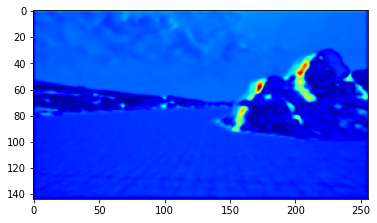

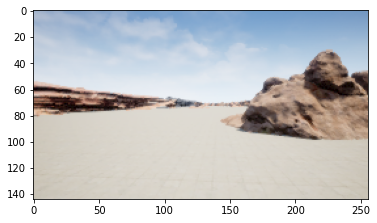

Left


In [189]:
i = -1
# for h in range(8):
#     plt.imshow(hmap1[i][:,:,h], cmap="jet")
#     plt.show()
plt.imshow(np.sum(hmap1[i], axis=-1), cmap="jet")
plt.show()
img = cv2.cvtColor(rgb_in[i], cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()
if(gt.item() == 0):
    print("Straight")
elif(gt.item() == 1):
    print("Right")
elif(gt.item() == 2):
    print("Left")

In [23]:
D = []
for idx, (input_img, gt) in enumerate(train_loader):
    for  x,y in zip(input_img, gt):
        x = torch.unsqueeze(x, 0)
        y = torch.unsqueeze(y, 0)
        x = x.to(device)
        outdata, i, conv_output_1, conv_output_2 = model(x)  
        hmap1 = np.moveaxis((conv_output_1[0].cpu()).detach().numpy(), 0, -1)
        hmap1 = np.sum(hmap1[-1], axis=-1)
        if(outdata[0].item() == 0):
            D.append("Straight")
        elif(outdata[0].item() == 1):
            D.append("Right")
        elif(outdata[0].item() == 2):
            D.append("Left")
    #     plt.text(10, 10, D, color="black")
        plt.imsave("L:\\BOUDIAF\\Nav\\model009\\frames_no_label\\"+str(idx)+".png", hmap1, cmap="jet")
    if(idx == 200): break
    
# rgb_in = np.moveaxis((input_img[0].cpu()).detach().numpy(), 0, -1)
# hmap1 = np.moveaxis((conv_output_1[0].cpu()).detach().numpy(), 0, -1)
# hmap2 = np.moveaxis((conv_output_2[0].cpu()).detach().numpy(), -1, 0)
# hmap2 = np.moveaxis(hmap2, 1, -1)

In [273]:
from PIL import Image
from PIL import ImageDraw

In [274]:
#Loading models paths
path = "L:\\BOUDIAF\\Nav\\model099\\frames\\"
frames_list = sorted(glob.glob(os.path.join(path, '*.png')))
frames_list = sorted(frames_list, key=lambda i: int(os.path.splitext(os.path.basename(i))[0]))

In [275]:
for idx, path in enumerate(frames_list):
    img = Image.open(path)
    I1 = ImageDraw.Draw(img)
    I1.text((10, 10), D[idx], fill=(0, 0, 0))
    img.save(path)

In [1]:
#New formate
f = open("L:\\BOUDIAF\\Nav\\model005_2\\read_me.txt", 'r')
content = f.read()
content = content.split('\n')

In [2]:
los0 = []
los1 = []
los2 = []
for idx, line in enumerate(content):
    if(line == ''): continue
    cls, l = line.split(':')
    if(cls == 'class0'):
        los0.append(l)
    elif(cls == 'class1'):
        los1.append(l)
    elif(cls == 'class2'):
        los2.append(l)

In [3]:
#Average of loss for each 1000 elements
avg = []
avg_los0 = []
for idx, i in enumerate(los0):
    if((idx%1000 == 0) & (idx != 0)):
        avg_los0.append(sum(avg)/len(avg))
        avg = []
    else:
        avg.append(float(i))
avg = []
avg_los1 = []
for idx, i in enumerate(los1):
    if((idx%1000 == 0) & (idx != 0)):
        avg_los1.append(sum(avg)/len(avg))
        avg = []
    else:
        avg.append(float(i))
avg = []
avg_los2 = []
for idx, i in enumerate(los2):
    if((idx%1000 == 0) & (idx != 0)):
        avg_los2.append(sum(avg)/len(avg))
        avg = []
    else:
        avg.append(float(i))

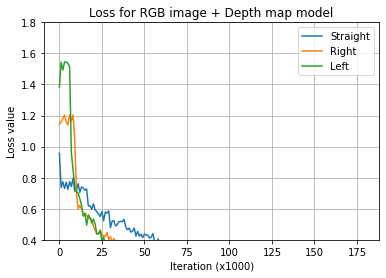

In [6]:
import matplotlib.pyplot as plt
plt.plot(avg_los0, label = "Straight")
plt.plot(avg_los1, label = "Right")
plt.plot(avg_los2, label = "Left")
plt.legend()
plt.grid(True)
plt.title('Loss for RGB image + Depth map model')
plt.xlabel('Iteration (x1000)')
plt.ylabel('Loss value')
plt.ylim(0.4, 1.8)
plt.savefig('L:\\BOUDIAF\\Nav\\model005_2\\loss.png')
plt.show()


In [70]:
#latency
import timeit
path = "L:\\BOUDIAF\\Nav\\model009\\"
models_list = sorted(glob.glob(os.path.join(path, '*.pth')))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = NavNet().to(device)
model.load_state_dict(torch.load(models_list[-1]))
print('START!!!!!!!!!!')
start = timeit.default_timer()
for idx, (input_img, gt) in enumerate(train_loader):
    for  x,y in zip(input_img, gt):
        x = torch.unsqueeze(x, 0)
        y = torch.unsqueeze(y, 0)
        x = x.to(device)
        outdata, i = model(x)
    if(idx==100): break
stop = timeit.default_timer()
print('Time: ', (stop - start)/800)  

START!!!!!!!!!!
Time:  0.18247590117251092
